In [3]:
import allel
from scipy.special import comb
from scipy.special import binom
from scipy.optimize import minimize
from collections import Counter
from itertools import combinations
import numpy as np
import pandas as pd
import sys
import os
import matplotlib.pylab as plt
from multiprocessing import Pool
import numba
import glob
import numpy_indexed as npi
from numba import jit, njit, prange
os.environ['KMP_DUPLICATE_LIB_OK']='True'
%matplotlib inline

In [2]:
vcf_path = "/Users/szabad/PycharmProjects/modified_ldsr/data/ALL.chr22.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes.vcf.gz"
callset = allel.read_vcf(vcf_path, log=sys.stdout)
gt = allel.GenotypeDaskArray(callset['calldata/GT'])

gt_chr = callset['variants/CHROM']
gt_id = callset['variants/ID']
gt_pos = callset['variants/POS']

[read_vcf] 65536 rows in 11.12s; chunk in 11.12s (5892 rows/s); 22 :18539397
[read_vcf] 131072 rows in 22.16s; chunk in 11.04s (5935 rows/s); 22 :21016127
[read_vcf] 196608 rows in 33.25s; chunk in 11.09s (5910 rows/s); 22 :23236362
[read_vcf] 262144 rows in 44.30s; chunk in 11.05s (5928 rows/s); 22 :25227844
[read_vcf] 327680 rows in 55.35s; chunk in 11.05s (5931 rows/s); 22 :27285434
[read_vcf] 393216 rows in 66.40s; chunk in 11.04s (5934 rows/s); 22 :29572822
[read_vcf] 458752 rows in 77.48s; chunk in 11.08s (5913 rows/s); 22 :31900536
[read_vcf] 524288 rows in 88.61s; chunk in 11.13s (5886 rows/s); 22 :34069864
[read_vcf] 589824 rows in 99.74s; chunk in 11.13s (5887 rows/s); 22 :36053392
[read_vcf] 655360 rows in 110.88s; chunk in 11.14s (5885 rows/s); 22 :38088395
[read_vcf] 720896 rows in 122.17s; chunk in 11.29s (5804 rows/s); 22 :40216200
[read_vcf] 786432 rows in 133.37s; chunk in 11.21s (5848 rows/s); 22 :42597446
[read_vcf] 851968 rows in 144.53s; chunk in 11.16s (5872 rows/

In [3]:
ac = gt.count_alleles()

# Remove multi-allelic variants & singletons
flt = (ac.max_allele() == 1) & (ac[:, :2].min(axis=1) > 1)

gtf = gt.compress(flt, axis=0).compute()

gtf_meta = pd.DataFrame({"CHR": gt_chr[flt], "SNP": gt_id[flt], "BP": gt_pos[flt]})
gtf_meta['LD2'] = None # The D2 LD Score

# For unphased data, we need the allele counts:
gtf_ac = gtf.to_n_alt(fill=-1).T

# Center the gtf_ac matrix for LD Score calculation:
gtf_ac_c = gtf_ac - np.mean(gtf_ac, axis=0).reshape(1, -1)

In [25]:
def multinomial(params):
    """
    Implementation by Reiner Martin
    https://stackoverflow.com/questions/46374185/does-python-have-a-function-which-computes-multinomial-coefficients
    """
    res, i = 1, 1
    for a in params:
        for j in range(1, a+1):
            res *= i
            res //= j
            i += 1
    return res


def get_haplotype_counts(idx1, idx2, num_chr=2):
    # Assume capital letters A/B correspond to mutant/alternative allele at each position
    # (i.e. 1 in the genotype array)
    # This method works for any diploidy.
    
    n_AB, n_ab, n_Ab, n_aB = 0, 0, 0, 0
    
    for ch in range(num_chr):
        n_AB += np.count_nonzero((gtf[idx1, :, ch] == 1) & (gtf[idx2, :, ch] == 1))
        n_ab += np.count_nonzero((gtf[idx1, :, ch] == 0) & (gtf[idx2, :, ch] == 0))
        n_Ab += np.count_nonzero((gtf[idx1, :, ch] == 1) & (gtf[idx2, :, ch] == 0))
        n_aB += np.count_nonzero((gtf[idx1, :, ch] == 0) & (gtf[idx2, :, ch] == 1))
    
    return n_AB, n_ab, n_Ab, n_aB

def d_squared_phased(hap_counts):
    """
    Implementation of estimator on Page 10 of Ragsdale & Gravel (bioRxiv, 2019)
    """
    
    n_AB, n_ab, n_Ab, n_aB = hap_counts
    n = sum(hap_counts)
    
    d2 = (1./multinomial([2, 0, 0, 2]))*(comb(n_AB, 2)*comb(n_ab, 2)/comb(n, 4))
    d2 += (1./multinomial([0, 2, 2, 0]))*(comb(n_Ab, 2)*comb(n_aB, 2)/comb(n, 4))
    d2 -= (2./multinomial([1, 1, 1, 1]))*(comb(n_AB, 1)*comb(n_Ab, 1)*comb(n_aB, 1)*comb(n_ab, 1)/comb(n, 4))

    return d2

@njit
def d_squared_unphased(counts, n):
    
    #n1, n2, n3, n4, n5, n6, n7, n8, n9 = counts
    n1 = counts[0, :]
    n2 = counts[1, :]
    n3 = counts[2, :]
    n4 = counts[3, :]
    n5 = counts[4, :]
    n6 = counts[5, :]
    n7 = counts[6, :]
    n8 = counts[7, :]
    n9 = counts[8, :]
    
    numer = (n2*n4 - n2**2*n4 + 4*n3*n4 - 4*n2*n3*n4 - 4*n3**2*n4 - n2*n4**2 - 4*n3*n4**2 + n1*n5 - n1**2*n5 + n3*n5 + 2*n1*n3*n5 - n3**2*n5 - 4*n3*n4*n5 - n1*n5**2 - n3*n5**2 + 4*n1*n6 - 4*n1**2*n6 + n2*n6 - 4*n1*n2*n6 - n2**2*n6 + 2*n2*n4*n6 - 4*n1*n5*n6 - 4*n1*n6**2 - n2*n6**2 + 4*n2*n7 - 4*n2**2*n7 + 16*n3*n7 - 16*n2*n3*n7 - 16*n3**2*n7 - 4*n2*n4*n7 - 16*n3*n4*n7 + n5*n7 + 2*n1*n5*n7 - 4*n2*n5*n7 - 18*n3*n5*n7 - n5**2*n7 + 4*n6*n7 + 8*n1*n6*n7 - 16*n3*n6*n7 - 4*n5*n6*n7 - 4*n6**2*n7 - 4*n2*n7**2 - 16*n3*n7**2 - n5*n7**2 - 4*n6*n7**2 + 4*n1*n8 - 4*n1**2*n8 + 4*n3*n8 + 8*n1*n3*n8 - 4*n3**2*n8 + n4*n8 - 4*n1*n4*n8 + 2*n2*n4*n8 - n4**2*n8 - 4*n1*n5*n8 - 4*n3*n5*n8 + n6*n8 + 2*n2*n6*n8 - 4*n3*n6*n8 + 2*n4*n6*n8 - n6**2*n8 - 16*n3*n7*n8 - 4*n6*n7*n8 - 4*n1*n8**2 - 4*n3*n8**2 - n4*n8**2 - n6*n8**2 + 16*n1*n9 - 16*n1**2*n9 + 4*n2*n9 - 16*n1*n2*n9 - 4*n2**2*n9 + 4*n4*n9 - 16*n1*n4*n9 + 8*n3*n4*n9 - 4*n4**2*n9 + n5*n9 - 18*n1*n5*n9 - 4*n2*n5*n9 + 2*n3*n5*n9 - 4*n4*n5*n9 - n5**2*n9 - 16*n1*n6*n9 - 4*n2*n6*n9 + 8*n2*n7*n9 + 2*n5*n7*n9 - 16*n1*n8*n9 - 4*n4*n8*n9 - 16*n1*n9**2 - 4*n2*n9**2 - 4*n4*n9**2 - n5*n9**2)/16. + (-((n2/2. + n3 + n5/4. + n6/2.)*(n4/2. + n5/4. + n7 + n8/2.)) + (n1 + n2/2. + n4/2. + n5/4.)*(n5/4. + n6/2. + n8/2. + n9))**2
    denom = n*(n-1)*(n-2)*(n-3)

    return 4. * numer / denom

def compute_d_squared_v2(idx1, idx2, phased=False):
    """
    np.bincount idea was suggested by Gareth Rees:
    https://codereview.stackexchange.com/questions/42846/speedup-cython-dictionary-counter
    """
    if phased:
        return d_squared_phased(get_haplotype_counts(idx1, idx2))
    else:
        gt_counts = np.bincount(gtf_ac[:, idx1]*3 + gtf_ac[:, idx2])
        ord_counts = [0]*(9-len(gt_counts)) + list(gt_counts)[::-1]
        return d_squared_unphased(ord_counts)

    
def compute_d_squared_centered(idx1, block=None):
    if block is None:
        return np.linalg.multi_dot([gtf_ac_c[:, idx1], gtf_ac_c, gtf_ac_c.T, gtf_ac_c[:, idx1]])
    else:
        return np.linalg.multi_dot([gtf_ac_c[idx1, :].T, gtf_ac_c.T, gtf_ac_c, gtf_ac_c[idx1, :].T])
    

In [23]:
def compute_modified_ld_score(max_dist=1e6):
    
    M = len(gtf_meta)
    N = gtf.shape[1]
    
    res = []
    
    for i in np.arange(5000, 100000, 5000): #range(M):

        maf_i = float(np.sum(gtf_ac[:, i])) / (N*2)
        pi_i = (float(N)/(N-1))*maf_i*(1. - maf_i)

        d2_i = 0.0
        for j in gtf_meta.loc[np.abs(gtf_meta['BP'] - gtf_meta.loc[i, 'BP']) < max_dist].index:
            d2_i += compute_d_squared_v2(i, j) 

        res.append(d2_i / pi_i) #gtf_meta.loc[i, 'LD2'] = d2_i / pi_i

        if (i + 1) % 1000 == 0:
            print("Computed LD Score for %d variants" % (i + 1))
    
    return res


def compute_modified_ld_score_parallel(i, max_dist=1e6):
    
    maf_i = float(np.sum(gtf_ac[:, i])) / (N*2)
    pi_i = (float(N)/(N-1))*maf_i*(1. - maf_i)

    d2_i = 0.0
    for j in gtf_meta.loc[np.abs(gtf_meta['BP'] - gtf_meta.loc[i, 'BP']) < max_dist].index:
        d2_i += compute_d_squared_v2(i, j) 

    gtf_meta.loc[i, 'LD2'] = d2_i / pi_i


def compute_modified_ld_score_vectorized(i, max_dist=1e6):
    
    N = gtf.shape[1]
    
    maf_i = float(np.sum(gtf_ac[:, i])) / (N*2)
    pi_i = (float(N)/(N-1))*maf_i*(1. - maf_i)
    
    neighb_snps = gtf_meta.loc[np.abs(gtf_meta['BP'] - gtf_meta.loc[i, 'BP']) < max_dist].index
    
    gt_counts = gtf_ac[:, i, np.newaxis]*3 + gtf_ac[:, neighb_snps]
    count_mat = bincount2D_numba(gt_counts)
    
    return np.sum(d_squared_unphased(count_mat[::-1, :], N)) / pi_i


In [23]:
%%time
compute_modified_ld_score()

CPU times: user 41 s, sys: 61.3 ms, total: 41 s
Wall time: 41 s


[0.0370084411521727,
 0.27323682051699316,
 5.865845740683278,
 0.21712092896164087,
 0.39569984190953544,
 1.8917969359203652,
 38.11003725215811,
 2.7849102660925946,
 0.6233819872130167,
 0.6539585490599569,
 0.17740703711040007,
 13.76902028253171,
 0.11194483611787946,
 3.376377797501642,
 0.21190556608617384,
 18.026827707962756,
 2.7435710306406658,
 1.5880739432529416,
 0.06086219855863521]

In [22]:
%%time
for i in np.arange(5000, 100000, 5000):
    compute_modified_ld_score_vectorized(i)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: overflow encountered in long_scalars
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: overflow encountered in long_scalars
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: overflow encountered in long_scalars
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: overflow encountered in long_scalars
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: overflow encountered in long_scalars
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: overflow encountered in long_scalars
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: overflow encountered in long_scalars
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: overflow encountered in long_scalars
/anaconda3/lib/python3.6/site-packages/ipykernel_launche

CPU times: user 1min 43s, sys: 475 ms, total: 1min 44s
Wall time: 18 s


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: overflow encountered in long_scalars


In [112]:
compute_modified_ld_score_vectorized(1)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: overflow encountered in long_scalars


9.439270098575686e-06

In [307]:
gt_count_mat.fill(0)
counts = np.unique(np.stack([gtf_ac[:, 1], gtf_ac[:, 2]], axis=1), axis=0, return_counts=True)
gt_count_mat[counts[0][:, 0], counts[0][:, 1]] = counts[1]
count_mat

array([[2.465e+03, 2.000e+00, 0.000e+00],
       [3.600e+01, 0.000e+00, 0.000e+00],
       [1.000e+00, 0.000e+00, 0.000e+00]])

In [284]:
count_mat[counts[0][:, 0], counts[0][:, 1]] = counts[1]

In [285]:
count_mat

array([[2.465e+03, 2.000e+00, 0.000e+00],
       [3.600e+01, 0.000e+00, 0.000e+00],
       [1.000e+00, 0.000e+00, 0.000e+00]])

In [286]:
counts[0][:, 0]

array([0, 0, 1, 2], dtype=int8)

In [315]:
count_mat.flatten()[::-1]

array([0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 3.600e+01,
       0.000e+00, 2.000e+00, 2.465e+03])

In [303]:
%%time

for idx1, idx2 in combinations(np.arange(1000), 2):
    compute_d_squared_v2(idx1, idx2)

CPU times: user 7min 9s, sys: 1.35 s, total: 7min 10s
Wall time: 7min 9s


In [300]:
%%time

for idx1, idx2 in combinations(np.arange(1000), 2):
    compute_d_squared(idx1, idx2)

CPU times: user 5min 32s, sys: 275 ms, total: 5min 33s
Wall time: 5min 33s


In [11]:
%%timeit

max_dist=1e6
s = 0

for idx1 in np.arange(1000):
    d2_i = gtf_meta.loc[np.abs(gtf_meta['BP'] - gtf_meta.loc[idx1, 'BP']) < max_dist].index

2.17 s ± 12.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [6]:
gt_counts = gtf_ac[:, 1, np.newaxis]*3 + gtf_ac[:, 2:20000]
rowidx, colidx = np.indices(gt_counts.shape)
print(1)
(nbin, col), B = npi.count_table(gt_counts.flatten(), colidx.flatten())

print(2)
if B.shape[0] < 9:
    count_mat = np.zeros((9, len(col)))
    count_mat[nbin, col] = B
else:
    count_mat = B

d_squared_unphased(count_mat[::-1, :])
print(3)

1


/Users/szabad/.local/lib/python3.6/site-packages/numpy_indexed/funcs.py:69: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  np.add.at(table, inverses, 1)


2
3


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: overflow encountered in long_scalars


In [10]:
def bincount2D_vectorized(a):    
    N = a.max()+1
    print(N)
    a_offs = a + np.arange(a.shape[1])[None, :]*N
    return np.bincount(a_offs.ravel(), minlength=a.shape[1]*N).reshape(-1, N).T

bincount2D_vectorized(gt_counts)

9


array([[2465, 2462, 2465, ..., 2462, 2465, 2465],
       [   2,    5,    2, ...,    5,    2,    2],
       [   0,    0,    0, ...,    0,    0,    0],
       ...,
       [   1,    1,    1, ...,    1,    1,    1],
       [   0,    0,    0, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0]])

In [69]:
compute_d_squared_v2(1, 2)

[0, 0, 1, 0, 0, 36, 0, 2, 2465]
2504
175.5


1.7899501698706258e-11

In [63]:
result = np.zeros((9, 3))
result[nbin, 0:3] = B
result[::-1, :]

array([[0.000e+00, 0.000e+00, 0.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00],
       [1.000e+00, 1.000e+00, 1.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00],
       [3.600e+01, 3.600e+01, 3.600e+01],
       [0.000e+00, 0.000e+00, 0.000e+00],
       [2.000e+00, 5.000e+00, 2.000e+00],
       [2.465e+03, 2.462e+03, 2.465e+03]])

In [42]:
#result = np.ones((9, 3))
res = result * cfilt[:, None]
res

array([[2.465e+03, 2.462e+03, 2.465e+03],
       [1.000e+00, 2.500e+00, 1.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00],
       [1.800e+01, 1.800e+01, 1.800e+01],
       [0.000e+00, 0.000e+00, 0.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00],
       [1.000e+00, 1.000e+00, 1.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00]])

array([ 361.  , 2256.25,  361.  ])

In [2]:
compute_d_squared_v2(1, 3)

NameError: name 'np' is not defined

In [140]:
np.random.randint(0,100,(100,100))

array([[72, 46, 36, ..., 56, 40, 73],
       [72, 71, 93, ..., 13, 84, 53],
       [59, 50, 68, ..., 77, 39, 43],
       ...,
       [ 3, 63, 89, ..., 89, 34, 24],
       [94, 36, 34, ..., 56, 57,  2],
       [13,  7, 66, ..., 67, 76, 33]])

In [8]:
def bincount2D_vectorized(a):    
    N = a.max()+1
    a_offs = a + np.arange(a.shape[1])[None, :]*N
    return np.bincount(a_offs.ravel(), minlength=a.shape[1]*N).reshape(-1, N).T

def bincount2D_numba(a):
    N = a.max()+1
    m,n = a.shape
    out = np.zeros((N, m),dtype=int)

    @njit(parallel=True)
    def numba_count(a, out, m, n):
        for i in prange(m):
            for j in prange(n):
                out[a[i,j], i] += 1
    
    numba_count(a, out, m, n)
    
    return out


In [15]:

bincount2D_numba(gt_counts.T)

array([[2465, 2462, 2465, ..., 2462, 2465, 2465],
       [   2,    5,    2, ...,    5,    2,    2],
       [   0,    0,    0, ...,    0,    0,    0],
       ...,
       [   1,    1,    1, ...,    1,    1,    1],
       [   0,    0,    0, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0]])

In [47]:
gt_counts = gtf_ac[:, 1, np.newaxis]*3 + gtf_ac[:, 2:20000]
ld_scores = d_squared_unphased(bincount2D_vectorized(gt_counts), 2054)[:100]

In [48]:
gtf_meta.loc[0:len(ld_scores),"LD2"].update(pd.Series(ld_scores))
gtf_meta.head()

,CHR,SNP,BP,LD2,LD_obe
0,22,rs587755077,16050115,3.95553e-11,None
1,22,rs587654921,16050213,3.95553e-10,None
2,22,rs587638893,16050568,3.95553e-11,None
3,22,rs587720402,16050607,3.95553e-11,None
4,22,rs587593704,16050627,0.000132748,None


In [40]:
ld_scores

array([ 3.95553022e-11,  3.95553022e-10,  3.95553022e-11,  3.95553022e-11,
        1.32747815e-04,  7.41042104e-09,  1.28554732e-08,  5.93329533e-10,
        6.76395667e-09,  3.95553022e-11, -4.20584710e-08,  1.18665907e-10,
        8.30661346e-10,  3.95553022e-11,  6.25563149e-06,  1.18665907e-10,
        1.18665907e-10,  1.96194299e-08,  1.18665907e-10,  1.18665907e-10,
        3.95553022e-10,  5.93329533e-10,  1.18665907e-10,  6.36416239e-06,
        1.10754846e-09,  3.95553022e-11,  3.95553022e-11,  2.36155477e-05,
        1.10754846e-09,  2.78073774e-08,  2.37331813e-10,  3.95553022e-11,
        5.03538997e-08, -2.17024222e-08,  1.77998860e-09,  1.21269851e-07,
        2.37331813e-10,  1.42399088e-09,  1.10754846e-09,  3.95553022e-11,
        4.35808453e-06,  3.95553022e-11, -6.84694392e-08,  7.51550742e-09,
        1.10754846e-09,  8.30661346e-10,  2.61064994e-09, -4.66534505e-08,
        3.95553022e-10,  1.42399088e-09, -1.43593438e-07,  1.18665907e-10,
        1.60198974e-08,  

In [17]:
rowidx, colidx = np.indices(gt_counts.shape)
print(1)
(nbin, col), B = npi.count_table(gt_counts.flatten(), colidx.flatten())

1


/Users/szabad/.local/lib/python3.6/site-packages/numpy_indexed/funcs.py:69: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  np.add.at(table, inverses, 1)


In [55]:
gtf_test = gtf_meta.reset_index().set_index('BP')
gtf_test.head()

,index,CHR,SNP,LD2,LD_obe
BP,,,,,
16050115,0,22,rs587755077,3.95553e-11,None
16050213,1,22,rs587654921,3.95553e-10,None
16050568,2,22,rs587638893,3.95553e-11,None
16050607,3,22,rs587720402,3.95553e-11,None
16050627,4,22,rs587593704,0.000132748,None


In [66]:
max_dist=1e6
gtf_ac[:, gtf_test.loc[np.abs(gtf_test.index - 16050607) < max_dist,'index']].shape

(2504, 10654)

In [77]:
%%timeit
t1 = gtf_test.loc[np.abs(gtf_test.index - 16050607) < max_dist,'index']

2.18 ms ± 54.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [78]:
%%timeit
t2 = gtf_meta.loc[np.abs(gtf_meta['BP'] - 16050607) < max_dist].index

3.04 ms ± 96.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [80]:
gtf_test.loc[np.abs(gtf_test.index - 16050607) < max_dist,'index']

BP
16050115        0
16050213        1
16050568        2
16050607        3
16050627        4
16050678        5
16050739        6
16050783        7
16050840        8
16050847        9
16050922       10
16050954       11
16050984       12
16050994       13
16051075       14
16051165       15
16051249       16
16051477       17
16051493       18
16051722       19
16051771       20
16051816       21
16051874       22
16051927       23
16052032       24
16052080       25
16052097       26
16052111       27
16052126       28
16052167       29
            ...  
17047272    10624
17047296    10625
17047411    10626
17047428    10627
17047520    10628
17047609    10629
17048053    10630
17048355    10631
17048378    10632
17048638    10633
17048672    10634
17048696    10635
17049115    10636
17049382    10637
17049518    10638
17049548    10639
17049565    10640
17049605    10641
17049788    10642
17049825    10643
17049827    10644
17049857    10645
17049859    10646
17049899    10647
1704990

In [81]:
gtf_meta.loc[np.abs(gtf_meta['BP'] - 16050607) < max_dist].index

Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                9,
            ...
            10644, 10645, 10646, 10647, 10648, 10649, 10650, 10651, 10652,
            10653],
           dtype='int64', length=10654)

In [82]:
gtf_test.iloc[1,].name

16050213

In [89]:
def compute_modified_ld_score_vectorized(i, max_dist=1e6):

    N = gtf.shape[1]

    maf_i = float(np.sum(gtf_ac[:, i])) / (N * 2)
    pi_i = (float(N) / (N - 1)) * maf_i * (1. - maf_i)

    neighb_snps_1 = gtf_meta.loc[np.abs(gtf_meta['BP'] - gtf_meta.loc[i, 'BP']) < max_dist].index
    neighb_snps = gtf_meta_test.loc[np.abs(gtf_meta_test.index - gtf_meta_test.iloc[i, ].name) < max_dist, 'index']
    print(neighb_snps_1)
    print(neighb_snps)

    gt_counts = gtf_ac[:, 1, np.newaxis]*3 + gtf_ac[:, neighb_snps]
    count_mat = bincount2D_numba(gt_counts)

    return np.sum(d_squared_unphased(count_mat[::-1, :], N)) / pi_i

compute_modified_ld_score_vectorized(100000)


Int64Index([ 86464,  86465,  86466,  86467,  86468,  86469,  86470,  86471,
             86472,  86473,
            ...
            121320, 121321, 121322, 121323, 121324, 121325, 121326, 121327,
            121328, 121329],
           dtype='int64', length=34866)
BP
21502525     86464
21503517     86465
21503947     86466
21504307     86467
21504341     86468
21504358     86469
21504857     86470
21504890     86471
21505102     86472
21505304     86473
21505341     86474
21505346     86475
21505436     86476
21505740     86477
21506196     86478
21506392     86479
21506399     86480
21506718     86481
21507841     86482
21508002     86483
21510324     86484
21510416     86485
21510471     86486
21510613     86487
21510649     86488
21510812     86489
21510890     86490
21511261     86491
21511801     86492
21511967     86493
             ...  
23499766    121300
23499907    121301
23499918    121302
23500119    121303
23500298    121304
23500356    121305
23500372    121306
23500400  

0.0

In [102]:

gtf_meta = gtf_meta.reset_index().set_index('BP', drop=False)
gtf_meta

,index,CHR,SNP,BP,LD2
BP,,,,,
16050115,0,22,rs587755077,16050115,None
16050213,1,22,rs587654921,16050213,None
16050568,2,22,rs587638893,16050568,None
16050607,3,22,rs587720402,16050607,None
16050627,4,22,rs587593704,16050627,None
16050678,5,22,rs139377059,16050678,None
16050739,6,22,rs587747231,16050739,None
16050783,7,22,rs587743568,16050783,None
16050840,8,22,rs587616822,16050840,None


In [87]:
gtf_meta_test

,index,CHR,SNP,BP,LD2
BP,,,,,
16050115,0,22,rs587755077,16050115,None
16050213,1,22,rs587654921,16050213,None
16050568,2,22,rs587638893,16050568,None
16050607,3,22,rs587720402,16050607,None
16050627,4,22,rs587593704,16050627,None
16050678,5,22,rs139377059,16050678,None
16050739,6,22,rs587747231,16050739,None
16050783,7,22,rs587743568,16050783,None
16050840,8,22,rs587616822,16050840,None


In [92]:
?gtf_meta.to_csv

In [97]:
allel.vcf_to_zarr(vcf_path, '/Users/szabad/PycharmProjects/modified_ldsr/data/chr22.zarr', fields='*')

In [96]:
import zarr

In [99]:
callset = zarr.open_group('/Users/szabad/PycharmProjects/modified_ldsr/data/chr22.zarr', mode='r')

In [115]:

def bincount2D_vectorized(a):
    N = a.max() + 1
    a_offs = a + np.arange(a.shape[1])[None, :] * N
    return np.bincount(a_offs.ravel(), minlength=a.shape[1] * N).reshape(-1, N).T


@njit(parallel=True)
def numba_count(a, out, m, n):
    for i in prange(m):
        for j in prange(n):
            out[a[i, j], i] += 1


def bincount2D_numba(a, N=9):
    # N: number of unique bins

    m, n = a.shape
    out = np.zeros((N, m), dtype=int)

    numba_count(a, out, m, n)

    return out

@njit
def d_squared_unphased(counts, n):
    """
    Implementation by Aaron Ragsdale
    """

    n1 = counts[0, :]
    n2 = counts[1, :]
    n3 = counts[2, :]
    n4 = counts[3, :]
    n5 = counts[4, :]
    n6 = counts[5, :]
    n7 = counts[6, :]
    n8 = counts[7, :]
    n9 = counts[8, :]

    numer = ((n2 * n4 - n2 ** 2 * n4 + 4 * n3 * n4 - 4 * n2 * n3 * n4 - 4 * n3 ** 2 * n4 - n2 * n4 ** 2 -
              4 * n3 * n4 ** 2 + n1 * n5 - n1 ** 2 * n5 + n3 * n5 + 2 * n1 * n3 * n5 - n3 ** 2 * n5 -
              4 * n3 * n4 * n5 - n1 * n5 ** 2 - n3 * n5 ** 2 + 4 * n1 * n6 - 4 * n1 ** 2 * n6 + n2 * n6 -
              4 * n1 * n2 * n6 - n2 ** 2 * n6 + 2 * n2 * n4 * n6 - 4 * n1 * n5 * n6 - 4 * n1 * n6 ** 2 - n2 * n6 ** 2 +
              4 * n2 * n7 - 4 * n2 ** 2 * n7 + 16 * n3 * n7 - 16 * n2 * n3 * n7 - 16 * n3 ** 2 * n7 -
              4 * n2 * n4 * n7 - 16 * n3 * n4 * n7 + n5 * n7 + 2 * n1 * n5 * n7 -
              4 * n2 * n5 * n7 - 18 * n3 * n5 * n7 - n5 ** 2 * n7 + 4 * n6 * n7 + 8 * n1 * n6 * n7 - 16 * n3 * n6 * n7 -
              4 * n5 * n6 * n7 - 4 * n6 ** 2 * n7 - 4 * n2 * n7 ** 2 - 16 * n3 * n7 ** 2 - n5 * n7 ** 2 -
              4 * n6 * n7 ** 2 + 4 * n1 * n8 - 4 * n1 ** 2 * n8 + 4 * n3 * n8 + 8 * n1 * n3 * n8 -
              4 * n3 ** 2 * n8 + n4 * n8 - 4 * n1 * n4 * n8 + 2 * n2 * n4 * n8 - n4 ** 2 * n8 -
              4 * n1 * n5 * n8 - 4 * n3 * n5 * n8 + n6 * n8 + 2 * n2 * n6 * n8 - 4 * n3 * n6 * n8 +
              2 * n4 * n6 * n8 - n6 ** 2 * n8 - 16 * n3 * n7 * n8 - 4 * n6 * n7 * n8 - 4 * n1 * n8 ** 2 -
              4 * n3 * n8 ** 2 - n4 * n8 ** 2 - n6 * n8 ** 2 + 16 * n1 * n9 - 16 * n1 ** 2 * n9 +
              4 * n2 * n9 - 16 * n1 * n2 * n9 - 4 * n2 ** 2 * n9 + 4 * n4 * n9 - 16 * n1 * n4 * n9 + 8 * n3 * n4 * n9 -
              4 * n4 ** 2 * n9 + n5 * n9 - 18 * n1 * n5 * n9 - 4 * n2 * n5 * n9 + 2 * n3 * n5 * n9 -
              4 * n4 * n5 * n9 - n5 ** 2 * n9 - 16 * n1 * n6 * n9 -
              4 * n2 * n6 * n9 + 8 * n2 * n7 * n9 + 2 * n5 * n7 * n9 - 16 * n1 * n8 * n9 - 4 * n4 * n8 * n9 -
              16 * n1 * n9 ** 2 - 4 * n2 * n9 ** 2 -
              4 * n4 * n9 ** 2 - n5 * n9 ** 2) / 16. +
             (-((n2 / 2. + n3 + n5 / 4. + n6 / 2.) * (n4 / 2. + n5 / 4. + n7 + n8 / 2.)) +
             (n1 + n2 / 2. + n4 / 2. + n5 / 4.) * (n5 / 4. + n6 / 2. + n8 / 2. + n9)) ** 2)

    return 4. * numer / (n * (n - 1) * (n - 2) * (n - 3))

def compute_modified_ld_score_vectorized(i, max_dist=1e6):

    N = gtf.shape[1]

    maf_i = float(np.sum(gtf_ac[:, i])) / (N * 2)
    pi_i = (float(N) / (N - 1)) * maf_i * (1. - maf_i)

    neighb_snps = gtf_meta.loc[(gtf_meta.index != gtf_meta.iloc[i, ].name) & 
                               (np.abs(gtf_meta.index - gtf_meta.iloc[i, ].name) < max_dist), 'index']

    gt_counts = gtf_ac[:, i, np.newaxis]*3 + gtf_ac[:, neighb_snps]
    count_mat = bincount2D_numba(gt_counts.T)

    return np.sum(d_squared_unphased(count_mat[::-1, :], N)) / pi_i

In [116]:
compute_modified_ld_score_vectorized(1)

[[2435 2465 2462 ... 2465 1065 1959]
 [  32    2    5 ...    2 1019  476]
 [   0    0    0 ...    0  383   32]
 ...
 [   1    1    1 ...    1    1    0]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0    1]]
(9, 10649)
0.0075332923175894986
1.0648491685628394


1.0648491685628394

In [118]:
bincount2D_vectorized(gt_counts)

array([[2465, 2462, 2465, ..., 2462, 2465, 2465],
       [   2,    5,    2, ...,    5,    2,    2],
       [   0,    0,    0, ...,    0,    0,    0],
       ...,
       [   1,    1,    1, ...,    1,    1,    1],
       [   0,    0,    0, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0]])

In [136]:
gtf_meta_t = gtf_meta.set_index('index')

In [138]:
l = [1, 2, 3, 4, 5, 6]
gtf_meta_t.loc[0:len(l), "LD2"].update(pd.Series(l))

In [139]:
gtf_meta_t

,CHR,SNP,BP,LD2
index,,,,
0,22,rs587755077,16050115,1
1,22,rs587654921,16050213,2
2,22,rs587638893,16050568,3
3,22,rs587720402,16050607,4
4,22,rs587593704,16050627,5
5,22,rs139377059,16050678,6
6,22,rs587747231,16050739,None
7,22,rs587743568,16050783,None
8,22,rs587616822,16050840,None


In [140]:
?gtf_meta.update

In [6]:
list(callset['samples'])

['HG00096',
 'HG00097',
 'HG00099',
 'HG00100',
 'HG00101',
 'HG00102',
 'HG00103',
 'HG00105',
 'HG00106',
 'HG00107',
 'HG00108',
 'HG00109',
 'HG00110',
 'HG00111',
 'HG00112',
 'HG00113',
 'HG00114',
 'HG00115',
 'HG00116',
 'HG00117',
 'HG00118',
 'HG00119',
 'HG00120',
 'HG00121',
 'HG00122',
 'HG00123',
 'HG00125',
 'HG00126',
 'HG00127',
 'HG00128',
 'HG00129',
 'HG00130',
 'HG00131',
 'HG00132',
 'HG00133',
 'HG00136',
 'HG00137',
 'HG00138',
 'HG00139',
 'HG00140',
 'HG00141',
 'HG00142',
 'HG00143',
 'HG00145',
 'HG00146',
 'HG00148',
 'HG00149',
 'HG00150',
 'HG00151',
 'HG00154',
 'HG00155',
 'HG00157',
 'HG00158',
 'HG00159',
 'HG00160',
 'HG00171',
 'HG00173',
 'HG00174',
 'HG00176',
 'HG00177',
 'HG00178',
 'HG00179',
 'HG00180',
 'HG00181',
 'HG00182',
 'HG00183',
 'HG00185',
 'HG00186',
 'HG00187',
 'HG00188',
 'HG00189',
 'HG00190',
 'HG00231',
 'HG00232',
 'HG00233',
 'HG00234',
 'HG00235',
 'HG00236',
 'HG00237',
 'HG00238',
 'HG00239',
 'HG00240',
 'HG00242',
 'HG

In [5]:
callset

{'samples': array(['HG00096', 'HG00097', 'HG00099', ..., 'NA21142', 'NA21143',
        'NA21144'], dtype=object), 'calldata/GT': array([[[0, 0],
         [0, 0],
         [0, 0],
         ...,
         [0, 0],
         [0, 0],
         [0, 0]],
 
        [[0, 0],
         [0, 0],
         [0, 0],
         ...,
         [0, 0],
         [0, 0],
         [0, 0]],
 
        [[0, 0],
         [0, 0],
         [0, 0],
         ...,
         [0, 0],
         [0, 0],
         [0, 0]],
 
        ...,
 
        [[0, 0],
         [0, 0],
         [0, 0],
         ...,
         [0, 0],
         [0, 0],
         [0, 0]],
 
        [[0, 0],
         [0, 0],
         [0, 0],
         ...,
         [0, 0],
         [0, 0],
         [0, 0]],
 
        [[0, 0],
         [0, 0],
         [0, 0],
         ...,
         [0, 0],
         [0, 0],
         [0, 0]]], dtype=int8), 'variants/ALT': array([['G', '', ''],
        ['A', '', ''],
        ['T', '', ''],
        ...,
        ['G', '', ''],
        ['T

In [7]:
(callset['samples'] in ['HG00100',
 'HG00101',
 'HG00102',
 'HG00103',
 'HG00105',
 'HG00106'])

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [10]:
np.isin(callset['samples'], ['HG00097', 'HG00100',
 'HG00101',
 'HG00102',
 'HG00103',
 'HG00105',
 'HG00106'])

array([False,  True, False, ..., False, False, False])

In [13]:
np.logical_and(*[[True, True, False], [True, False, True]])

array([ True, False, False])

In [16]:
ac

<AlleleCountsDaskArray shape=(1103547, 9) dtype=int32>

In [18]:
np.min(ac, axis=1).compute()

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [19]:
chr_num = 22
"./data/ALL.chr%d.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes.vcf.gz" % chr_num

'./data/ALL.chr22.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes.vcf.gz'

In [22]:
list(gtf_meta.iloc[5,]) + [2.1]

['22', 'rs139377059', 16050678, None, 2.1]

In [24]:
callset.keys()

dict_keys(['samples', 'calldata/GT', 'variants/ALT', 'variants/CHROM', 'variants/FILTER_PASS', 'variants/ID', 'variants/POS', 'variants/QUAL', 'variants/REF'])

In [33]:
gtf_ac.sum(axis=0)

array([32, 38,  2, ..., 70, 39, 19])

In [43]:
N = gtf_ac.shape[0]
maf = gtf_ac.sum(axis=0) / (2.*N)
np.where(maf > .5, 1. - maf, maf)

array([0.00638978, 0.00758786, 0.00039936, ..., 0.01397764, 0.00778754,
       0.00379393])

In [45]:
(np.where(maf > .5, 1. - maf, maf) > .5).sum()

0

In [47]:
gtf_meta.iloc[10,]['BP']

16050922

In [55]:
np.round(0.203423423423, 10)

0.2034234234

In [63]:
samples = pd.read_csv("./data/integrated_call_samples_v3.20130502.ALL.panel", sep="\t")
samples

,sample,pop,super_pop,gender,Unnamed: 4,Unnamed: 5
0,HG00096,GBR,EUR,male,NaN,NaN
1,HG00097,GBR,EUR,female,NaN,NaN
2,HG00099,GBR,EUR,female,NaN,NaN
3,HG00100,GBR,EUR,female,NaN,NaN
4,HG00101,GBR,EUR,male,NaN,NaN
5,HG00102,GBR,EUR,female,NaN,NaN
6,HG00103,GBR,EUR,male,NaN,NaN
7,HG00105,GBR,EUR,male,NaN,NaN
8,HG00106,GBR,EUR,female,NaN,NaN
9,HG00107,GBR,EUR,male,NaN,NaN


In [58]:
samples

,sample pop super_pop gender
0,HG00096\tGBR\tEUR\tmale
1,HG00097\tGBR\tEUR\tfemale
2,HG00099\tGBR\tEUR\tfemale
3,HG00100\tGBR\tEUR\tfemale
4,HG00101\tGBR\tEUR\tmale
5,HG00102\tGBR\tEUR\tfemale
6,HG00103\tGBR\tEUR\tmale
7,HG00105\tGBR\tEUR\tmale
8,HG00106\tGBR\tEUR\tfemale
9,HG00107\tGBR\tEUR\tmale


In [64]:
import subprocess

In [80]:
print(subprocess.check_output("ps -ef | grep python | grep szabad", shell=True).decode())

  504   611   601   0 Sun01pm ??         7:51.65 /anaconda3/bin/python -m ipykernel_launcher -f /Users/szabad/Library/Jupyter/runtime/kernel-dbf221b8-e8f1-470d-bcfc-dacefffa327d.json
  504  7751   611   0  6:44pm ??         0:00.00 /bin/sh -c ps -ef | grep python | grep szabad



In [81]:
np.random.randint(2, 10, size=20)

array([5, 4, 4, 3, 9, 2, 2, 3, 4, 9, 5, 6, 3, 2, 2, 2, 2, 9, 3, 3])

In [83]:
import datetime
idx=1000
print(str(datetime.datetime.now()) + " - Computed LD Score for %d variants" % idx)

2019-10-30 20:59:55.753185 - Computed LD Score for 1000 variants


In [84]:
print(numba.config.NUMBA_DEFAULT_NUM_THREADS)
print(numba.config.NUMBA_NUM_THREADS)
print(numba.config.LOOP_VECTORIZE)

8
8
True


In [87]:
numba.config.NUMBA_NUM_THREADS = 4

In [88]:
numba.config.NUMBA_NUM_THREADS

4

In [90]:
ldsc_dir = "./reference/eur_w_ld_chr/"
ldsc_file = "%d.l2.ldscore.gz"

mldsc_dir = "./output/EUR/"
mldsc_file = "1000G_Phase3_chr%d.mldscore.gz"

chr_num = 22

ldsc_df = pd.read_csv(os.path.join(ldsc_dir, ldsc_file % chr_num), sep="\t")
mldsc_df = pd.read_csv(os.path.join(mldsc_dir, mldsc_file % chr_num), sep="\t")

In [106]:
ldsc_df.head()

,CHR,SNP,BP,CM,MAF,L2
0,22,rs9617528,16061016,0.059576,0.245383,1.263114
1,22,rs4911642,16504399,2.127458,0.174142,1.796420
2,22,rs140378,16877135,2.246184,0.075198,3.824410
3,22,rs131560,16877230,2.246335,0.069921,3.742791
4,22,rs7287144,16886873,2.252105,0.298153,7.200976


In [93]:
joint_df = pd.merge(ldsc_df, mldsc_df, on='SNP')

In [94]:
joint_df.head()

,CHR_x,SNP,BP_x,CM,MAF_x,L2,CHR_y,BP_y,MAF_y,LD2
0,22,rs9617528,16061016,0.059576,0.245383,1.263114,22,16061016,0.258449,0.133504
1,22,rs4911642,16504399,2.127458,0.174142,1.796420,22,16504399,0.140159,0.221201
2,22,rs131560,16877230,2.246335,0.069921,3.742791,22,16877230,0.061630,9.894546
3,22,rs7287144,16886873,2.252105,0.298153,7.200976,22,16886873,0.311133,9.888199
4,22,rs5748616,16888900,2.253137,0.306069,7.357134,22,16888900,0.327038,5.142199


In [95]:
?pd.merge

In [97]:
joint_df[['L2', 'LD2']].max().max()

41.82543670660606

In [105]:
len(ldsc_df)

18613

In [103]:
@njit(parallel=True)
def test():
    k = np.zeros((10, 2), dtype=np.int_)
    return k

In [104]:
test()

array([[0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0]])

In [113]:
genmap = pd.read_csv("./reference/hapmap_geneticmap/chr22.interpolated_genetic_map.gz",
                     sep="\s+", names=['SNP', 'BP', 'CM'])
genmap.head()

,SNP,BP,CM
0,rs149201999,16050408,0.0
1,rs146752890,16050612,0.0
2,rs139377059,16050678,0.0
3,rs188945759,16050984,0.0
4,rs6518357,16051107,0.0


In [114]:
pd.merge(genmap, ldsc_df, on='SNP')

,SNP,BP_x,CM_x,CHR,BP_y,CM_y,MAF,L2
0,rs9617528,16061016,0.062391,22,16061016,0.059576,0.245383,1.263114
1,rs4911642,16504399,1.415086,22,16504399,2.127458,0.174142,1.796420
2,rs140378,16877135,1.625791,22,16877135,2.246184,0.075198,3.824410
3,rs131560,16877230,1.625998,22,16877230,2.246335,0.069921,3.742791
4,rs7287144,16886873,1.631737,22,16886873,2.252105,0.298153,7.200976
5,rs5748616,16888900,1.632523,22,16888900,2.253137,0.306069,7.357134
6,rs5748662,16892858,1.634094,22,16892858,2.255191,0.299472,7.170366
7,rs5994034,16894090,1.634590,22,16894090,2.255836,0.120053,2.892238
8,rs4010554,16894264,1.634662,22,16894264,2.255929,0.316623,6.951799
9,rs4010558,16896762,1.635779,22,16896762,2.257383,0.306069,7.357134


In [118]:
sample_bim = pd.read_csv("../../Downloads/1kg_eur/22.bim", sep="\t", names=['chr', 'SNP', 'CM', 'BP', 'ref', 'alt'])
sample_bim.head()

,chr,SNP,CM,BP,ref,alt
0,22,rs9617528,0.059576,16061016,C,T
1,22,rs4911642,2.127458,16504399,C,T
2,22,rs140378,2.246184,16877135,G,C
3,22,rs131560,2.246335,16877230,C,G
4,22,rs7287144,2.252105,16886873,G,A


In [119]:
len(sample_bim)

19156

In [120]:
sample_bim['CM'].describe()

count    19156.000000
mean        40.248609
std         18.287481
min          0.059576
25%         27.649684
50%         39.986754
75%         52.897074
max         75.116298
Name: CM, dtype: float64

In [128]:
allel.rogers_huff_r_between(gtf_ac[:, 1].T, gtf_ac[:, 2:3].T)

TypeError: bad number of dimensions: expected 2; found 1

In [ ]:
allel.rogers_huff_r(gtf_ac)**2

In [18]:
ld_callset = allel.read_vcf("./reference/1kg_eur/22.vcf", log=sys.stdout)
ld_gt = allel.GenotypeDaskArray(ld_callset['calldata/GT'])
ld_gt_ac = ld_gt.to_n_alt(fill=-1).compute().T
ld_gt_ac

[read_vcf] 19156 rows in 0.48s; chunk in 0.48s (39709 rows/s)
[read_vcf] all done (39668 rows/s)


array([[0, 0, 1, ..., 0, 1, 0],
       [0, 0, 1, ..., 1, 1, 1],
       [0, 0, 0, ..., 0, 1, 1],
       ...,
       [0, 0, 0, ..., 0, 1, 0],
       [2, 1, 0, ..., 1, 0, 0],
       [1, 1, 0, ..., 1, 0, 0]], dtype=int8)

In [25]:
n_gt_ac = (ld_gt_ac - np.mean(ld_gt_ac, axis=0)) / np.var(ld_gt_ac, axis=0)

In [46]:
np.sum(allel.rogers_huff_r_between(ld_gt_ac[:, 1, np.newaxis].T, ld_gt_ac[:, 3:5].T)**2)

0.035929777

In [38]:
ld_gt_ac[:, 3:4]

array([[1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
    

In [13]:
gt_meta

,CHR_x,SNP,BP_x,LD2,CHR_y,CM,BP_y,A1,A2
0,22,rs9617528,16061016,None,22,0.059576,16061016,C,T
1,22,rs4911642,16504399,None,22,2.127458,16504399,C,T
2,22,rs131560,16877230,None,22,2.246335,16877230,C,G
3,22,rs7287144,16886873,None,22,2.252105,16886873,G,A
4,22,rs5748616,16888900,None,22,2.253137,16888900,G,C
5,22,rs5748662,16892858,None,22,2.255191,16892858,A,G
6,22,rs5994034,16894090,None,22,2.255836,16894090,T,C
7,22,rs4010554,16894264,None,22,2.255929,16894264,A,C
8,22,rs4010558,16896762,None,22,2.257383,16896762,A,G
9,22,rs3954571,16953560,None,22,2.297102,16953560,T,C


In [16]:
cm_dist = 1.
gt_meta.loc[np.abs(gt_meta['CM'] - gt_meta.iloc[10, ]['CM']) < cm_dist, ]

,CHR_x,SNP,BP_x,LD2,CHR_y,CM,BP_y,A1,A2
1,22,rs4911642,16504399,None,22,2.127458,16504399,C,T
2,22,rs131560,16877230,None,22,2.246335,16877230,C,G
3,22,rs7287144,16886873,None,22,2.252105,16886873,G,A
4,22,rs5748616,16888900,None,22,2.253137,16888900,G,C
5,22,rs5748662,16892858,None,22,2.255191,16892858,A,G
6,22,rs5994034,16894090,None,22,2.255836,16894090,T,C
7,22,rs4010554,16894264,None,22,2.255929,16894264,A,C
8,22,rs4010558,16896762,None,22,2.257383,16896762,A,G
9,22,rs3954571,16953560,None,22,2.297102,16953560,T,C
10,22,rs11089179,16953727,None,22,2.297132,16953727,G,A


In [50]:
@njit(parallel=True)
def numba_count(a, out, m, n):
    for i in prange(m):
        for j in prange(n):
            out[a[i, j], i] += 1


@njit(parallel=True)
def bincount2D_numba(a, bin_num=9):

    m, n = a.shape
    out = np.zeros((bin_num, m), dtype=np.int_)

    numba_count(a, out, m, n)

    return out

gt_counts = ld_gt_ac[:, 1, np.newaxis]*3 + ld_gt_ac[:, 2:10]
count_mat = bincount2D_numba(gt_counts.T)

In [52]:
def DD(counts):
    # compute D^2 for pop in pop_nums
    cs = counts
    n1,n2,n3,n4,n5,n6,n7,n8,n9 = cs
    n = sum(cs)
    print(n)
    numer = (n2*n4 - n2**2*n4 + 4*n3*n4 - 4*n2*n3*n4 - 4*n3**2*n4 - n2*n4**2 - 4*n3*n4**2 + n1*n5 - n1**2*n5 + n3*n5 + 2*n1*n3*n5 - n3**2*n5 - 4*n3*n4*n5 - n1*n5**2 - n3*n5**2 + 4*n1*n6 - 4*n1**2*n6 + n2*n6 - 4*n1*n2*n6 - n2**2*n6 + 2*n2*n4*n6 - 4*n1*n5*n6 - 4*n1*n6**2 - n2*n6**2 + 4*n2*n7 - 4*n2**2*n7 + 16*n3*n7 - 16*n2*n3*n7 - 16*n3**2*n7 - 4*n2*n4*n7 - 16*n3*n4*n7 + n5*n7 + 2*n1*n5*n7 - 4*n2*n5*n7 - 18*n3*n5*n7 - n5**2*n7 + 4*n6*n7 + 8*n1*n6*n7 - 16*n3*n6*n7 - 4*n5*n6*n7 - 4*n6**2*n7 - 4*n2*n7**2 - 16*n3*n7**2 - n5*n7**2 - 4*n6*n7**2 + 4*n1*n8 - 4*n1**2*n8 + 4*n3*n8 + 8*n1*n3*n8 - 4*n3**2*n8 + n4*n8 - 4*n1*n4*n8 + 2*n2*n4*n8 - n4**2*n8 - 4*n1*n5*n8 - 4*n3*n5*n8 + n6*n8 + 2*n2*n6*n8 - 4*n3*n6*n8 + 2*n4*n6*n8 - n6**2*n8 - 16*n3*n7*n8 - 4*n6*n7*n8 - 4*n1*n8**2 - 4*n3*n8**2 - n4*n8**2 - n6*n8**2 + 16*n1*n9 - 16*n1**2*n9 + 4*n2*n9 - 16*n1*n2*n9 - 4*n2**2*n9 + 4*n4*n9 - 16*n1*n4*n9 + 8*n3*n4*n9 - 4*n4**2*n9 + n5*n9 - 18*n1*n5*n9 - 4*n2*n5*n9 + 2*n3*n5*n9 - 4*n4*n5*n9 - n5**2*n9 - 16*n1*n6*n9 - 4*n2*n6*n9 + 8*n2*n7*n9 + 2*n5*n7*n9 - 16*n1*n8*n9 - 4*n4*n8*n9 - 16*n1*n9**2 - 4*n2*n9**2 - 4*n4*n9**2 - n5*n9**2)/16. + (-((n2/2. + n3 + n5/4. + n6/2.)*(n4/2. + n5/4. + n7 + n8/2.)) + (n1 + n2/2. + n4/2. + n5/4.)*(n5/4. + n6/2. + n8/2. + n9))**2
    denom = n*(n-1)*(n-2)*(n-3)
    return 4. * numer / denom

def d_squared_unphased(counts, n):
    """
    Implementation by Aaron Ragsdale
    """

    n1 = counts[0, :]
    n2 = counts[1, :]
    n3 = counts[2, :]
    n4 = counts[3, :]
    n5 = counts[4, :]
    n6 = counts[5, :]
    n7 = counts[6, :]
    n8 = counts[7, :]
    n9 = counts[8, :]

    numer = ((n2 * n4 - n2 ** 2 * n4 + 4 * n3 * n4 - 4 * n2 * n3 * n4 - 4 * n3 ** 2 * n4 - n2 * n4 ** 2 -
              4 * n3 * n4 ** 2 + n1 * n5 - n1 ** 2 * n5 + n3 * n5 + 2 * n1 * n3 * n5 - n3 ** 2 * n5 -
              4 * n3 * n4 * n5 - n1 * n5 ** 2 - n3 * n5 ** 2 + 4 * n1 * n6 - 4 * n1 ** 2 * n6 + n2 * n6 -
              4 * n1 * n2 * n6 - n2 ** 2 * n6 + 2 * n2 * n4 * n6 - 4 * n1 * n5 * n6 - 4 * n1 * n6 ** 2 - n2 * n6 ** 2 +
              4 * n2 * n7 - 4 * n2 ** 2 * n7 + 16 * n3 * n7 - 16 * n2 * n3 * n7 - 16 * n3 ** 2 * n7 -
              4 * n2 * n4 * n7 - 16 * n3 * n4 * n7 + n5 * n7 + 2 * n1 * n5 * n7 -
              4 * n2 * n5 * n7 - 18 * n3 * n5 * n7 - n5 ** 2 * n7 + 4 * n6 * n7 + 8 * n1 * n6 * n7 - 16 * n3 * n6 * n7 -
              4 * n5 * n6 * n7 - 4 * n6 ** 2 * n7 - 4 * n2 * n7 ** 2 - 16 * n3 * n7 ** 2 - n5 * n7 ** 2 -
              4 * n6 * n7 ** 2 + 4 * n1 * n8 - 4 * n1 ** 2 * n8 + 4 * n3 * n8 + 8 * n1 * n3 * n8 -
              4 * n3 ** 2 * n8 + n4 * n8 - 4 * n1 * n4 * n8 + 2 * n2 * n4 * n8 - n4 ** 2 * n8 -
              4 * n1 * n5 * n8 - 4 * n3 * n5 * n8 + n6 * n8 + 2 * n2 * n6 * n8 - 4 * n3 * n6 * n8 +
              2 * n4 * n6 * n8 - n6 ** 2 * n8 - 16 * n3 * n7 * n8 - 4 * n6 * n7 * n8 - 4 * n1 * n8 ** 2 -
              4 * n3 * n8 ** 2 - n4 * n8 ** 2 - n6 * n8 ** 2 + 16 * n1 * n9 - 16 * n1 ** 2 * n9 +
              4 * n2 * n9 - 16 * n1 * n2 * n9 - 4 * n2 ** 2 * n9 + 4 * n4 * n9 - 16 * n1 * n4 * n9 + 8 * n3 * n4 * n9 -
              4 * n4 ** 2 * n9 + n5 * n9 - 18 * n1 * n5 * n9 - 4 * n2 * n5 * n9 + 2 * n3 * n5 * n9 -
              4 * n4 * n5 * n9 - n5 ** 2 * n9 - 16 * n1 * n6 * n9 -
              4 * n2 * n6 * n9 + 8 * n2 * n7 * n9 + 2 * n5 * n7 * n9 - 16 * n1 * n8 * n9 - 4 * n4 * n8 * n9 -
              16 * n1 * n9 ** 2 - 4 * n2 * n9 ** 2 -
              4 * n4 * n9 ** 2 - n5 * n9 ** 2) / 16. +
             (-((n2 / 2. + n3 + n5 / 4. + n6 / 2.) * (n4 / 2. + n5 / 4. + n7 + n8 / 2.)) +
             (n1 + n2 / 2. + n4 / 2. + n5 / 4.) * (n5 / 4. + n6 / 2. + n8 / 2. + n9)) ** 2)

    return 4. * numer / (n * (n - 1) * (n - 2) * (n - 3))

DD(count_mat[::-1, :])

[379 379 379 379 379 379 379 379]


array([ 3.61764209e-05,  1.29887345e-05,  9.92625693e-04,  1.17985028e-03,
        1.02290883e-03, -4.02305532e-05,  1.35165079e-03,  1.17985028e-03])

In [53]:
d_squared_unphased(count_mat[::-1, :], 379)

array([ 3.61764209e-05,  1.29887345e-05,  9.92625693e-04,  1.17985028e-03,
        1.02290883e-03, -4.02305532e-05,  1.35165079e-03,  1.17985028e-03])

In [18]:
from pandas_plink import read_plink1_bin
G = read_plink1_bin("/Users/szabad/PycharmProjects/modified_ldsr/data/1000G_EUR_Phase3_plink/1000G.EUR.QC.16.bed")#,
    #                "chr11.bim", "chr11.fam", verbose=False)

Mapping files: 100%|██████████| 3/3 [00:00<00:00,  3.56it/s]


In [19]:
np.abs(2. - G.values)

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [26]:
G.values.shape

(489, 316981)

In [17]:
G

<xarray.DataArray 'genotype' (sample: 489, variant: 138712)>
dask.array<transpose, shape=(489, 138712), dtype=float64, chunksize=(489, 1024)>
Coordinates:
  * sample   (sample) object 'HG00096' 'HG00097' ... 'NA20828' 'NA20832'
  * variant  (variant) object '21_rs146134162' ... '21_rs374001814'
    fid      (sample) <U7 'HG00096' 'HG00097' 'HG00099' ... 'NA20828' 'NA20832'
    iid      (sample) <U7 'HG00096' 'HG00097' 'HG00099' ... 'NA20828' 'NA20832'
    father   (sample) <U1 '0' '0' '0' '0' '0' '0' ... '0' '0' '0' '0' '0' '0'
    mother   (sample) <U1 '0' '0' '0' '0' '0' '0' ... '0' '0' '0' '0' '0' '0'
    gender   (sample) <U1 '0' '0' '0' '0' '0' '0' ... '0' '0' '0' '0' '0' '0'
    trait    (sample) float64 -9.0 -9.0 -9.0 -9.0 -9.0 ... -9.0 -9.0 -9.0 -9.0
    chrom    (variant) <U2 '21' '21' '21' '21' '21' ... '21' '21' '21' '21' '21'
    snp      (variant) <U11 'rs146134162' 'rs578050168' ... 'rs374001814'
    cm       (variant) float64 -0.9083 -0.9081 -0.9073 ... 64.65 64.65 64.65
    pos      (variant) int64 9412099 9412377 9413645 ... 48119252 48119510
    a0       (variant) <U1 'T' 'A' 'G' 'A' 'A' 'G' ... 'C' 'G' 'T' 'G' 'A' 'T'
    a1       (variant) <U1 'C' 'G' 'T' 'G' 'G' 'A' ... 'A' 'C' 'C' 'T' 'G' 'C'

In [16]:
?read_plink1_bin

In [24]:
from pandas_plink import read_plink
(bim, fam, bed) = read_plink("/Users/szabad/PycharmProjects/modified_ldsr/data/1000G_EUR_Phase3_plink/1000G.EUR.QC.16")
bed.compute()

Mapping files: 100%|██████████| 3/3 [00:00<00:00,  7.82it/s]


array([[2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.],
       ...,
       [2., 2., 2., ..., 2., 2., 2.],
       [1., 2., 2., ..., 1., 1., 2.],
       [2., 2., 2., ..., 2., 2., 2.]])

In [25]:
?read_plink

In [27]:
df = pd.read_csv("/Users/szabad/PycharmProjects/modified_ldsr/reference/1000G_Phase3_baselineLD_v2.2_ldscores/baselineLD.1.l2.ldscore.gz", sep="\t")
df.head()

,CHR,SNP,BP,baseL2,Coding_UCSCL2,Coding_UCSC.flanking.500L2,Conserved_LindbladTohL2,Conserved_LindbladToh.flanking.500L2,CTCF_HoffmanL2,CTCF_Hoffman.flanking.500L2,...,Human_Promoter_Villar.flanking.500L2,Human_Enhancer_VillarL2,Human_Enhancer_Villar.flanking.500L2,Ancient_Sequence_Age_Human_PromoterL2,Ancient_Sequence_Age_Human_Promoter.flanking.500L2,Ancient_Sequence_Age_Human_EnhancerL2,Ancient_Sequence_Age_Human_Enhancer.flanking.500L2,Human_Enhancer_Villar_Species_Enhancer_CountL2,Human_Promoter_Villar_ExACL2,Human_Promoter_Villar_ExAC.flanking.500L2
0,1,rs3094315,752566,80.826,0.178,0.610,0.325,2.387,4.870,10.961,...,2.153,4.691,5.810,0.103,0.148,0.050,0.159,0.105,0.0,0.0
1,1,rs3131972,752721,80.939,0.183,0.630,0.328,2.463,4.896,11.019,...,2.138,4.713,5.830,0.107,0.149,0.043,0.186,0.104,0.0,0.0
2,1,rs3131969,754182,90.291,0.313,0.925,0.425,3.116,6.225,11.540,...,1.393,5.751,5.548,0.169,0.220,0.066,0.272,0.135,0.0,0.0
3,1,rs1048488,760912,80.679,0.180,0.629,0.327,2.472,4.896,10.933,...,2.127,4.707,5.743,0.100,0.149,0.050,0.180,0.129,0.0,0.0
4,1,rs3115850,761147,80.483,0.147,0.575,0.309,2.354,4.844,10.919,...,2.169,4.679,5.786,0.091,0.134,0.049,0.180,0.126,0.0,0.0


In [109]:
pd.read_csv("/Users/szabad/PycharmProjects/modified_ldsr/reference/1000G_Phase3_baselineLD_v2.2_ldscores/baselineLD.1.l2.M", header=None, sep="\t").iloc[:1, :1].values

array([[779354.]])

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  
/anaconda3/lib/python3.6/site-packages/pandas/io/parsers.py:2379: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())
/anaconda3/lib/python3.6/site-packages/pandas/io/parsers.py:2381: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())


Index(['CHR', 'SNP', 'A1', 'A2', 'MAF', 'NCHROBS'], dtype='object')
Index(['CHR', 'SNP', 'CM', 'BP', 'MAF', 'LD2', 'L2'], dtype='object')


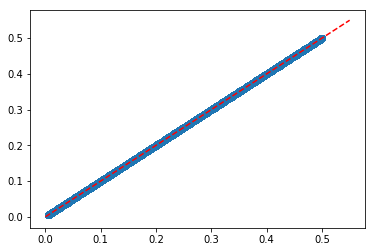

Index(['CHR', 'SNP', 'A1', 'A2', 'MAF', 'NCHROBS'], dtype='object')
Index(['CHR', 'SNP', 'CM', 'BP', 'MAF', 'LD2', 'L2'], dtype='object')


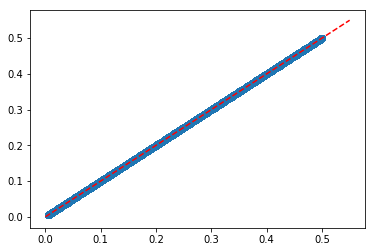

KeyboardInterrupt: 

In [40]:
phase1_freq = "/Users/szabad/PycharmProjects/modified_ldsr/data/1000G_Phase3_frq"
output_dir = "/Users/szabad/PycharmProjects/modified_ldsr/output/Phase3_mldscores/EUR/"

x = np.linspace(0.0, .55, 1000)

for chrs in range(1, 23):
    
    frq_df = pd.read_csv(os.path.join(phase1_freq, "1000G.EUR.QC.%d.frq" % chrs), sep="\s*")
    print(frq_df.columns)
    ld_df = pd.read_csv(os.path.join(output_dir, "chr%d.mldscore.gz" % chrs), sep="\t")
    print(ld_df.columns)
    joint = pd.merge(frq_df, ld_df, on="SNP")
    
    plt.plot(x, x, linestyle='--', color='r')
    plt.scatter(joint['MAF_x'], joint['MAF_y'])
    plt.show()

In [65]:
mydir = "/Users/szabad/PycharmProjects/modified_ldsr/output/Phase3_mldscores/EUR"
output = "/Users/szabad/PycharmProjects/modified_ldsr/output/Phase3_mldscores_D2_only/EUR/"

for f in glob.glob(os.path.join(mydir, '*.gz')):
    
    output_fname = os.path.join(output, os.path.basename(f))
    
    print(f)
    df = pd.read_csv(f, sep="\t")

    df['L2'] = df['LD2']
    df.drop('LD2', axis=1, inplace=True)
    
    df.to_csv(output_fname, sep="\t", index=False)
    
    M = len(df)
    M_5_50 = len(df.loc[df['MAF'] >= .05,])
    
    with open(output_fname.replace('.ldscore.gz', '.M'), 'w') as wf:
        wf.write(str(M) + '\n')
    
    with open(output_fname.replace('.ldscore.gz', '.M_5_50'), 'w') as wf:
        wf.write(str(M_5_50) + '\n')


/Users/szabad/PycharmProjects/modified_ldsr/output/Phase3_mldscores/EUR/D2_12.l2.ldscore.gz
/Users/szabad/PycharmProjects/modified_ldsr/output/Phase3_mldscores/EUR/D2_16.l2.ldscore.gz
/Users/szabad/PycharmProjects/modified_ldsr/output/Phase3_mldscores/EUR/D2_5.l2.ldscore.gz
/Users/szabad/PycharmProjects/modified_ldsr/output/Phase3_mldscores/EUR/D2_1.l2.ldscore.gz
/Users/szabad/PycharmProjects/modified_ldsr/output/Phase3_mldscores/EUR/D2_6.l2.ldscore.gz
/Users/szabad/PycharmProjects/modified_ldsr/output/Phase3_mldscores/EUR/D2_2.l2.ldscore.gz
/Users/szabad/PycharmProjects/modified_ldsr/output/Phase3_mldscores/EUR/D2_11.l2.ldscore.gz
/Users/szabad/PycharmProjects/modified_ldsr/output/Phase3_mldscores/EUR/D2_15.l2.ldscore.gz
/Users/szabad/PycharmProjects/modified_ldsr/output/Phase3_mldscores/EUR/D2_22.l2.ldscore.gz
/Users/szabad/PycharmProjects/modified_ldsr/output/Phase3_mldscores/EUR/D2_8.l2.ldscore.gz
/Users/szabad/PycharmProjects/modified_ldsr/output/Phase3_mldscores/EUR/D2_18.l2.ldsc

In [69]:
DF = pd.read_csv("/Users/szabad/PycharmProjects/modified_ldsr/reference/1000G_Phase3_baselineLD_v2.2_ldscores/baselineLD.1.l2.ldscore.gz", sep="\t")
DF.head()

,CHR,SNP,BP,baseL2,Coding_UCSCL2,Coding_UCSC.flanking.500L2,Conserved_LindbladTohL2,Conserved_LindbladToh.flanking.500L2,CTCF_HoffmanL2,CTCF_Hoffman.flanking.500L2,...,Human_Promoter_Villar.flanking.500L2,Human_Enhancer_VillarL2,Human_Enhancer_Villar.flanking.500L2,Ancient_Sequence_Age_Human_PromoterL2,Ancient_Sequence_Age_Human_Promoter.flanking.500L2,Ancient_Sequence_Age_Human_EnhancerL2,Ancient_Sequence_Age_Human_Enhancer.flanking.500L2,Human_Enhancer_Villar_Species_Enhancer_CountL2,Human_Promoter_Villar_ExACL2,Human_Promoter_Villar_ExAC.flanking.500L2
0,1,rs3094315,752566,80.826,0.178,0.610,0.325,2.387,4.870,10.961,...,2.153,4.691,5.810,0.103,0.148,0.050,0.159,0.105,0.0,0.0
1,1,rs3131972,752721,80.939,0.183,0.630,0.328,2.463,4.896,11.019,...,2.138,4.713,5.830,0.107,0.149,0.043,0.186,0.104,0.0,0.0
2,1,rs3131969,754182,90.291,0.313,0.925,0.425,3.116,6.225,11.540,...,1.393,5.751,5.548,0.169,0.220,0.066,0.272,0.135,0.0,0.0
3,1,rs1048488,760912,80.679,0.180,0.629,0.327,2.472,4.896,10.933,...,2.127,4.707,5.743,0.100,0.149,0.050,0.180,0.129,0.0,0.0
4,1,rs3115850,761147,80.483,0.147,0.575,0.309,2.354,4.844,10.919,...,2.169,4.679,5.786,0.091,0.134,0.049,0.180,0.126,0.0,0.0


In [70]:
DF.tail()

,CHR,SNP,BP,baseL2,Coding_UCSCL2,Coding_UCSC.flanking.500L2,Conserved_LindbladTohL2,Conserved_LindbladToh.flanking.500L2,CTCF_HoffmanL2,CTCF_Hoffman.flanking.500L2,...,Human_Promoter_Villar.flanking.500L2,Human_Enhancer_VillarL2,Human_Enhancer_Villar.flanking.500L2,Ancient_Sequence_Age_Human_PromoterL2,Ancient_Sequence_Age_Human_Promoter.flanking.500L2,Ancient_Sequence_Age_Human_EnhancerL2,Ancient_Sequence_Age_Human_Enhancer.flanking.500L2,Human_Enhancer_Villar_Species_Enhancer_CountL2,Human_Promoter_Villar_ExACL2,Human_Promoter_Villar_ExAC.flanking.500L2
98637,1,rs4926502,249209140,13.065,0.294,0.500,0.024,1.761,0.246,0.718,...,0.030,0.368,0.022,-0.005,0.038,0.018,0.010,0.0,0.0,0.0
98638,1,rs6704311,249210707,64.898,2.944,3.927,0.745,9.505,3.020,1.211,...,1.232,0.697,0.264,0.097,0.868,0.038,0.059,0.0,0.0,0.0
98639,1,rs34013644,249211350,63.956,4.076,3.306,1.274,9.864,3.270,1.125,...,0.801,1.002,0.159,0.143,1.000,0.035,0.080,0.0,0.0,0.0
98640,1,rs12746903,249218992,38.261,1.229,1.420,0.281,4.462,2.357,1.480,...,0.432,0.548,0.129,-0.011,0.395,0.032,0.129,0.0,0.0,0.0
98641,1,rs12726733,249222473,5.283,0.000,0.062,-0.002,0.614,0.497,0.041,...,0.000,0.006,-0.009,-0.002,0.013,0.001,-0.005,0.0,0.0,0.0


In [91]:
snp_list = pd.read_csv("reference/w_hm3.snplist.bz2", sep="\t")
snp_list.head()

,SNP,A1,A2
0,rs3094315,G,A
1,rs3131972,A,G
2,rs3131969,A,G
3,rs1048488,C,T
4,rs3115850,T,C


In [76]:
DF = []
for f in glob.glob("./reference/hapmap3_snps/*"):
    DF.append(pd.read_csv(f, header=None))
    
DF = pd.concat(DF)
len(DF)

1389227

In [77]:
DF.head()

,0
0,rs4819391
1,rs11089128
2,rs11912265
3,rs4321465
4,rs8138488


In [82]:
gt_ac = read_plink1_bin(os.path.join("./data/1000G_EUR_Phase3_plink", "1000G.EUR.QC.%s.bed" % 22))
#gt_ac = np.abs(gt_ac.values - 2).astype(np.int64)
gt_ac

Mapping files: 100%|██████████| 3/3 [00:00<00:00,  9.75it/s]


<xarray.DataArray 'genotype' (sample: 489, variant: 141123)>
dask.array<transpose, shape=(489, 141123), dtype=float64, chunksize=(489, 1024)>
Coordinates:
  * sample   (sample) object 'HG00096' 'HG00097' ... 'NA20828' 'NA20832'
  * variant  (variant) object '22_rs587616822' ... '22_rs575160859'
    fid      (sample) <U7 'HG00096' 'HG00097' 'HG00099' ... 'NA20828' 'NA20832'
    iid      (sample) <U7 'HG00096' 'HG00097' 'HG00099' ... 'NA20828' 'NA20832'
    father   (sample) <U1 '0' '0' '0' '0' '0' '0' ... '0' '0' '0' '0' '0' '0'
    mother   (sample) <U1 '0' '0' '0' '0' '0' '0' ... '0' '0' '0' '0' '0' '0'
    gender   (sample) <U1 '0' '0' '0' '0' '0' '0' ... '0' '0' '0' '0' '0' '0'
    trait    (sample) float64 -9.0 -9.0 -9.0 -9.0 -9.0 ... -9.0 -9.0 -9.0 -9.0
    chrom    (variant) <U2 '22' '22' '22' '22' '22' ... '22' '22' '22' '22' '22'
    snp      (variant) <U11 'rs587616822' 'rs62224609' ... 'rs575160859'
    cm       (variant) float64 -0.0049 -0.0009471 0.01083 ... 75.12 75.12 75.12
    pos      (variant) int64 16050840 16051249 16052463 ... 51241386 51244237
    a0       (variant) <U1 'G' 'C' 'C' 'C' 'T' 'T' ... 'G' 'A' 'T' 'T' 'G' 'T'
    a1       (variant) <U1 'C' 'T' 'T' 'A' 'C' 'C' ... 'A' 'G' 'A' 'C' 'C' 'C'

In [101]:
gt_snp_df = pd.DataFrame({"SNP": gt_ac.snp.values})
gt_snp_df.reset_index(inplace=True)
idx = pd.merge(gt_snp_df, snp_list, on='SNP')['index'].values
print(gt_ac.values.shape)
gt_ac.values[:,idx]

(489, 141123)


(489, 17489)

In [104]:
gt_snp_df.drop('index', axis=1)

,SNP
0,rs587616822
1,rs62224609
2,rs587646183
3,rs139918843
4,rs587743102
5,rs376238049
6,rs200777521
7,rs587710177
8,rs587701155
9,rs80167676


,CHR,SNP,CM,BP,A1,A2
141118,22,rs370652263,75.119861,51237712,A,G
141119,22,rs541098394,75.119861,51238318,T,A
141120,22,rs202228854,75.119861,51240820,T,C
141121,22,rs568168135,75.119861,51241386,G,C
141122,22,rs575160859,75.119861,51244237,T,C


In [110]:
np.ravel([[9997231.]])

array([9997231.])

In [113]:
reg_val = (33.232, 3252.2121)
("$h_g^2=$%f, $b_0=$%.2f" % reg_val)

'$h_g^2=$33.232000, $b_0=$3252.21'

In [112]:
"test" + ":" + ("$h_g^2=$%f, $b_0=$%f" % reg_val)

'test:$h_g^2=$33.232000, $b_0=$3252.212100'

In [118]:
gen_df = pd.read_csv("../../Downloads/hdbscan_labels_min10_1000G_UMAP_PC3_NC2_NN15_MD0.5_20184421291.txt",
                     header=None, names=['SUBJECT_ID', 'FAMILY_ID', 'CLUSTER'], sep="\s")

for i in np.unique(gen_df['CLUSTER']):
    ddf = gen_df.loc[gen_df['CLUSTER'] == i,]
    ddf.to_csv(str(i) + ".csv")

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


,SUBJECT_ID,FAMILY_ID,CLUSTER
0,HG00096,HG00096,5
1,HG00097,HG00097,5
2,HG00098,HG00098,5
3,HG00099,HG00099,5
4,HG00100,HG00100,5
5,HG00101,HG00101,5
6,HG00102,HG00102,5
7,HG00104,HG00104,5
8,HG00105,HG00105,5
9,HG00106,HG00106,5


In [121]:
input_dir = "/Users/szabad/comp_589/project/simulations/shared_snps/gcta_output/100_causal_snps"
fs = 0.5
glob.glob(os.path.join(input_dir, "fs_" + str(fs).replace(".", "_"), "*/"))

['/Users/szabad/comp_589/project/simulations/shared_snps/gcta_output/100_causal_snps/fs_0_5/0/',
 '/Users/szabad/comp_589/project/simulations/shared_snps/gcta_output/100_causal_snps/fs_0_5/7/',
 '/Users/szabad/comp_589/project/simulations/shared_snps/gcta_output/100_causal_snps/fs_0_5/6/',
 '/Users/szabad/comp_589/project/simulations/shared_snps/gcta_output/100_causal_snps/fs_0_5/1/',
 '/Users/szabad/comp_589/project/simulations/shared_snps/gcta_output/100_causal_snps/fs_0_5/4/',
 '/Users/szabad/comp_589/project/simulations/shared_snps/gcta_output/100_causal_snps/fs_0_5/3/',
 '/Users/szabad/comp_589/project/simulations/shared_snps/gcta_output/100_causal_snps/fs_0_5/2/',
 '/Users/szabad/comp_589/project/simulations/shared_snps/gcta_output/100_causal_snps/fs_0_5/5/']

In [129]:
from IPython.display import display, HTML

In [131]:
sdf = pd.read_csv("/Users/szabad/comp_589/project/gwas_results/shared_snps/plink_output/100_causal_snps/fs_1_0/hsq_0_1/mega/gwas_out.P1.assoc.linear.adjusted",
                 sep="\s*", engine='python')
display(sdf.head())
sdf.sort_values('UNADJ', inplace=True)
sdf.head()

/anaconda3/lib/python3.6/site-packages/pandas/io/parsers.py:2379: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())
/anaconda3/lib/python3.6/site-packages/pandas/io/parsers.py:2381: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())


,CHR,SNP,UNADJ,GC,BONF,HOLM,SIDAK_SS,SIDAK_SD,FDR_BH,FDR_BY
0,20,rs2425249,4.025000e-07,6.570000e-07,0.1269,0.1269,0.1192,0.1192,0.1269,1
1,8,rs1368538,1.190000e-06,1.869000e-06,0.3752,0.3752,0.3129,0.3129,0.1876,1
2,4,rs1394948,3.127000e-06,4.747000e-06,0.9862,0.9862,0.6270,0.6270,0.3287,1
3,14,rs4899681,5.072000e-06,7.570000e-06,1.0000,1.0000,0.7980,0.7980,0.3999,1
4,15,rs1605864,1.091000e-05,1.584000e-05,1.0000,1.0000,0.9679,0.9679,0.5370,1


,CHR,SNP,UNADJ,GC,BONF,HOLM,SIDAK_SS,SIDAK_SD,FDR_BH,FDR_BY
0,20,rs2425249,4.025000e-07,6.570000e-07,0.1269,0.1269,0.1192,0.1192,0.1269,1
1,8,rs1368538,1.190000e-06,1.869000e-06,0.3752,0.3752,0.3129,0.3129,0.1876,1
2,4,rs1394948,3.127000e-06,4.747000e-06,0.9862,0.9862,0.6270,0.6270,0.3287,1
3,14,rs4899681,5.072000e-06,7.570000e-06,1.0000,1.0000,0.7980,0.7980,0.3999,1
4,15,rs1605864,1.091000e-05,1.584000e-05,1.0000,1.0000,0.9679,0.9679,0.5370,1


In [134]:

glob.glob("/Users/szabad/comp_589/project/gwas_results/shared_snps/plink_output/100_causal_snps/fs_0_5/hsq_0_1/stratified/*/*.linear.adjusted")

['/Users/szabad/comp_589/project/gwas_results/shared_snps/plink_output/100_causal_snps/fs_0_5/hsq_0_1/stratified/0/gwas_out.P5.assoc.linear.adjusted',
 '/Users/szabad/comp_589/project/gwas_results/shared_snps/plink_output/100_causal_snps/fs_0_5/hsq_0_1/stratified/0/gwas_out.P10.assoc.linear.adjusted',
 '/Users/szabad/comp_589/project/gwas_results/shared_snps/plink_output/100_causal_snps/fs_0_5/hsq_0_1/stratified/0/gwas_out.P7.assoc.linear.adjusted',
 '/Users/szabad/comp_589/project/gwas_results/shared_snps/plink_output/100_causal_snps/fs_0_5/hsq_0_1/stratified/0/gwas_out.P1.assoc.linear.adjusted',
 '/Users/szabad/comp_589/project/gwas_results/shared_snps/plink_output/100_causal_snps/fs_0_5/hsq_0_1/stratified/0/gwas_out.P9.assoc.linear.adjusted',
 '/Users/szabad/comp_589/project/gwas_results/shared_snps/plink_output/100_causal_snps/fs_0_5/hsq_0_1/stratified/0/gwas_out.P3.assoc.linear.adjusted',
 '/Users/szabad/comp_589/project/gwas_results/shared_snps/plink_output/100_causal_snps/fs_0_5

In [136]:
df = pd.read_csv('/Users/szabad/comp_589/project/gwas_results/shared_snps/plink_output/100_causal_snps/fs_0_5/hsq_0_1/stratified/5/gwas_out.P2.assoc.linear.adjusted', sep="\s+", 
            engine='python', nrows=100 + 1)

df.head()

,CHR,SNP,UNADJ,GC,BONF,HOLM,SIDAK_SS,SIDAK_SD,FDR_BH,FDR_BY
0,21,rs16979872,0.000007,0.000008,1,1,0.8821,0.8821,0.8277,1
1,22,rs5759111,0.000008,0.000010,1,1,0.9191,0.9191,0.8277,1
2,10,rs11591499,0.000012,0.000014,1,1,0.9722,0.9722,0.8277,1
3,2,rs13412180,0.000017,0.000020,1,1,0.9942,0.9942,0.8277,1
4,15,rs2654212,0.000018,0.000022,1,1,0.9966,0.9966,0.8277,1


In [138]:
df.tail()

,CHR,SNP,UNADJ,GC,BONF,HOLM,SIDAK_SS,SIDAK_SD,FDR_BH,FDR_BY
96,12,rs10744727,0.000270,0.000309,1,1,1.0,1.0,0.8277,1
97,4,rs6533595,0.000273,0.000312,1,1,1.0,1.0,0.8277,1
98,22,rs5749696,0.000279,0.000318,1,1,1.0,1.0,0.8277,1
99,11,rs12290188,0.000280,0.000319,1,1,1.0,1.0,0.8277,1
100,22,rs240064,0.000281,0.000320,1,1,1.0,1.0,0.8277,1


In [141]:
df = pd.read_csv("/Users/szabad/data/1000G/affy_6_biallelic_snps_maf005_thinned_aut.bim", header=None)
len(df)

315345

In [149]:
3500*(1/1000)

3.5

In [31]:
clust_df = pd.read_csv("/Users/szabad/comp_589/project/inputs/hdbscan_labels_min10_1000G_UMAP_PC3_NC2_NN15_MD0.5_20184421291.txt", header=None, sep="\s+")
clust_df.head()

,0,1,2
0,HG00096,HG00096,5
1,HG00097,HG00097,5
2,HG00098,HG00098,5
3,HG00099,HG00099,5
4,HG00100,HG00100,5


In [174]:
c_size = df.groupby(2).size()

2
2    607
3    375
5    569
6    520
7    995
dtype: int64

In [167]:
df = pd.read_csv("/Users/szabad/comp_589/project/inputs/plink.frq", sep="\s+", engine='python')
df.head()

,CHR,SNP,A1,A2,MAF,NCHROBS
0,1,rs12082473,A,G,0.06254,6876
1,1,rs11240777,A,G,0.41800,6874
2,1,rs3748597,T,C,0.07990,6896
3,1,rs2341354,A,G,0.46590,6772
4,1,rs4970403,A,T,0.11240,6894


In [168]:
df.groupby('CHR').size()

CHR
1     24774
2     25594
3     21907
4     19834
5     19981
6     19651
7     17167
8     17101
9     14979
10    16917
11    15380
12    15586
13    12189
14    10651
15    10182
16    10869
17     8590
18    10073
19     5354
20     8711
21     4970
22     4885
dtype: int64

In [164]:
df = pd.read_csv("/Users/szabad/Downloads/hapmap1/qt.phe", header=None, sep="\s+")
df.head()

,0,1,2
0,HCB181,1,6.813010
1,HCB182,1,4.966728
2,HCB183,1,7.284088
3,HCB184,1,3.462465
4,HCB185,1,6.474356


In [165]:
df = df.sort_values(2)
df.head()

,0,1,2
12,HCB193,1,1.491679
14,HCB195,1,1.726635
36,HCB217,1,1.859918
39,HCB220,1,2.910932
27,HCB208,1,3.152244


In [166]:
df.to_csv("/Users/szabad/Downloads/hapmap1/qt2.phe", header=False, index=False, sep="\t")

In [170]:
next(os.walk('/Users/szabad/comp_589/project/simulations/shared_snps/gcta_output/100_causal_snps'))[1]


['fs_0_75', 'fs_0_5', 'fs_1_0']

In [171]:
from Bio.Blast.Applications import NcbiblastnCommandline

ModuleNotFoundError: No module named 'Bio'

In [176]:
df1 = pd.DataFrame({'test': [1, 2, 3], 'k': [9, 8, 7]})
df2 = pd.DataFrame({'test': [4, 5, 6], 'k': [6, 5, 4]})

df1.append(df2).reset_index(drop=True)

,test,k
0,1,9
1,2,8
2,3,7
3,4,6
4,5,5
5,6,4


In [178]:
int(0.1*12)

1

In [179]:
0.1*12

1.2000000000000002

In [2]:
set(np.array([1, 2, 3]))

{1, 2, 3}

In [3]:
set([1.2323, 1.221, 1.2323, 1.2222, 1.221])

{1.221, 1.2222, 1.2323}

In [28]:
df = pd.read_csv("/Users/szabad/comp_589/project/inputs/affy_6_biallelic_snps_maf005_thinned_aut_pcs.eigenvec", header=None, sep="\s+")
df.head()

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,HG00096,HG00096,-0.010608,0.022668,0.004573,-0.017587,0.000263,0.004896,0.015597,0.005198,...,-0.000238,0.001454,-0.000200,-0.005106,0.003722,-0.008922,0.002600,-0.008447,0.002690,-0.004260
1,HG00097,HG00097,-0.010594,0.022971,0.004302,-0.017445,0.001090,0.004776,0.013184,0.005048,...,0.002350,0.003859,-0.002722,-0.008039,0.006982,-0.007615,0.004213,-0.008301,-0.001452,-0.004004
2,HG00098,HG00098,-0.010882,0.022752,0.004443,-0.016863,0.001115,0.003232,0.013702,0.006512,...,0.006041,0.001236,-0.001585,-0.006210,0.011500,-0.006785,0.003890,-0.006416,0.006489,-0.000170
3,HG00099,HG00099,-0.010728,0.022978,0.005116,-0.017137,0.001869,0.005785,0.018507,0.005443,...,0.004638,0.002161,0.003243,-0.009107,0.009899,-0.007199,0.002509,-0.005709,-0.005466,0.002385
4,HG00100,HG00100,-0.010454,0.022936,0.004572,-0.017218,0.001198,0.002943,0.009883,0.006500,...,0.005066,0.005564,-0.002438,-0.004399,0.009234,-0.008880,0.003448,-0.002027,0.002912,0.002055


In [30]:
df = df.iloc[:,np.arange(12)]
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,HG00096,HG00096,-0.010608,0.022668,0.004573,-0.017587,0.000263,0.004896,0.015597,0.005198,-0.004305,0.000536
1,HG00097,HG00097,-0.010594,0.022971,0.004302,-0.017445,0.001090,0.004776,0.013184,0.005048,-0.004002,-0.001080
2,HG00098,HG00098,-0.010882,0.022752,0.004443,-0.016863,0.001115,0.003232,0.013702,0.006512,-0.002671,-0.000561
3,HG00099,HG00099,-0.010728,0.022978,0.005116,-0.017137,0.001869,0.005785,0.018507,0.005443,-0.001842,0.003318
4,HG00100,HG00100,-0.010454,0.022936,0.004572,-0.017218,0.001198,0.002943,0.009883,0.006500,0.000177,0.002426


In [35]:
df.describe()

,2,3,4,5,6,7,8,9,10,11
count,3450.000000,3450.000000,3450.000000,3450.000000,3450.000000,3450.000000,3450.000000,3450.000000,3450.000000,3.450000e+03
mean,0.000005,0.000001,-0.000003,0.000003,0.000005,-0.000004,-0.000007,0.000005,0.000001,-4.338068e-07
std,0.017028,0.017028,0.017028,0.017028,0.017028,0.017028,0.017028,0.017028,0.017028,1.702760e-02
min,-0.014260,-0.032593,-0.033691,-0.021603,-0.072347,-0.052527,-0.062306,-0.037588,-0.018970,-7.877820e-02
25%,-0.010800,-0.003018,-0.001061,-0.015652,-0.001127,-0.004354,-0.007830,-0.008059,-0.002640,-2.867148e-03
50%,-0.010004,0.000280,0.000513,-0.000580,0.000209,0.000058,0.001706,-0.000963,-0.000652,-1.905345e-04
75%,0.023263,0.011824,0.004374,0.012238,0.002128,0.002542,0.008709,0.003656,0.001096,1.984927e-03
max,0.029165,0.024317,0.065085,0.067887,0.039272,0.072561,0.073530,0.130731,0.480587,2.440870e-01


In [16]:
s1 = {(1, 2.4), (2, 2.4)}
s2 = {(1, 2.4), (2, 2.1)}
s1.intersection(s2)

{(1, 2.4)}

In [21]:
df = pd.DataFrame({'t1': [1, 2], 't2': [1, 2]})
df.values.tolist()

[[1, 1], [2, 2]]

In [24]:
set(list(df.itertuples(index=False, name=None)))

{(1, 1), (2, 2)}

In [26]:
len(set(df['t1']))

2

In [36]:
import seaborn as sns

In [37]:
tips = sns.load_dataset("tips")
tips.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


In [51]:
df = pd.DataFrame({'test': [1,2,3,4,5,6]})
df.loc[np.abs(df['test'] - 5) <= 0,]

,test
4,5


In [52]:
np.any(np.isin([1, 2, 3], [1, 5]))

True

In [226]:
df = pd.read_csv("/Users/szabad/PycharmProjects/modified_ldsr/reference/1000G_Phase3_baselineLD_v2.2_ldscores/baselineLD.22.annot.gz", sep="\s+")
df.head()

,CHR,BP,SNP,CM,base,Coding_UCSC,Coding_UCSC.flanking.500,Conserved_LindbladToh,Conserved_LindbladToh.flanking.500,CTCF_Hoffman,...,Human_Promoter_Villar.flanking.500,Human_Enhancer_Villar,Human_Enhancer_Villar.flanking.500,Ancient_Sequence_Age_Human_Promoter,Ancient_Sequence_Age_Human_Promoter.flanking.500,Ancient_Sequence_Age_Human_Enhancer,Ancient_Sequence_Age_Human_Enhancer.flanking.500,Human_Enhancer_Villar_Species_Enhancer_Count,Human_Promoter_Villar_ExAC,Human_Promoter_Villar_ExAC.flanking.500
0,22,16050840,rs587616822,-0.004900,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,22,16051249,rs62224609,-0.000947,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,22,16052463,rs587646183,0.010834,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,22,16052684,rs139918843,0.012980,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,22,16052837,rs587743102,0.014466,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [235]:
df.iloc[:, 4:].values[:, 1:]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [60]:
dfp = pd.read_csv("/Users/szabad/PycharmProjects/modified_ldsr/data/1000G_EUR_Phase3_plink/1000G.EUR.QC.22.bim", header=None, names=['CHR', 'SNP', 'CM', 'BP', 'A1', 'A2'], sep="\s+")
dfp.head()

,CHR,SNP,CM,BP,A1,A2
0,22,rs587616822,-0.004900,16050840,G,C
1,22,rs62224609,-0.000947,16051249,C,T
2,22,rs587646183,0.010834,16052463,C,T
3,22,rs139918843,0.012980,16052684,C,A
4,22,rs587743102,0.014466,16052837,T,C


In [61]:
print(len(dfp))
print(len(df))

141123
141123


In [64]:
dfl = pd.read_csv("/Users/szabad/PycharmProjects/modified_ldsr/reference/1000G_Phase3_baselineLD_v2.2_ldscores/baselineLD.22.l2.ldscore.gz", sep="\s+")
dfl.head()

,CHR,SNP,BP,baseL2,Coding_UCSCL2,Coding_UCSC.flanking.500L2,Conserved_LindbladTohL2,Conserved_LindbladToh.flanking.500L2,CTCF_HoffmanL2,CTCF_Hoffman.flanking.500L2,...,Human_Promoter_Villar.flanking.500L2,Human_Enhancer_VillarL2,Human_Enhancer_Villar.flanking.500L2,Ancient_Sequence_Age_Human_PromoterL2,Ancient_Sequence_Age_Human_Promoter.flanking.500L2,Ancient_Sequence_Age_Human_EnhancerL2,Ancient_Sequence_Age_Human_Enhancer.flanking.500L2,Human_Enhancer_Villar_Species_Enhancer_CountL2,Human_Promoter_Villar_ExACL2,Human_Promoter_Villar_ExAC.flanking.500L2
0,22,rs9617528,16061016,7.336,0.000,0.000,0.000,0.049,0.017,1.132,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,22,rs4911642,16504399,62.101,0.951,0.112,0.035,0.908,0.330,1.274,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,22,rs7287144,16886873,152.659,0.040,0.087,0.219,7.742,3.154,14.665,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,22,rs5748662,16892858,130.432,0.041,0.081,0.183,6.689,2.628,12.756,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,22,rs5994034,16894090,50.683,0.025,0.219,0.043,3.836,1.940,4.231,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [65]:
len(dfl)

17489

In [72]:
r2 = np.random.normal(size=5000)**2
print(np.sum(r2 - (1 - r2)/497.))
sum_r2 = np.sum(r2)
sum_r2 - (1. - sum_r2)/497.

5011.486468321284


5021.544818421887

In [81]:
import numpy as np
import bitarray as ba

class __GenotypeArrayInMemory__(object):
    '''
    Parent class for various classes containing interfaces for files with genotype
    matrices, e.g., plink .bed files, etc
    '''

    def __init__(self, fname, n, snp_list, keep_snps=None, keep_indivs=None, mafMin=None):
        self.m = len(snp_list.IDList)
        self.n = n
        self.keep_snps = keep_snps
        self.keep_indivs = keep_indivs
        self.df = np.array(snp_list.df[['CHR', 'SNP', 'BP', 'CM']])
        self.colnames = ['CHR', 'SNP', 'BP', 'CM']
        self.mafMin = mafMin if mafMin is not None else 0
        self._currentSNP = 0
        (self.nru, self.geno) = self.__read__(fname, self.m, n)
        # filter individuals
        if keep_indivs is not None:
            keep_indivs = np.array(keep_indivs, dtype='int')
            if np.any(keep_indivs > self.n):
                raise ValueError('keep_indivs indices out of bounds')

            (self.geno, self.m, self.n) = self.__filter_indivs__(self.geno, keep_indivs, self.m,
                                                                 self.n)

            if self.n > 0:
                print('After filtering, {n} individuals remain'.format(n=self.n))
            else:
                raise ValueError('After filtering, no individuals remain')

        # filter SNPs
        if keep_snps is not None:
            keep_snps = np.array(keep_snps, dtype='int')
            if np.any(keep_snps > self.m):  # if keep_snps is None, this returns False
                raise ValueError('keep_snps indices out of bounds')

        (self.geno, self.m, self.n, self.kept_snps, self.freq) = self.__filter_snps_maf__(
            self.geno, self.m, self.n, self.mafMin, keep_snps)

        if self.m > 0:
            print('After filtering, {m} SNPs remain'.format(m=self.m))
        else:
            raise ValueError('After filtering, no SNPs remain')

        self.df = self.df[self.kept_snps, :]
        self.maf = np.minimum(self.freq, np.ones(self.m)-self.freq)
        self.sqrtpq = np.sqrt(self.freq*(np.ones(self.m)-self.freq))
        self.df = np.c_[self.df, self.maf]
        self.colnames.append('MAF')

    def __read__(self, fname, m, n):
        raise NotImplementedError

    def __filter_indivs__(geno, keep_indivs, m, n):
        raise NotImplementedError

    def __filter_maf_(geno, m, n, maf):
        raise NotImplementedError

    def ldScoreVarBlocks(self, block_left, c, annot=None):
        '''Computes an unbiased estimate of L2(j) for j=1,..,M.'''
        def func(x): return self.__l2_unbiased__(x, self.n)
        snp_getter = self.nextSNPs
        return self.__corSumVarBlocks__(block_left, c, func, snp_getter, annot)

    def ldScoreBlockJackknife(self, block_left, c, annot=None, jN=10):
        def func(x): return np.square(x)
        snp_getter = self.nextSNPs
        return self.__corSumBlockJackknife__(block_left, c, func, snp_getter, annot, jN)

    def __l2_unbiased__(self, x, n):
        denom = n-2 if n > 2 else n  # allow n<2 for testing purposes
        sq = np.square(x)
        return sq - (1-sq) / denom

    # general methods for calculating sums of Pearson correlation coefficients
    def __corSumVarBlocks__(self, block_left, c, func, snp_getter, annot=None):
        '''
        Parameters
        ----------
        block_left : np.ndarray with shape (M, )
            block_left[i] = index of leftmost SNP included in LD Score of SNP i.
            if c > 1, then only entries that are multiples of c are examined, and it is
            assumed that block_left[a*c+i] = block_left[a*c], except at
            the beginning of the chromosome where the 0th SNP is included in the window.

        c : int
            Chunk size.
        func : function
            Function to be applied to the genotype correlation matrix. Before dotting with
            annot. Examples: for biased L2, np.square. For biased L4,
            lambda x: np.square(np.square(x)). For L1, lambda x: x.
        snp_getter : function(int)
            The method to be used to get the next SNPs (normalized genotypes? Normalized
            genotypes with the minor allele as reference allele? etc)
        annot: numpy array with shape (m,n_a)
            SNP annotations.

        Returns
        -------
        cor_sum : np.ndarray with shape (M, num_annots)
            Estimates.

        '''
        m, n = self.m, self.n
        block_sizes = np.array(np.arange(m) - block_left)
        block_sizes = np.ceil(block_sizes / c)*c
        if annot is None:
            annot = np.ones((m, 1))
        else:
            annot_m = annot.shape[0]
            if annot_m != self.m:
                raise ValueError('Incorrect number of SNPs in annot')

        n_a = annot.shape[1]  # number of annotations
        cor_sum = np.zeros((m, n_a))
        # b = index of first SNP for which SNP 0 is not included in LD Score
        b = np.nonzero(block_left > 0)
        if np.any(b):
            b = b[0][0]
        else:
            b = m
        b = int(np.ceil(b/c)*c)  # round up to a multiple of c
        if b > m:
            c = 1
            b = m
        l_A = 0  # l_A := index of leftmost SNP in matrix A
        A = snp_getter(b)
        print(A)
        print(A.shape)
        rfuncAB = np.zeros((b, c))
        rfuncBB = np.zeros((c, c))
        # chunk inside of block
        for l_B in range(0, b, c):  # l_B := index of leftmost SNP in matrix B
            print(l_B, ":", l_B+c)
            B = A[:, l_B:l_B+c]
            np.dot(A.T, B / n, out=rfuncAB)
            rfuncAB = func(rfuncAB)
            cor_sum[l_A:l_A+b, :] += np.dot(rfuncAB, annot[l_B:l_B+c, :])
            
        print("Left block corr_sum", cor_sum)
        # chunk to right of block
        b0 = b
        md = int(c*np.floor(m/c))
        end = md + 1 if md != m else md
        for l_B in range(b0, end, c):
            # check if the annot matrix is all zeros for this block + chunk
            # this happens w/ sparse categories (i.e., pathways)
            # update the block
            old_b = b
            b = int(block_sizes[l_B])
            if l_B > b0 and b > 0:
                # block_size can't increase more than c
                # block_size can't be less than c unless it is zero
                # both of these things make sense
                A = np.hstack((A[:, old_b-b+c:old_b], B))
                l_A += old_b-b+c
            elif l_B == b0 and b > 0:
                A = A[:, b0-b:b0]
                l_A = b0-b
            elif b == 0:  # no SNPs to left in window, e.g., after a sequence gap
                A = np.array(()).reshape((n, 0))
                l_A = l_B
            if l_B == md:
                c = m - md
                rfuncAB = np.zeros((b, c))
                rfuncBB = np.zeros((c, c))
            if b != old_b:
                rfuncAB = np.zeros((b, c))

            B = snp_getter(c)
            p1 = np.all(annot[l_A:l_A+b, :] == 0)
            p2 = np.all(annot[l_B:l_B+c, :] == 0)
            if p1 and p2:
                continue

            np.dot(A.T, B / n, out=rfuncAB)
            rfuncAB = func(rfuncAB)
            cor_sum[l_A:l_A+b, :] += np.dot(rfuncAB, annot[l_B:l_B+c, :])
            cor_sum[l_B:l_B+c, :] += np.dot(annot[l_A:l_A+b, :].T, rfuncAB).T
            np.dot(B.T, B / n, out=rfuncBB)
            rfuncBB = func(rfuncBB)
            cor_sum[l_B:l_B+c, :] += np.dot(rfuncBB, annot[l_B:l_B+c, :])

        print("Left and right block corr sum", cor_sum)
        
        return cor_sum


class PlinkBEDFile(__GenotypeArrayInMemory__):
    '''
    Interface for Plink .bed format
    '''

    def __init__(self, fname, n, snp_list, keep_snps=None, keep_indivs=None, mafMin=None):
        self._bedcode = {
            2: ba.bitarray('11'),
            9: ba.bitarray('10'),
            1: ba.bitarray('01'),
            0: ba.bitarray('00')
        }

        __GenotypeArrayInMemory__.__init__(self, fname, n, snp_list, keep_snps=keep_snps,
                                           keep_indivs=keep_indivs, mafMin=mafMin)

    def __read__(self, fname, m, n):
        if not fname.endswith('.bed'):
            raise ValueError('.bed filename must end in .bed')

        fh = open(fname, 'rb')
        magicNumber = ba.bitarray(endian="little")
        magicNumber.fromfile(fh, 2)
        bedMode = ba.bitarray(endian="little")
        bedMode.fromfile(fh, 1)
        e = (4 - n % 4) if n % 4 != 0 else 0
        nru = n + e
        self.nru = nru
        # check magic number
        if magicNumber != ba.bitarray('0011011011011000'):
            raise IOError("Magic number from Plink .bed file not recognized")

        if bedMode != ba.bitarray('10000000'):
            raise IOError("Plink .bed file must be in default SNP-major mode")

        # check file length
        self.geno = ba.bitarray(endian="little")
        self.geno.fromfile(fh)
        self.__test_length__(self.geno, self.m, self.nru)
        return (self.nru, self.geno)

    def __test_length__(self, geno, m, nru):
        exp_len = 2*m*nru
        real_len = len(geno)
        if real_len != exp_len:
            s = "Plink .bed file has {n1} bits, expected {n2}"
            raise IOError(s.format(n1=real_len, n2=exp_len))

    def __filter_indivs__(self, geno, keep_indivs, m, n):
        n_new = len(keep_indivs)
        e = (4 - n_new % 4) if n_new % 4 != 0 else 0
        nru_new = n_new + e
        nru = self.nru
        z = ba.bitarray(m*2*nru_new, endian="little")
        z.setall(0)
        for e, i in enumerate(keep_indivs):
            z[2*e::2*nru_new] = geno[2*i::2*nru]
            z[2*e+1::2*nru_new] = geno[2*i+1::2*nru]

        self.nru = nru_new
        return (z, m, n_new)

    def __filter_snps_maf__(self, geno, m, n, mafMin, keep_snps):
        '''
        Credit to Chris Chang and the Plink2 developers for this algorithm
        Modified from plink_filter.c
        https://github.com/chrchang/plink-ng/blob/master/plink_filter.c

        Genotypes are read forwards (since we are cheating and using endian="little")

        A := (genotype) & 1010...
        B := (genotype) & 0101...
        C := (A >> 1) & B

        Then

        a := A.count() = missing ct + hom major ct
        b := B.count() = het ct + hom major ct
        c := C.count() = hom major ct

        Which implies that

        missing ct = a - c
        # of indivs with nonmissing genotype = n - a + c
        major allele ct = b + c
        major allele frequency = (b+c)/(2*(n-a+c))
        het ct + missing ct = a + b - 2*c

        Why does bitarray not have >> ????

        '''
        nru = self.nru
        m_poly = 0
        y = ba.bitarray()
        if keep_snps is None:
            keep_snps = range(m)
        kept_snps = []
        freq = []
        for e, j in enumerate(keep_snps):
            z = geno[2*nru*j:2*nru*(j+1)]
            A = z[0::2]
            a = A.count()
            B = z[1::2]
            b = B.count()
            c = (A & B).count()
            major_ct = b + c  # number of copies of the major allele
            n_nomiss = n - a + c  # number of individuals with nonmissing genotypes
            f = major_ct / (2*n_nomiss) if n_nomiss > 0 else 0
            het_miss_ct = a+b-2*c  # remove SNPs that are only either het or missing
            if np.minimum(f, 1-f) > mafMin and het_miss_ct < n:
                freq.append(f)
                y += z
                m_poly += 1
                kept_snps.append(j)

        return (y, m_poly, n, kept_snps, freq)

    def nextSNPs(self, b, minorRef=None):
        '''
        Unpacks the binary array of genotypes and returns an n x b matrix of floats of
        normalized genotypes for the next b SNPs, where n := number of samples.

        Parameters
        ----------
        b : int
            Number of SNPs to return.
        minorRef: bool, default None
            Should we flip reference alleles so that the minor allele is the reference?
            (This is useful for computing l1 w.r.t. minor allele).

        Returns
        -------
        X : np.array with dtype float64 with shape (n, b), where n := number of samples
            Matrix of genotypes normalized to mean zero and variance one. If minorRef is
            not None, then the minor allele will be the positive allele (i.e., two copies
            of the minor allele --> a positive number).

        '''

        try:
            b = int(b)
            if b <= 0:
                raise ValueError("b must be > 0")
        except TypeError:
            raise TypeError("b must be an integer")

        if self._currentSNP + b > self.m:
            s = '{b} SNPs requested, {k} SNPs remain'
            raise ValueError(s.format(b=b, k=(self.m-self._currentSNP)))

        c = self._currentSNP
        n = self.n
        nru = self.nru
        slice = self.geno[2*c*nru:2*(c+b)*nru]
        X = np.array(slice.decode(self._bedcode),
                     dtype="float64").reshape((b, nru)).T
        X = X[0:n, :]
        Y = np.zeros(X.shape)
        for j in range(0, b):
            newsnp = X[:, j]
            ii = newsnp != 9
            avg = np.mean(newsnp[ii])
            newsnp[np.logical_not(ii)] = avg
            denom = np.std(newsnp)
            if denom == 0:
                denom = 1

            if minorRef is not None and self.freq[self._currentSNP + j] > 0.5:
                denom = denom*-1

            Y[:, j] = (newsnp - avg) / denom

        self._currentSNP += b
        return Y

In [82]:
def get_compression(fh):
    '''Which sort of compression should we use with read_csv?'''
    if fh.endswith('gz'):
        compression = 'gzip'
    elif fh.endswith('bz2'):
        compression = 'bz2'
    else:
        compression = None

    return compression


def __ID_List_Factory__(colnames, keepcol, fname_end, header=None, usecols=None):

    class IDContainer(object):

        def __init__(self, fname):
            self.__usecols__ = usecols
            self.__colnames__ = colnames
            self.__keepcol__ = keepcol
            self.__fname_end__ = fname_end
            self.__header__ = header
            self.__read__(fname)
            self.n = len(self.df)

        def __read__(self, fname):
            end = self.__fname_end__
            if end and not fname.endswith(end):
                raise ValueError('{f} filename must end in {f}'.format(f=end))

            comp = get_compression(fname)
            self.df = pd.read_csv(fname, header=self.__header__, usecols=self.__usecols__,
                                  delim_whitespace=True, compression=comp)

            if self.__colnames__:
                self.df.columns = self.__colnames__

            if self.__keepcol__ is not None:
                self.IDList = self.df.iloc[:, [
                    self.__keepcol__]].astype('object')

        def loj(self, externalDf):
            '''Returns indices of those elements of self.IDList that appear in exernalDf.'''
            r = externalDf.columns[0]
            l = self.IDList.columns[0]
            merge_df = externalDf.iloc[:, [0]]
            merge_df['keep'] = True
            z = pd.merge(self.IDList, merge_df, how='left', left_on=l, right_on=r,
                         sort=False)
            ii = z['keep'] == True
            return np.nonzero(ii)[0]

    return IDContainer


PlinkBIMFile = __ID_List_Factory__(
    ['CHR', 'SNP', 'CM', 'BP', 'A1', 'A2'], 1, '.bim', usecols=[0, 1, 2, 3, 4, 5])

In [83]:
ind_df = pd.read_csv("/Users/szabad/PycharmProjects/modified_ldsr/data/1000G_EUR_Phase3_plink/1000G.EUR.QC.8.fam",
                     header=None, names=['FID', 'IID', 'X1', 'X2', 'X3', 'X4'], sep='\s+')
display(ind_df.head())

snp_df = PlinkBIMFile("/Users/szabad/PycharmProjects/modified_ldsr/data/1000G_EUR_Phase3_plink/1000G.EUR.QC.8.bim")

,FID,IID,X1,X2,X3,X4
0,HG00096,HG00096,0,0,0,-9
1,HG00097,HG00097,0,0,0,-9
2,HG00099,HG00099,0,0,0,-9
3,HG00101,HG00101,0,0,0,-9
4,HG00102,HG00102,0,0,0,-9


In [84]:
pbed = PlinkBEDFile("/Users/szabad/PycharmProjects/modified_ldsr/data/1000G_EUR_Phase3_plink/1000G.EUR.QC.8.bed",
            len(ind_df), snp_df)

After filtering, 549971 SNPs remain


In [85]:
pbed.ldScoreVarBlocks(block_left, 50)

[[ 0.73766774  0.69977412  0.69669077 ...  0.64433482  0.73950014
   0.10163945]
 [-0.88719498 -0.96134018 -0.9651716  ... -1.02275369 -0.83274147
   0.10163945]
 [ 0.73766774  0.69977412  0.69669077 ...  0.64433482  0.73950014
   0.10163945]
 ...
 [-0.88719498 -0.96134018 -0.9651716  ... -1.02275369 -0.83274147
   0.10163945]
 [-0.88719498 -0.96134018 -0.9651716  ...  0.64433482  0.73950014
   0.10163945]
 [ 0.73766774  0.69977412  0.69669077 ...  0.64433482 -0.83274147
   0.10163945]]
(489, 4100)
0 : 50
50 : 100
100 : 150
150 : 200
200 : 250
250 : 300
300 : 350
350 : 400
400 : 450
450 : 500
500 : 550
550 : 600
600 : 650
650 : 700
700 : 750
750 : 800
800 : 850
850 : 900
900 : 950
950 : 1000
1000 : 1050
1050 : 1100
1100 : 1150
1150 : 1200
1200 : 1250
1250 : 1300
1300 : 1350
1350 : 1400
1400 : 1450
1450 : 1500
1500 : 1550
1550 : 1600
1600 : 1650
1650 : 1700
1700 : 1750
1750 : 1800
1800 : 1850
1850 : 1900
1900 : 1950
1950 : 2000
2000 : 2050
2050 : 2100
2100 : 2150
2150 : 2200
2200 : 2250

array([[ 2.88399102],
       [ 3.68864887],
       [ 3.43050725],
       ...,
       [50.78424044],
       [ 4.81497176],
       [26.52502146]])

In [94]:
pbed._currentSNP

20

In [72]:
def getBlockLefts(coords, max_dist):
    '''
    Converts coordinates + max block length to the a list of coordinates of the leftmost
    SNPs to be included in blocks.

    Parameters
    ----------
    coords : array
        Array of coordinates. Must be sorted.
    max_dist : float
        Maximum distance between SNPs included in the same window.

    Returns
    -------
    block_left : 1D np.ndarray with same length as block_left
        block_left[j] :=  min{k | dist(j, k) < max_dist}.

    '''
    M = len(coords)
    j = 0
    block_left = np.zeros(M)
    for i in range(M):
        while j < M and abs(coords[j] - coords[i]) > max_dist:
            j += 1

        block_left[i] = j

    return block_left

In [66]:
sdf = pd.read_csv("/Users/szabad/PycharmProjects/modified_ldsr/data/1000G_EUR_Phase3_plink/1000G.EUR.QC.8.bim", header=None, names=['CHR', 'SNP', 'CM', 'BP', 'A1', 'A2'], sep='\s+')
sdf.head()

,CHR,SNP,CM,BP,A1,A2
0,8,rs143233250,0.0,11774,A,T
1,8,rs75979472,0.0,11816,T,C
2,8,rs138143518,0.0,11880,C,T
3,8,rs562459655,0.0,23072,A,C
4,8,rs545919247,0.0,31758,T,C


In [73]:
block_left = getBlockLefts(sdf['CM'], 1.)
block_left

array([     0.,      0.,      0., ..., 546645., 546645., 546645.])

In [74]:
block_left.shape

(549971,)

In [108]:
sdf.loc[[5, 9], 'CM']

5    0.015680
9    0.020362
Name: CM, dtype: float64

In [164]:
from pandas_plink import read_plink1_bin
import allel

float_precision=15

def read_plink_files(input_dir, chr_num, snp_filter=None):

    gt_ac = read_plink1_bin(os.path.join(input_dir, "1000G.EUR.QC.%s.bed" % chr_num))
    gt_ac = np.abs(gt_ac.values - 2).astype(np.int64)

    gt_meta = pd.read_csv(os.path.join(input_dir, "1000G.EUR.QC.%s.bim" % chr_num),
                          names=['CHR', 'SNP', 'CM', 'BP', 'A1', 'A2'], sep='\t')

    maf = gt_ac.sum(axis=0) / (2. * gt_ac.shape[0])
    maf = np.round(np.where(maf > .5, 1. - maf, maf), float_precision)
    gt_meta['MAF'] = maf

    gt_meta = gt_meta[['CHR', 'SNP', 'CM', 'BP', 'MAF']]

    if snp_filter is None:
        return gt_ac, gt_meta
    else:

        # Read the snp filter file:
        snp_list = pd.read_csv(snp_filter, sep="\t")[['SNP']]

        fgt_meta = gt_meta.reset_index()

        fgt_meta = pd.merge(fgt_meta, snp_list, on='SNP')
        remaining_snps_idx = fgt_meta['index'].values
        fgt_ac = gt_ac[:, remaining_snps_idx]

        fgt_meta.drop('index', axis=1, inplace=True)

        return fgt_ac, fgt_meta
    
    
gt, gt_meta = read_plink_files("./data/1000G_EUR_Phase3_plink", "22")

Mapping files: 100%|██████████| 3/3 [00:00<00:00,  4.36it/s]


In [166]:
print(gt.shape)
gt

(489, 141123)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0]])

In [172]:
ngt = (gt - gt.mean(axis=0)) / gt.std(axis=0)

In [173]:
pbed._currentSNP = 0
ogt = pbed.nextSNPs(3)

In [174]:
print(ngt.shape)
ngt

(489, 141123)


array([[-0.21182964, -0.44229916, -0.22789489, ..., -0.18978132,
        -0.12896518, -0.14448815],
       [-0.21182964,  1.98786141, -0.22789489, ..., -0.18978132,
        -0.12896518, -0.14448815],
       [-0.21182964,  1.98786141, -0.22789489, ..., -0.18978132,
        -0.12896518, -0.14448815],
       ...,
       [-0.21182964, -0.44229916, -0.22789489, ..., -0.18978132,
        -0.12896518, -0.14448815],
       [-0.21182964, -0.44229916, -0.22789489, ..., -0.18978132,
        -0.12896518, -0.14448815],
       [-0.21182964, -0.44229916, -0.22789489, ..., -0.18978132,
         7.75403121, -0.14448815]])

In [175]:
print(ogt.shape)
ogt

(489, 3)


array([[ 0.21182964,  0.44229916,  0.22789489],
       [ 0.21182964, -1.98786141,  0.22789489],
       [ 0.21182964, -1.98786141,  0.22789489],
       ...,
       [ 0.21182964,  0.44229916,  0.22789489],
       [ 0.21182964,  0.44229916,  0.22789489],
       [ 0.21182964,  0.44229916,  0.22789489]])

In [179]:
ngt[:,:3]

array([[-0.21182964, -0.44229916, -0.22789489],
       [-0.21182964,  1.98786141, -0.22789489],
       [-0.21182964,  1.98786141, -0.22789489],
       ...,
       [-0.21182964, -0.44229916, -0.22789489],
       [-0.21182964, -0.44229916, -0.22789489],
       [-0.21182964, -0.44229916, -0.22789489]])

In [217]:
def numpy_corr(i, neighb):
    return np.dot(ngt[:, i], ngt[:, neighb])/489

@njit
def numba_corr(i, neighb):
    return np.dot(ngt[:, i], ngt[:, neighb])/489

def allel_rh(i, neighb):
    return allel.rogers_huff_r_between(gt[:, i, np.newaxis].T, gt[:, neighb].T)

    
test_range = np.arange(1001, 30000)

In [214]:
%%timeit
numba_corr(1000, test_range)

69 ms ± 10.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [215]:
%%timeit
allel_rh(1000, test_range)

255 ms ± 5.51 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [218]:
%%timeit
numpy_corr(1000, test_range)

127 ms ± 2.36 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [219]:
numba_corr(1000, test_range)

array([ 0.8533355 ,  0.24646829,  0.25043535, ...,  0.04088675,
       -0.02419596, -0.02938237])

In [220]:
allel_rh(1000, test_range)

array([[ 0.8533356 ,  0.2464683 ,  0.2504353 , ...,  0.04088683,
        -0.02419595, -0.02938242]], dtype=float32)

In [221]:
ngt.shape

(489, 141123)

In [222]:
np.array([1,2,3]) / np.array([5, 5, 5])

array([0.2, 0.4, 0.6])

In [236]:
our_ld_score = pd.read_csv("/Users/szabad/PycharmProjects/modified_ldsr/output/Phase3_mldscores_MAF/EUR/D2_22.l2.ldscore", sep='\t')
alkes_ld_score = pd.read_csv("/Users/szabad/PycharmProjects/modified_ldsr/reference/1000G_Phase3_baselineLD_v2.2_ldscores/baselineLD.22.l2.ldscore.gz", sep='\s+')

display(our_ld_score.head())
alkes_ld_score.head()

,CHR,SNP,CM,BP,MAF,Coding_UCSCLD2,Coding_UCSC.flanking.500LD2,Conserved_LindbladTohLD2,Conserved_LindbladToh.flanking.500LD2,CTCF_HoffmanLD2,...,Human_Promoter_Villar.flanking.500L2,Human_Enhancer_VillarL2,Human_Enhancer_Villar.flanking.500L2,Ancient_Sequence_Age_Human_PromoterL2,Ancient_Sequence_Age_Human_Promoter.flanking.500L2,Ancient_Sequence_Age_Human_EnhancerL2,Ancient_Sequence_Age_Human_Enhancer.flanking.500L2,Human_Enhancer_Villar_Species_Enhancer_CountL2,Human_Promoter_Villar_ExACL2,Human_Promoter_Villar_ExAC.flanking.500L2
0,22,rs587616822,-0.004900,16050840,0.021472,0.0,0.0,0.0,0.003322,0.004614,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,22,rs62224609,-0.000947,16051249,0.091002,0.0,0.0,0.0,0.004501,0.017686,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,22,rs587646183,0.010834,16052463,0.026585,0.0,0.0,0.0,-0.000641,0.005032,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,22,rs139918843,0.012980,16052684,0.014315,0.0,0.0,0.0,-0.000948,0.005924,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,22,rs587743102,0.014466,16052837,0.005112,0.0,0.0,0.0,-0.001016,-0.002347,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,CHR,SNP,BP,baseL2,Coding_UCSCL2,Coding_UCSC.flanking.500L2,Conserved_LindbladTohL2,Conserved_LindbladToh.flanking.500L2,CTCF_HoffmanL2,CTCF_Hoffman.flanking.500L2,...,Human_Promoter_Villar.flanking.500L2,Human_Enhancer_VillarL2,Human_Enhancer_Villar.flanking.500L2,Ancient_Sequence_Age_Human_PromoterL2,Ancient_Sequence_Age_Human_Promoter.flanking.500L2,Ancient_Sequence_Age_Human_EnhancerL2,Ancient_Sequence_Age_Human_Enhancer.flanking.500L2,Human_Enhancer_Villar_Species_Enhancer_CountL2,Human_Promoter_Villar_ExACL2,Human_Promoter_Villar_ExAC.flanking.500L2
0,22,rs9617528,16061016,7.336,0.000,0.000,0.000,0.049,0.017,1.132,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,22,rs4911642,16504399,62.101,0.951,0.112,0.035,0.908,0.330,1.274,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,22,rs7287144,16886873,152.659,0.040,0.087,0.219,7.742,3.154,14.665,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,22,rs5748662,16892858,130.432,0.041,0.081,0.183,6.689,2.628,12.756,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,22,rs5994034,16894090,50.683,0.025,0.219,0.043,3.836,1.940,4.231,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [239]:
r2_colnames = alkes_ld_score.columns[3:]
r2_colnames

mdf = pd.merge(our_ld_score, alkes_ld_score, on='SNP', suffixes=['_o', '_a'])
mdf.head()

,CHR_o,SNP,CM,BP_o,MAF,Coding_UCSCLD2,Coding_UCSC.flanking.500LD2,Conserved_LindbladTohLD2,Conserved_LindbladToh.flanking.500LD2,CTCF_HoffmanLD2,...,Human_Promoter_Villar.flanking.500L2_a,Human_Enhancer_VillarL2_a,Human_Enhancer_Villar.flanking.500L2_a,Ancient_Sequence_Age_Human_PromoterL2_a,Ancient_Sequence_Age_Human_Promoter.flanking.500L2_a,Ancient_Sequence_Age_Human_EnhancerL2_a,Ancient_Sequence_Age_Human_Enhancer.flanking.500L2_a,Human_Enhancer_Villar_Species_Enhancer_CountL2_a,Human_Promoter_Villar_ExACL2_a,Human_Promoter_Villar_ExAC.flanking.500L2_a
0,22,rs9617528,0.059576,16061016,0.259714,0.000000,0.000000,0.000000,0.012855,-0.002285,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,22,rs4911642,2.127458,16504399,0.143149,0.264827,0.038293,0.014409,0.257053,0.086732,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,22,rs7287144,2.252105,16886873,0.309816,-0.000205,-0.015442,0.095715,3.179370,1.286371,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,22,rs5748662,2.255191,16892858,0.302658,0.002705,-0.016995,0.083424,2.873880,1.118334,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,22,rs5994034,2.255836,16894090,0.109407,-0.004536,0.024271,0.014094,0.703321,0.277412,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


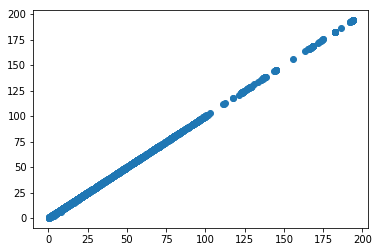

In [244]:
plt.scatter(mdf[r2_colnames[20] + '_a'], mdf[r2_colnames[20] + '_o'])

In [246]:
[r.replace("L2", "") for r in r2_colnames]

['base',
 'Coding_UCSC',
 'Coding_UCSC.flanking.500',
 'Conserved_LindbladToh',
 'Conserved_LindbladToh.flanking.500',
 'CTCF_Hoffman',
 'CTCF_Hoffman.flanking.500',
 'DGF_ENCODE',
 'DGF_ENCODE.flanking.500',
 'DHS_peaks_Trynka',
 'DHS_Trynka',
 'DHS_Trynka.flanking.500',
 'Enhancer_Andersson',
 'Enhancer_Andersson.flanking.500',
 'Enhancer_Hoffman',
 'Enhancer_Hoffman.flanking.500',
 'FetalDHS_Trynka',
 'FetalDHS_Trynka.flanking.500',
 'H3K27ac_Hnisz',
 'H3K27ac_Hnisz.flanking.500',
 'H3K27ac_PGC2',
 'H3K27ac_PGC2.flanking.500',
 'H3K4me1_peaks_Trynka',
 'H3K4me1_Trynka',
 'H3K4me1_Trynka.flanking.500',
 'H3K4me3_peaks_Trynka',
 'H3K4me3_Trynka',
 'H3K4me3_Trynka.flanking.500',
 'H3K9ac_peaks_Trynka',
 'H3K9ac_Trynka',
 'H3K9ac_Trynka.flanking.500',
 'Intron_UCSC',
 'Intron_UCSC.flanking.500',
 'PromoterFlanking_Hoffman',
 'PromoterFlanking_Hoffman.flanking.500',
 'Promoter_UCSC',
 'Promoter_UCSC.flanking.500',
 'Repressed_Hoffman',
 'Repressed_Hoffman.flanking.500',
 'SuperEnhancer_H

In [252]:
np.matrix([[1,2], [3, 4]]) / np.array([[10., 100.]]).T

matrix([[0.1 , 0.2 ],
        [0.03, 0.04]])

In [253]:
np.array([[10., 100.]]).T.shape

(2, 1)

In [254]:
1./np.array([0.04202266, 0.16544135])

array([23.79668493,  6.0444381 ])

In [94]:
df = pd.read_csv("/Users/szabad/PycharmProjects/modified_ldsr/reference/1000G_Phase3_baselineLD_v2.2_ldscores/baselineLD.22.annot.gz", sep="\t")
df.iloc[:, 4:].std()




base                                                0.000000
Coding_UCSC                                         0.169752
Coding_UCSC.flanking.500                            0.283318
Conserved_LindbladToh                               0.157668
Conserved_LindbladToh.flanking.500                  0.466340
CTCF_Hoffman                                        0.190688
CTCF_Hoffman.flanking.500                           0.266868
DGF_ENCODE                                          0.388030
DGF_ENCODE.flanking.500                             0.499252
DHS_peaks_Trynka                                    0.339933
DHS_Trynka                                          0.396186
DHS_Trynka.flanking.500                             0.482665
Enhancer_Andersson                                  0.080998
Enhancer_Andersson.flanking.500                     0.144549
Enhancer_Hoffman                                    0.237036
Enhancer_Hoffman.flanking.500                       0.260649
FetalDHS_Trynka         

In [8]:
s = df.iloc[:, 4:].sum(axis=0)
s

base                                                141123.000000
Coding_UCSC                                           4191.000000
Coding_UCSC.flanking.500                             12421.000000
Conserved_LindbladToh                                 3600.000000
Conserved_LindbladToh.flanking.500                   45109.000000
CTCF_Hoffman                                          5333.000000
CTCF_Hoffman.flanking.500                            10891.000000
DGF_ENCODE                                           26061.000000
DGF_ENCODE.flanking.500                              66699.000000
DHS_peaks_Trynka                                     18816.000000
DHS_Trynka                                           27516.000000
DHS_Trynka.flanking.500                              52142.000000
Enhancer_Andersson                                     932.000000
Enhancer_Andersson.flanking.500                       3013.000000
Enhancer_Hoffman                                      8433.000000
Enhancer_H

In [9]:
s[s<0]

MAF_Adj_Predicted_Allele_Age    -4203.932213
MAF_Adj_LLD_AFR                -35189.669949
dtype: float64

In [11]:
with open("test.txt", "w") as of:
    s.values.tofile(of)

In [20]:
np.savetxt("test.txt", s.values.reshape(1, -1), delimiter="\t", fmt='%.1f')

In [21]:
dict([(1, 2), (3, 4)])

{1: 2, 3: 4}

In [22]:
np.array([[1,2,3]]).ravel()

array([1, 2, 3])

In [29]:
li = np.array([2, 1, 5, 3, 6, 16, 8, 12])
li[np.argsort(li)[::-1]]

array([16, 12,  8,  6,  5,  3,  2,  1])

In [27]:
import pickle
with open('reg_res.pickle', 'rb') as handle:
    final_reg_results = pickle.load(handle)

In [28]:
final_reg_results

{'SLDSC-annot': {'hg2': 0.6372618522931327,
  'hg2_se': 0.06002574766939902,
  'Intercept': 1.0105872349637885,
  'Annotations': {'Names': ['base',
    'Coding_UCSC',
    'Coding_UCSC.flanking.500',
    'Conserved_LindbladToh',
    'Conserved_LindbladToh.flanking.500',
    'CTCF_Hoffman',
    'CTCF_Hoffman.flanking.500',
    'DGF_ENCODE',
    'DGF_ENCODE.flanking.500',
    'DHS_peaks_Trynka',
    'DHS_Trynka',
    'DHS_Trynka.flanking.500',
    'Enhancer_Andersson',
    'Enhancer_Andersson.flanking.500',
    'Enhancer_Hoffman',
    'Enhancer_Hoffman.flanking.500',
    'FetalDHS_Trynka',
    'FetalDHS_Trynka.flanking.500',
    'H3K27ac_Hnisz',
    'H3K27ac_Hnisz.flanking.500',
    'H3K27ac_PGC2',
    'H3K27ac_PGC2.flanking.500',
    'H3K4me1_peaks_Trynka',
    'H3K4me1_Trynka',
    'H3K4me1_Trynka.flanking.500',
    'H3K4me3_peaks_Trynka',
    'H3K4me3_Trynka',
    'H3K4me3_Trynka.flanking.500',
    'H3K9ac_peaks_Trynka',
    'H3K9ac_Trynka',
    'H3K9ac_Trynka.flanking.500',
    'Intro

In [2]:
pd.read_csv("/Users/szabad/PycharmProjects/modified_ldsr/data/independent_sumstats/UKB_460K.body_BMIz.sumstats.gz", sep="\t")

,SNP,A1,A2,N,CHISQ,Z
0,rs3094315,G,A,457824,0.2629,-0.5127
1,rs3131972,A,G,457824,0.4339,-0.6587
2,rs3131969,A,G,457824,0.5196,-0.7208
3,rs1048488,C,T,457824,0.3423,-0.5851
4,rs3115850,T,C,457824,0.2992,-0.5470
5,rs2286139,C,T,457824,0.7384,-0.8593
6,rs12562034,G,A,457824,5.8129,-2.4110
7,rs4040617,A,G,457824,0.8105,0.9003
8,rs2980300,T,C,457824,0.8669,-0.9311
9,rs2519031,A,G,457824,0.1721,0.4148


In [36]:
sumstats_dir = "/Users/szabad/comp_589/project/data.broadinstitute.org/alkesgroup/LDSCORE/independent_sumstats/"
glob.glob(os.path.join(sumstats_dir, "PASS*.gz"))

['/Users/szabad/comp_589/project/data.broadinstitute.org/alkesgroup/LDSCORE/independent_sumstats/PASS_LDL.sumstats.gz',
 '/Users/szabad/comp_589/project/data.broadinstitute.org/alkesgroup/LDSCORE/independent_sumstats/PASS_DS.sumstats.gz',
 '/Users/szabad/comp_589/project/data.broadinstitute.org/alkesgroup/LDSCORE/independent_sumstats/PASS_HDL.sumstats.gz',
 '/Users/szabad/comp_589/project/data.broadinstitute.org/alkesgroup/LDSCORE/independent_sumstats/PASS_Type_2_Diabetes.sumstats.gz',
 '/Users/szabad/comp_589/project/data.broadinstitute.org/alkesgroup/LDSCORE/independent_sumstats/PASS_AgeFirstBirth.sumstats.gz',
 '/Users/szabad/comp_589/project/data.broadinstitute.org/alkesgroup/LDSCORE/independent_sumstats/PASS_Rheumatoid_Arthritis.sumstats.gz',
 '/Users/szabad/comp_589/project/data.broadinstitute.org/alkesgroup/LDSCORE/independent_sumstats/PASS_NumberChildrenEverBorn.sumstats.gz',
 '/Users/szabad/comp_589/project/data.broadinstitute.org/alkesgroup/LDSCORE/independent_sumstats/PASS_U

In [37]:
sumstats_dir = "./data/independent_sumstats/"
glob.glob(os.path.join(sumstats_dir, "PASS*.gz"))

['./data/independent_sumstats/PASS_LDL.sumstats.gz',
 './data/independent_sumstats/PASS_DS.sumstats.gz',
 './data/independent_sumstats/PASS_HDL.sumstats.gz',
 './data/independent_sumstats/PASS_Type_2_Diabetes.sumstats.gz',
 './data/independent_sumstats/PASS_AgeFirstBirth.sumstats.gz',
 './data/independent_sumstats/PASS_Rheumatoid_Arthritis.sumstats.gz',
 './data/independent_sumstats/PASS_NumberChildrenEverBorn.sumstats.gz',
 './data/independent_sumstats/PASS_Ulcerative_Colitis.sumstats.gz',
 './data/independent_sumstats/PASS_Schizophrenia.sumstats.gz',
 './data/independent_sumstats/PASS_BMI1.sumstats.gz',
 './data/independent_sumstats/PASS_Height1.sumstats.gz',
 './data/independent_sumstats/PASS_Years_of_Education2.sumstats.gz',
 './data/independent_sumstats/PASS_Ever_Smoked.sumstats.gz',
 './data/independent_sumstats/PASS_Anorexia.sumstats.gz',
 './data/independent_sumstats/PASS_Coronary_Artery_Disease.sumstats.gz',
 './data/independent_sumstats/PASS_Autism.sumstats.gz',
 './data/inde

In [44]:
454682. == sum([46492.,  44809.,  46574.,  45029.,  44962.,  43384.,  45730.,  45994.,
   46038.,  45670.])

True

In [50]:
pd.read_csv("./data/independent_sumstats/UKB_460K.body_HEIGHTz.sumstats.gz", sep='\t')

,SNP,A1,A2,N,CHISQ,Z
0,rs3094315,G,A,458303,3.7025,-1.9242
1,rs3131972,A,G,458303,3.6001,-1.8974
2,rs3131969,A,G,458303,3.1496,-1.7747
3,rs1048488,C,T,458303,3.8025,-1.9500
4,rs3115850,T,C,458303,3.8770,-1.9690
5,rs2286139,C,T,458303,3.2267,-1.7963
6,rs12562034,G,A,458303,1.7477,-1.3220
7,rs4040617,A,G,458303,3.4913,1.8685
8,rs2980300,T,C,458303,3.0443,-1.7448
9,rs2519031,A,G,458303,0.2659,0.5157


In [46]:
dirpath = "./reference/1000G_Phase3_weights_hm3_no_MHC"

dfs = []
for f in glob.glob(os.path.join(dirpath, "*.gz")):
    dfs.append(pd.read_csv(f, sep="\t"))
    
alkdf = pd.concat(dfs)
alkdf

,CHR,SNP,BP,L2
0,5,rs28538767,12225,10.119
1,5,rs7709758,20747,2.293
2,5,rs2135917,27564,11.012
3,5,rs10055084,36344,11.005
4,5,rs10076494,38139,11.480
5,5,rs10057531,40975,11.457
6,5,rs10039735,48534,11.198
7,5,rs1507712,58298,11.170
8,5,rs1507711,59161,11.549
9,5,rs6869386,81437,19.272


In [47]:
alkdf[['SNP']].to_csv("./reference/w_snplist_no_MHC.snplist.bz2", index=False)

In [51]:
0.001*458303

458.303

In [88]:
import pickle
ldsc_height = pd.read_csv("ldsc/height.results", sep='\t')
with open("regression/UKBB/M_5_50/body_HEIGHTz.pickle", 'rb') as handle:
    final_reg_results = pickle.load(handle)

In [19]:
print(final_reg_results['SLDSC-annot']['hg2'], final_reg_results['SLDSC-annot']['Intercept'])
list(zip(final_reg_results['SLDSC-annot']['OverlapAnnotations']['Names'],
    final_reg_results['SLDSC-annot']['OverlapAnnotations']['hg2']))

0.6740050075196229 1.4624702396331986


[('base', 1.0000000000000266),
 ('Coding_UCSC', 0.12435608570191788),
 ('Coding_UCSC.flanking.500', 0.06191529070581724),
 ('Conserved_LindbladToh', 0.21366780768664173),
 ('Conserved_LindbladToh.flanking.500', 0.4407734352221024),
 ('CTCF_Hoffman', 0.05747749671012009),
 ('CTCF_Hoffman.flanking.500', 0.030717140590259893),
 ('DGF_ENCODE', 0.4663989357909777),
 ('DGF_ENCODE.flanking.500', 0.3787191857352607),
 ('DHS_peaks_Trynka', 0.3294608632375883),
 ('DHS_Trynka', 0.4438961741948762),
 ('DHS_Trynka.flanking.500', 0.3562900063256045),
 ('Enhancer_Andersson', 0.002697673491756626),
 ('Enhancer_Andersson.flanking.500', 0.0368360374722647),
 ('Enhancer_Hoffman', 0.1522191316229401),
 ('Enhancer_Hoffman.flanking.500', 0.0788858286735821),
 ('FetalDHS_Trynka', 0.20709242420306762),
 ('FetalDHS_Trynka.flanking.500', 0.30985208860470537),
 ('H3K27ac_Hnisz', 0.7042637502370449),
 ('H3K27ac_Hnisz.flanking.500', 0.03048853099654031),
 ('H3K27ac_PGC2', 0.5218027239442942),
 ('H3K27ac_PGC2.flank

In [89]:
ldsc_height.sort_values('Prop._h2', ascending=False)

,Category,Prop._SNPs,Prop._h2,Prop._h2_std_error,Enrichment,Enrichment_std_error,Enrichment_p,Coefficient,Coefficient_std_error,Coefficient_z-score
68,Nucleotide_Diversity_10kbL2_0,4.608695e+00,3.843864,0.096838,8.340460e-01,2.101206e-02,3.845438e-13,1.817539e-09,2.365219e-09,0.768444
53,GERP.NSL2_0,1.745316e+00,2.784143,0.139647,1.595208e+00,8.001239e-02,1.684892e-11,-2.155875e-08,9.919196e-09,-2.173437
67,Recomb_Rate_10kbL2_0,1.552424e+00,1.389951,0.125923,8.953418e-01,8.111376e-02,1.910910e-01,-8.082940e-09,2.761956e-09,-2.926527
0,baseL2_0,1.000000e+00,1.000000,0.000000,1.000000e+00,0.000000e+00,NaN,-1.504099e-08,4.923820e-08,-0.305474
23,H3K4me1_TrynkaL2_0,4.234551e-01,0.893507,0.049118,2.110041e+00,1.159926e-01,1.204690e-16,5.882625e-08,3.691842e-08,1.593412
18,H3K27ac_HniszL2_0,3.890438e-01,0.704264,0.026113,1.810243e+00,6.712151e-02,9.767306e-24,1.083164e-08,2.611141e-08,0.414824
79,Conserved_Vertebrate_phastCons46way.flanking.5...,3.775345e-01,0.554043,0.048797,1.467530e+00,1.292512e-01,5.423911e-04,-5.842538e-08,4.710281e-08,-1.240380
81,Conserved_Mammal_phastCons46way.flanking.500L2_0,3.177801e-01,0.547368,0.047217,1.722473e+00,1.485825e-01,5.889148e-06,1.403800e-07,6.385578e-08,2.198392
20,H3K27ac_PGC2L2_0,2.685213e-01,0.521803,0.060446,1.943245e+00,2.251063e-01,3.436026e-05,-5.123415e-08,5.351044e-08,-0.957461
29,H3K9ac_TrynkaL2_0,1.253023e-01,0.502943,0.040726,4.013833e+00,3.250196e-01,6.082086e-16,2.324776e-07,6.566626e-08,3.540289


In [20]:
pd.DataFrame({"Names":final_reg_results['SLDSC-annot']['OverlapAnnotations']['Names'],
    "hg2": final_reg_results['SLDSC-annot']['OverlapAnnotations']['hg2']})

,Names,hg2
0,base,1.000000
1,Coding_UCSC,0.124356
2,Coding_UCSC.flanking.500,0.061915
3,Conserved_LindbladToh,0.213668
4,Conserved_LindbladToh.flanking.500,0.440773
5,CTCF_Hoffman,0.057477
6,CTCF_Hoffman.flanking.500,0.030717
7,DGF_ENCODE,0.466399
8,DGF_ENCODE.flanking.500,0.378719
9,DHS_peaks_Trynka,0.329461


In [45]:
x = np.array([1, 2, 5, 10,3, 9])
y = [2, 3]
np.argwhere(np.isin(x, y)).ravel()

array([1, 4])

In [40]:
x[None]

array([[ 1,  2,  5, 10,  9]])

In [41]:
np.argwhere(np.isin(x, y))

array([[1]])

In [46]:
x

array([ 1,  2,  5, 10,  3,  9])

In [50]:
x[np.argwhere(np.isin(x, y))].ravel()

array([2, 3])

In [74]:
annotations = np.array(final_reg_results['SLDSC-annot']['OverlapAnnotations']['Names'])

binary_annots = ['Coding_UCSC', 'Human_Promoter_Villar', 'synonymous', 'CTCF_Hoffman']

metric = 'enrichment'

if 'coefficient' not in metric:
    keep_index = np.argwhere(np.isin(annotations, binary_annots)).ravel()
else:
    keep_index = None

annotations = annotations[keep_index].ravel()

sorted_idx = np.argsort(np.abs(final_reg_results['SLDSC-annot']['OverlapAnnotations'][metric][keep_index].ravel()))[::-1]
print(sorted_idx)
annotations = annotations[sorted_idx]

final_reg_results['SLDSC-annot']['OverlapAnnotations'][metric][keep_index].ravel()[sorted_idx].clip(min=0.)

[2 0 3 1]


array([9.87286602, 8.72114916, 7.06591674, 2.41353379])

In [75]:
sorted_idx

array([2, 0, 3, 1])

In [85]:
final_reg_results['SLDSC-annot']['Annotations'][metric].ravel()[keep_index][sorted_idx]

array([ 78.23599324, -65.75292437, -37.5200239 ,   4.03190993])

In [97]:
pd.to_numeric(['NA', 3.495838847270772e-07], errors='coerce')

array([           nan, 3.49583885e-07])

In [98]:
np.log10(np.nan)

nan

In [101]:
-np.log10(np.nan_to_num(pd.to_numeric(['NA', 3.495838847270772e-07],
                                                                           errors='coerce'),
                                                             nan=1.))

TypeError: nan_to_num() got an unexpected keyword argument 'nan'

In [3]:
glob.glob("/Users/szabad/Downloads/2714.ldsc.imputed_v3.female.tsv")

['/Users/szabad/Downloads/2714.ldsc.imputed_v3.female.tsv']

In [47]:
pd.read_csv("/Users/szabad/Downloads/age_at_menarche.sumstats.gz", sep="\t")

,SNP,A1,A2,N,Z
0,rs1000000,A,G,188644,0.609710
1,rs10000010,C,T,188644,-0.941940
2,rs1000002,T,C,188644,-0.000416
3,rs10000023,T,G,188644,1.790000
4,rs1000003,G,A,188644,1.165900
5,rs10000033,C,T,188644,0.452540
6,rs10000037,A,G,188644,-0.718120
7,rs10000041,T,G,188644,-0.629130
8,rs1000007,C,T,188644,-0.666670
9,rs10000075,T,C,188644,-0.276470


In [7]:
pd.read_csv("reference/baselineLD_v1.1/baselineLD.1.annot.gz", sep="\s+")

,CHR,BP,SNP,CM,base,Coding_UCSC,Coding_UCSC.extend.500,Conserved_LindbladToh,Conserved_LindbladToh.extend.500,CTCF_Hoffman,...,MAFbin7,MAFbin8,MAFbin9,MAFbin10,MAF_Adj_Predicted_Allele_Age,MAF_Adj_LLD_AFR,Recomb_Rate_10kb,Nucleotide_Diversity_10kb,Backgrd_Selection_Stat,CpG_Content_50kb
0,1,11008,rs575272151,0.000,1,0,0,0,0,0,...,0,0,0,0,0.0,-1.027613,0.0000,1.800000,0.006,0.014240
1,1,11012,rs544419019,0.000,1,0,0,0,0,0,...,0,0,0,0,0.0,-1.027613,0.0000,1.799280,0.006,0.014239
2,1,13110,rs540538026,0.000,1,0,0,0,0,0,...,0,0,0,0,0.0,-2.419890,0.0000,1.487357,0.006,0.014049
3,1,13116,rs62635286,0.000,1,0,0,0,0,0,...,0,0,0,0,0.0,-2.102531,0.0000,1.486620,0.006,0.014048
4,1,13118,rs200579949,0.000,1,0,0,0,0,0,...,0,0,0,0,0.0,-2.102531,0.0000,1.486375,0.006,0.014047
5,1,13273,rs531730856,0.000,1,0,0,0,0,0,...,0,0,0,0,0.0,-3.007333,0.0000,1.467591,0.006,0.014044
6,1,13550,rs554008981,0.000,1,0,0,0,0,0,...,0,0,0,0,0.0,0.000000,0.0000,1.435178,0.006,0.014008
7,1,14464,rs546169444,0.000,1,0,0,0,0,1,...,0,0,0,0,0.0,-1.986377,0.0000,1.337693,0.006,0.013955
8,1,14599,rs531646671,0.000,1,0,0,0,0,1,...,0,0,0,0,0.0,-1.817126,0.0000,1.324406,0.006,0.013958
9,1,14604,rs541940975,0.000,1,0,0,0,0,1,...,0,0,0,0,0.0,-1.817126,0.0000,1.323919,0.006,0.013956


In [11]:
from scipy import stats
-np.log10(stats.norm.pdf(-15.546))

52.878826021966056

In [13]:
np.append([np.nan], np.random.normal(size=3))

array([        nan,  1.45197451,  0.85360312, -1.33727927])

In [18]:
stats.ttest_1samp(np.array([1., 5., 0., 3.]),0.0, axis=1)

IndexError: tuple index out of range

In [31]:
df = pd.read_csv("/Users/szabad/Downloads/ukb31063_h2_z4.02Oct2019.tsv", sep="\t")
dict(zip(list(df.columns), list(df.loc[df['phenotype'] == '2714',].values.ravel())))

{'phenotype': '2714',
 'sex': 'female',
 'dilute': nan,
 'gwas_file': '2714.gwas.imputed_v3.female.tsv.bgz',
 'variable_type': 'ordinal',
 'n_missing': 5530,
 'source': 'phesant',
 'description': 'Age when periods started (menarche)',
 'n': 188644,
 'n_cases': nan,
 'n_controls': nan,
 'mean_chi2': 1.76699707022547,
 'lambdaGC': 1.50638127060892,
 'intercept': 1.02806949708148,
 'intercept_se': 0.0183591454332741,
 'intercept_z': 1.52891087352059,
 'intercept_p': 0.0631432701382827,
 'ratio': 0.0365966157774595,
 'ratio_se': 0.0239363957777273,
 'h2_observed': 0.20898441582139102,
 'h2_observed_se': 0.0120533166553598,
 'h2_liability': 0.20898441582139102,
 'h2_liability_se': 0.0120533166553598,
 'h2_z': 17.3383328254686,
 'h2_p': 1.2082234173425399e-67,
 'base..Prop_SNPs': 1,
 'base..Prop_h2': 0.999999999999958,
 'base..Prop_h2_se': 1.28898123694683e-08,
 'base..Enrichment': 0.999999999999958,
 'base..Enrichment_se': 1.28898123694683e-08,
 'base..Enrichment_p': nan,
 'base..Coefficien

In [59]:
np.log10(7.482721846046359e-06)

-5.125940398432238

In [56]:
1.28898123694683e-08 / 12

1.074151030789025e-09

In [58]:
-1.7440553573359583e-08 / 5.808562440643745e-09

-3.002559368446197

In [6]:
def read_merge_ldscore_files(ldf, wldf, ld_col):

    ref_df = pd.read_csv(ldf, sep="\t")
    ref_df = ref_df.sort_values(by='BP')
    M = pd.read_csv(ldf.replace(".ldscore.gz", count_file), header=None, sep="\t").values

    ld_dfs = {}

    for ldc in ld_col:

        m_ref_df = ref_df[['SNP'] + [c for c in ref_df.columns if c[-len(ldc):] == ldc]]

        if keep_annotations is not None:
            keep_idx = np.array([i for i, c in enumerate(m_ref_df.columns)
                                 if c == 'SNP' or c[:-len(ldc)] in keep_annotations])
            m_ref_df = m_ref_df.iloc[:, keep_idx]

        # The LD Score Weights file:
        w_df = pd.read_csv(wldf, sep="\t")

        try:
            w_df = w_df[['SNP', 'base' + ldc]]
            w_df = w_df.rename(columns={'base' + ldc: 'w_base' + ldc})
        except Exception as e:
            w_df = w_df[['SNP', 'L2']]
            w_df = w_df.rename(columns={'L2': 'w_base' + ldc})

        ld_dfs[ldc] = pd.merge(m_ref_df, w_df, on='SNP')

    if keep_annotations is not None:
        M = M[:, keep_idx[1:] - 1]

    return ld_dfs, M


def read_ld_scores(ref_ld_file_struct, w_ld_file_struct, ld_col):

    args = []

    if isinstance(ld_col, list):
        ld_col = ld_col
    else:
        ld_col = [ld_col]

    for chr_num in range(1, 23):
        args.append((ref_ld_file_struct % chr_num,
                     w_ld_file_struct % chr_num,
                     ld_col))

    pool = Pool(num_procs)
    res = pool.starmap(read_merge_ldscore_files, args)
    pool.close()
    pool.join()

    M = sum([r[1] for r in res])

    final_df = {}

    for ldc in ld_col:
        final_df[ldc] = pd.concat([r[0][ldc] for r in res])

    return final_df, M


num_procs = 4
count_file = '.M_5_50'
keep_annotations = None
ld_ref_file = "./reference/1000G_Phase3_baselineLD_v2.2_ldscores/baselineLD.%d.l2.ldscore.gz" 
ld_w_file = "./reference/1000G_Phase3_weights_hm3_no_MHC/weights.hm3_noMHC.%d.l2.ldscore.gz"

ldsc, ldsc_M = read_ld_scores(ld_ref_file, ld_w_file, "L2")
ldc = ldsc['L2']

ss_df = pd.read_csv("/Users/szabad/Downloads/age_at_menarche.sumstats.gz", sep="\t")
ss_df['CHISQ'] = ss_df['Z']**2

nss_df = pd.merge(ldc, ss_df)

188644

In [28]:
ld_score_names = [c for c in ldc.columns if 'L2' in c and c != 'w_baseL2'][:10]
l2 = nss_df[ld_score_names].values
chi2 = nss_df['CHISQ'].values
weights = nss_df['w_baseL2'].values
N = nss_df['N'].values[0]
N

188644

In [29]:
def nll(params, chi2, l2, w):
    e_s = (1. + np.dot(N*l2, params)).clip(min=1e-6)
    snp_ll = chi2/e_s + np.log(chi2) + np.log(2.*e_s) + np.log(np.pi)
    return np.dot(1./weights, 0.5*snp_ll)

init_params = np.random.uniform(size=l2.shape[1])
print(init_params)

res = minimize(nll, init_params, args=(chi2, l2, weights), method='Nelder-Mead')
res

[0.88312118 0.06922141 0.55736739 0.55137978 0.08276024 0.61820063
 0.58776319 0.48946993 0.22891926 0.62941374]


 final_simplex: (array([[ 0.07038383,  0.1426176 ,  0.40137137,  0.60858556,  0.08738945,
         0.79659869,  0.9610617 ,  0.62977215,  0.24459238, -0.36213838],
       [ 0.07038403,  0.14261656,  0.40137087,  0.60857391,  0.08739012,
         0.79659475,  0.96105822,  0.62977235,  0.24459692, -0.36213201],
       [ 0.07038408,  0.14261641,  0.4013708 ,  0.60857213,  0.08739021,
         0.7965941 ,  0.96105769,  0.62977233,  0.24459763, -0.36213094],
       [ 0.07038396,  0.14261609,  0.40137084,  0.60856937,  0.08739054,
         0.79659387,  0.96105667,  0.62977312,  0.24459847, -0.36213051],
       [ 0.07038403,  0.14261601,  0.40137074,  0.60856822,  0.08739056,
         0.79659327,  0.96105638,  0.62977291,  0.24459899, -0.36212956],
       [ 0.0703852 ,  0.14260884,  0.40136775,  0.60848929,  0.08739532,
         0.79656755,  0.96103237,  0.62977529,  0.24462945, -0.36208762],
       [ 0.07038573,  0.142606  ,  0.40136649,  0.60845768,  0.08739714,
         0.79655692,  0.9610

In [19]:
3.29755757e-08 * 5.96115900e+06

0.1965726498642363

In [17]:
ldsc_M

array([[ 5.96115900e+06,  8.50010000e+04,  2.94260000e+05,
         1.47065000e+05,  1.82132100e+06,  1.41963000e+05,
         2.80054000e+05,  8.06918000e+05,  2.40151800e+06,
         6.55488000e+05,  9.88019000e+05,  1.96755600e+06,
         2.57150000e+04,  8.76820000e+04,  2.49911000e+05,
         2.85433000e+05,  4.98847000e+05,  1.18935500e+06,
         2.31915200e+06,  1.87272000e+05,  1.60069800e+06,
         3.97153000e+05,  1.00666200e+06,  2.52428300e+06,
         1.08639500e+06,  2.46604000e+05,  7.92159000e+05,
         7.28182000e+05,  2.27635000e+05,  7.46947000e+05,
         6.22761000e+05,  2.30965900e+06,  5.56790000e+04,
         4.93400000e+04,  1.48357000e+05,  2.76212000e+05,
         6.31280000e+04,  2.74224100e+06,  1.54058700e+06,
         9.96746000e+05,  1.89170000e+04,  7.80742000e+05,
         1.25226000e+06,  2.05774800e+06,  2.48407800e+06,
         1.06150000e+05,  9.85480000e+04,  6.65750000e+04,
         9.10580000e+04,  3.25490000e+04,  1.27493000e+0

In [30]:
import pickle
with open("/Users/szabad/PycharmProjects/modified_ldsr/regression/UKBB/M_5_50/age_at_menarche.pickle", "rb") as handle:
    frr = pickle.load(handle)

frr

{'SLDSC-annot': {'hg2': 0.20552600287471998,
  'hg2_se': 0.010727507551486375,
  'Intercept': 1.0298761659535998,
  'Intercept_se': 0.01777652064472534,
  'OverlapAnnotations': {'Names': ['base',
    'Coding_UCSC',
    'Coding_UCSC.flanking.500',
    'Conserved_LindbladToh',
    'Conserved_LindbladToh.flanking.500',
    'CTCF_Hoffman',
    'CTCF_Hoffman.flanking.500',
    'DGF_ENCODE',
    'DGF_ENCODE.flanking.500',
    'DHS_peaks_Trynka',
    'DHS_Trynka',
    'DHS_Trynka.flanking.500',
    'Enhancer_Andersson',
    'Enhancer_Andersson.flanking.500',
    'Enhancer_Hoffman',
    'Enhancer_Hoffman.flanking.500',
    'FetalDHS_Trynka',
    'FetalDHS_Trynka.flanking.500',
    'H3K27ac_Hnisz',
    'H3K27ac_Hnisz.flanking.500',
    'H3K27ac_PGC2',
    'H3K27ac_PGC2.flanking.500',
    'H3K4me1_peaks_Trynka',
    'H3K4me1_Trynka',
    'H3K4me1_Trynka.flanking.500',
    'H3K4me3_peaks_Trynka',
    'H3K4me3_Trynka',
    'H3K4me3_Trynka.flanking.500',
    'H3K9ac_peaks_Trynka',
    'H3K9ac_Trynk

In [45]:
(frr['LD2']['hg2'], frr['SLDSC']['hg2'], frr['LD2']['hg2']*1.33) / ldsc_M[0][0]

array([1.99845261e-08, 2.87020198e-08, 2.65794197e-08])

In [32]:
ldsc_M

array([[ 5.96115900e+06,  8.50010000e+04,  2.94260000e+05,
         1.47065000e+05,  1.82132100e+06,  1.41963000e+05,
         2.80054000e+05,  8.06918000e+05,  2.40151800e+06,
         6.55488000e+05,  9.88019000e+05,  1.96755600e+06,
         2.57150000e+04,  8.76820000e+04,  2.49911000e+05,
         2.85433000e+05,  4.98847000e+05,  1.18935500e+06,
         2.31915200e+06,  1.87272000e+05,  1.60069800e+06,
         3.97153000e+05,  1.00666200e+06,  2.52428300e+06,
         1.08639500e+06,  2.46604000e+05,  7.92159000e+05,
         7.28182000e+05,  2.27635000e+05,  7.46947000e+05,
         6.22761000e+05,  2.30965900e+06,  5.56790000e+04,
         4.93400000e+04,  1.48357000e+05,  2.76212000e+05,
         6.31280000e+04,  2.74224100e+06,  1.54058700e+06,
         9.96746000e+05,  1.89170000e+04,  7.80742000e+05,
         1.25226000e+06,  2.05774800e+06,  2.48407800e+06,
         1.06150000e+05,  9.85480000e+04,  6.65750000e+04,
         9.10580000e+04,  3.25490000e+04,  1.27493000e+0

In [ ]:
def total_hsq(coef, annot, var):
    return np.dot(coef, np.dot(var, annot))
    

In [48]:
annotations = [
    'base',
    'MAFbin1',
    'MAFbin2',
    'MAFbin3',
    'MAFbin4',
    'MAFbin5',
    'MAFbin6',
    'MAFbin7',
    'MAFbin8',
    'MAFbin9',
    'MAFbin10'
]

int(np.ceil(len(annotations) / 10))

2

In [61]:
ldsc_M[0][0]*3.64680897e-07*0.3

0.6521762433838868

In [58]:
df = pd.DataFrame({1: [1, 2, 3], 2: [2, 3, 4], 3:[3, 4, 5]})
df.iloc[:, 1:] = df.iloc[:, 1:]*10
df

,1,2,3
0,1,20,30
1,2,30,40
2,3,40,50


In [65]:
annot_file_struct = "./reference/1000G_Phase3_baselineLD_v2.2_ldscores/baselineLD.%d.annot.gz"
frq_file_struct = "./data/1000G_Phase3_frq/1000G.EUR.QC.%d.frq"

maf_normalized_annot = 0.
chr_num = 22
adf = pd.read_csv(annot_file_struct % chr_num, sep="\s+")

if frq_file_struct is not None:
    frq_df = pd.read_csv(frq_file_struct % chr_num, sep="\s+")
    if count_file == '.M_5_50':
        frq_df = frq_df.loc[frq_df['MAF'] > 0.05, ]

    frq_df['MAFVAR'] = 2.*frq_df['MAF']*(1. - frq_df['MAF'])

    adf = adf.loc[adf['SNP'].isin(frq_df['SNP']), ]

    mna_df = pd.merge(frq_df[['SNP', 'MAFVAR']], adf.iloc[:, [2] + list(range(4, len(adf.columns)))])
    maf_normalized_annot += np.dot(mna_df.iloc[:, 2:].values.T, mna_df['MAFVAR'].values)
    
maf_normalized_annot

array([ 2.70652849e+04,  7.08986850e+02,  2.30121385e+03,  5.59756050e+02,
        8.32288823e+03,  1.02159043e+03,  2.14394139e+03,  4.93772749e+03,
        1.28704301e+04,  3.57469882e+03,  5.23143920e+03,  1.01019706e+04,
        1.72403762e+02,  5.96482649e+02,  1.58790622e+03,  1.99303955e+03,
        2.91626167e+03,  6.83885598e+03,  1.58735266e+04,  8.82283014e+02,
        1.07642054e+04,  2.44518315e+03,  6.65803839e+03,  1.56805600e+04,
        4.83012530e+03,  1.62865736e+03,  5.29570095e+03,  4.46275669e+03,
        2.19448668e+03,  6.74211074e+03,  5.11928265e+03,  1.21096336e+04,
        5.08854803e+02,  3.00861711e+02,  9.85360894e+02,  2.43922608e+03,
        5.48396951e+02,  8.11998342e+03,  5.71484940e+03,  8.23587460e+03,
        1.66409936e+02,  5.55786614e+03,  7.09543263e+03,  1.12685168e+04,
        7.63860328e+03,  9.51813783e+02,  9.33697330e+02,  6.35420794e+02,
        1.04191443e+03,  2.93454027e+02,  1.11025942e+03,  1.02829177e+03,
        3.10831289e+03,  

In [69]:
np.array([maf_normalized_annot[:1]])

array([[27065.28487177]])

In [66]:
arr = np.array([1, 2, 3])
np.array([arr])

array([[1, 2, 3]])

In [71]:
with open("/Users/szabad/PycharmProjects/modified_ldsr/regression/UKBB_MAFbins/M_5_50/body_HEIGHTz.pickle", "rb") as handle:
    frr = pickle.load(handle)

frr['LD2-annot']

{'hg2': 0.7413981825234258,
 'hg2_se': 0.034897989887381256,
 'Intercept': 1.8734079742377148,
 'Intercept_se': 0.04703582886457628,
 'Coefficients': array([ 1.48084221e-07, -5.94928657e-06, -1.06600818e-06,  1.61588554e-06,
        -1.15823390e-07,  4.37425933e-07, -6.00817308e-07,  8.48448644e-07,
         2.18843412e-08, -7.71700078e-07,  1.12594329e-06,  2.36646644e-08,
        -1.47876221e-06,  2.51567694e-08,  3.68697635e-07, -3.39741369e-07,
        -1.38479390e-06, -1.90481378e-07,  4.34422111e-08,  2.43190229e-07,
        -2.99860254e-07,  3.41745372e-07,  3.05014407e-07,  1.07963210e-07,
        -3.75872094e-07, -1.33653192e-06,  2.38390151e-07, -3.31565348e-07,
         6.24471023e-07,  8.82150175e-07,  2.98947275e-07, -6.68540338e-08,
         3.45649212e-07, -3.09646336e-06,  1.50084081e-06, -7.62290307e-07,
        -1.50038606e-06,  1.27066755e-08, -2.20925919e-07,  1.00036415e-07,
        -1.89062457e-07,  4.51673999e-07,  3.57539375e-07,  5.76998310e-09,
        -2.7536

In [72]:
frr['SLDSC-annot']['OverlapAnnotations']['tau']

array([-3.13860621e-03, -1.03679466e-01, -2.19841427e-02,  3.52744710e-02,
       -4.32338180e-03,  4.45780301e-03, -1.25495278e-02,  1.96566296e-02,
        2.90246461e-04, -1.52049025e-03,  1.08973582e-02,  2.29651314e-03,
       -4.21294892e-02,  2.83356387e-03,  3.17760133e-03, -1.61185846e-03,
       -2.84413593e-02, -1.55764068e-03, -6.39937795e-04, -1.93758039e-03,
       -3.81030077e-03,  5.54451290e-03, -2.01315123e-04,  6.47673847e-03,
       -9.06732324e-03, -3.01961194e-02,  1.10626271e-02,  2.50519425e-03,
       -1.02734901e-02,  2.93237294e-02, -3.87936468e-04, -1.37679811e-03,
       -5.86602428e-03, -6.39578956e-02,  3.34765882e-02, -2.65934151e-02,
       -2.05849912e-02, -3.25178019e-03, -6.11700882e-03,  1.50523656e-03,
        1.35760598e-03,  9.01789719e-03,  5.97404735e-03, -1.03979709e-03,
       -5.74767828e-03,  1.70248265e-02,  2.67460742e-02,  1.46382240e-01,
        1.71832633e-03,  5.18040565e-02, -1.40836852e-02, -2.87468880e-02,
       -2.41749706e-02, -

In [ ]:
[[ 6.90143945e-01 -2.47651493e-01 -1.49329207e-01  1.11317191e-01
   4.89838209e-02 -1.64648948e-02 -4.12350044e-02  4.25442349e-01
  -1.58507892e-01 -4.22960607e-01  5.60303715e-01  5.50386857e-02
  -2.75498160e-02 -8.64214424e-04  7.59904246e-02 -5.89237814e-02
  -3.07057163e-01 -1.95449536e-01  1.98601474e-02  5.82239325e-02
  -8.62152268e-02  9.35547593e-02  1.86720378e-01 -3.89326548e-02
  -2.42493017e-01 -1.52380686e-01  8.48791541e-02 -3.05469612e-01
   1.13872709e-01  1.61122050e-01  2.22264904e-01 -9.00640801e-02
  -2.52765315e-02 -4.80086833e-02  1.07398262e-01 -1.42488295e-01
  -4.70794351e-02  1.89534038e-01 -1.34953921e-01  4.19300176e-02
  -2.72176112e-03  3.07844730e-01  2.64201986e-01  4.87649394e-03
  -4.89077715e-01  1.17921688e-01  2.00335087e-02  2.75876538e-01
   8.21324369e-03  3.00390638e-02 -1.82564194e-03 -7.06049720e-02
  -1.92989271e-01 -2.66952256e-01 -4.70082896e-02  1.95052426e-02
   4.66885931e-02 -8.45381244e-03  3.68044499e-02  4.24227220e-02
   3.60938210e-02  2.62755176e-02 -1.21670653e-01 -3.14608776e-02
  -2.29366465e-02 -7.53573721e-04 -4.36088871e-04 -1.59799285e-01
  -3.21863883e-01  1.08703662e-01  1.57870458e-02  3.02442305e-04
  -5.21271771e-02  7.81877505e-02  4.84377325e-02  2.36252172e-02
   1.10103564e-01  1.77162027e-01 -5.48135224e-02  3.43833025e-01
  -4.12232036e-02 -1.00070381e-01  2.24454348e-01  3.71732684e-01
   3.87284475e-02 -4.72915171e-02 -5.34487031e-02 -4.49516134e-02
  -1.03677641e-01  1.65309289e-02  5.84670041e-02  2.52389713e-02
   2.21951231e-02 -1.90905819e-02  2.41849562e-02  1.48544009e-02
   8.69740484e-03]]

In [ ]:
[[-2.57828811e-01 -1.21445295e-01 -8.91465774e-02  7.14880986e-02
  -1.08511057e-01  8.72087279e-03 -4.84320746e-02  2.18575946e-01
   9.60542730e-03 -1.37344823e-02  1.48371481e-01  6.22672874e-02
  -1.49292033e-02  3.42379192e-03  1.09433097e-02 -6.34008373e-03
  -1.95515693e-01 -2.55295226e-02 -2.04517692e-02 -5.00030491e-03
  -8.40490038e-02  3.03448612e-02 -2.79269808e-03  2.25298507e-01
  -1.35747164e-01 -1.02616019e-01  1.20763181e-01  2.51388412e-02
  -3.22270797e-02  3.01837295e-01 -3.32924629e-03 -4.38209750e-02
  -4.50089822e-03 -4.34867769e-02  6.84404951e-02 -1.01223317e-01
  -1.79075687e-02 -1.22882690e-01 -1.29864140e-01  2.06753642e-02
   3.53907622e-04  9.70234542e-02  1.03092502e-01 -2.94852418e-02
  -1.96753102e-01  2.49038564e-02  3.63221686e-02  1.34296122e-01
   2.15619315e-03  2.32362119e-02 -2.47438093e-02 -4.93684466e-02
  -1.34682129e-01 -2.23629399e-01 -2.47565631e-02  2.16673891e-02
   3.83473716e-02  5.74725618e-02  2.26987275e-02  6.35017889e-02
   9.07532891e-02  1.27098949e-01  8.56729425e-02  1.21155426e-01
   1.23601318e-01 -5.13914872e-07 -4.79602304e-04 -9.41129478e-02
   1.41481344e-01  1.48177025e-01  9.18097674e-02  9.81529610e-15
   2.84178963e-02  6.34619060e-02  3.45491332e-02  9.15578436e-03
   2.45872377e-02  5.44187710e-02 -3.12144639e-02 -2.02008890e-01
   8.48838768e-02  3.82263459e-01  9.54227912e-02  1.11173512e-01
   4.11713905e-02 -5.05399738e-02 -2.18734479e-02 -4.95166154e-02
  -1.05216225e-01  1.20358809e-02  4.87042533e-02  2.71483717e-02
   3.65111012e-02  5.39491311e-04  2.62800277e-02  3.49112557e-03
   4.76073655e-03]]


In [73]:
def read_merge_ldscore_files(ldf, wldf, ld_col):

    ref_df = pd.read_csv(ldf, sep="\t")
    ref_df = ref_df.sort_values(by='BP')
    M = pd.read_csv(ldf.replace(".ldscore.gz", count_file), header=None, sep="\t").values

    ld_dfs = {}

    for ldc in ld_col:

        m_ref_df = ref_df[['SNP'] + [c for c in ref_df.columns if c[-len(ldc):] == ldc]]

        if ldc == 'LD2':
            mu = np.mean(2. * ref_df['MAF'] * (1. - ref_df['MAF']))
            m_ref_df.iloc[:, 1:] = m_ref_df.iloc[:, 1:]*mu

        if keep_annotations is not None:
            keep_idx = np.array([i for i, c in enumerate(m_ref_df.columns)
                                 if c == 'SNP' or c[:-len(ldc)] in keep_annotations])
            m_ref_df = m_ref_df.iloc[:, keep_idx]

        # The LD Score Weights file:
        w_df = pd.read_csv(wldf, sep="\t")

        try:
            w_df = w_df[['SNP', 'base' + ldc]]
            w_df = w_df.rename(columns={'base' + ldc: 'w_base' + ldc})
        except Exception as e:
            w_df = w_df[['SNP', 'L2']]
            w_df = w_df.rename(columns={'L2': 'w_base' + ldc})

        ld_dfs[ldc] = pd.merge(m_ref_df, w_df, on='SNP')

    if keep_annotations is not None:
        M = M[:, keep_idx[1:] - 1]

    return ld_dfs, M


def read_ld_scores(ref_ld_file_struct, w_ld_file_struct, ld_col):

    args = []

    if isinstance(ld_col, list):
        ld_col = ld_col
    else:
        ld_col = [ld_col]

    for chr_num in range(1, 23):
        args.append((ref_ld_file_struct % chr_num,
                     w_ld_file_struct % chr_num,
                     ld_col))

    pool = Pool(num_procs)
    res = pool.starmap(read_merge_ldscore_files, args)
    pool.close()
    pool.join()

    M = sum([r[1] for r in res])

    final_df = {}

    for ldc in ld_col:
        final_df[ldc] = pd.concat([r[0][ldc] for r in res])

    return final_df, M

def get_alkes_ldscores():

    ld_ref_file = "./reference/1000G_Phase3_baselineLD_v2.2_ldscores/baselineLD.%d.l2.ldscore.gz" #"./reference/baselineLD_v1.1/baselineLD.%d.l2.ldscore.gz" #
    ld_w_file = "./reference/1000G_Phase3_weights_hm3_no_MHC/weights.hm3_noMHC.%d.l2.ldscore.gz"

    ldsc, ldsc_M = read_ld_scores(ld_ref_file, ld_w_file, "L2")
    ldsc = ldsc['L2']

    ld_scores = []

    for w_annot in (True, False):
        if w_annot:
            c_ldsc = ldsc
            c_ldsc_M = ldsc_M
        else:
            c_ldsc = ldsc[['SNP', 'baseL2', 'w_baseL2']]
            c_ldsc_M= ldsc_M[:1, :1]

        ld_scores.append({
            'Name': 'SLDSC' + ['', '-annot'][w_annot],
            'Annotation': w_annot,
            'LDScores': c_ldsc,
            'Counts': c_ldsc_M,
            'WeightCol': 'w_baseL2',
            'Symbol': 'L2'
        })

    return ld_scores


alkes_ld_scores = get_alkes_ldscores()
alkes_ld_scores.head()

AttributeError: 'list' object has no attribute 'head'

In [76]:
alkes_ld_scores[1]['LDScores']

,SNP,baseL2,w_baseL2
0,rs3094315,80.826,7.070
1,rs3131972,80.939,7.089
2,rs3131969,90.291,6.981
3,rs1048488,80.679,7.100
4,rs3115850,80.483,7.047
5,rs2286139,90.208,6.933
6,rs12562034,32.878,1.353
7,rs4040617,85.659,6.512
8,rs2980300,89.525,6.887
9,rs2519031,13.350,1.620


In [77]:
frq_file_struct = "./data/1000G_Phase3_frq/1000G.EUR.QC.%d.frq"
frq_dfs = []

for chr_num in range(1, 23):

    frq_dfs.append(pd.read_csv(frq_file_struct % chr_num, sep="\s+"))
    
frq_df = pd.concat(frq_dfs)
frq_df.head()

,CHR,SNP,A1,A2,MAF,NCHROBS
0,1,rs575272151,G,C,0.08896,978
1,1,rs544419019,G,C,0.08896,978
2,1,rs540538026,A,G,0.05419,978
3,1,rs62635286,G,T,0.18810,978
4,1,rs200579949,G,A,0.18810,978


In [78]:
frq_df_m5_50 = frq_df.loc[frq_df['MAF'] < 0.05,]
pd.merge(frq_df_m5_50, alkes_ld_scores[1]['LDScores'], on='SNP')

,CHR,SNP,A1,A2,MAF,NCHROBS,baseL2,w_baseL2
0,1,rs2519031,G,A,0.008180,978,13.350,1.620
1,1,rs13302982,A,G,0.023520,978,50.493,3.002
2,1,rs4040604,G,T,0.023520,978,50.493,3.002
3,1,rs7523549,T,C,0.039880,978,32.408,5.411
4,1,rs3748592,A,G,0.047030,978,53.651,6.188
5,1,rs3748593,A,C,0.037830,978,34.783,5.650
6,1,rs2340582,A,G,0.047030,978,53.651,6.188
7,1,rs4246503,A,G,0.047030,978,53.651,6.188
8,1,rs3748594,A,G,0.038850,978,34.133,5.584
9,1,rs17160698,C,T,0.005112,978,78.359,2.686


In [81]:
entrez = pd.read_csv("/Users/szabad/PycharmProjects/GSR/data/msigdb/entrez2ensembl_without_hla.txt", sep="\s+")

entrez.head()

,ensembl_gene_id,entrezgene
0,ENSG00000152380,167555
1,ENSG00000198780,26049
2,ENSG00000141448,2627
3,ENSG00000018408,25937
4,ENSG00000174326,162515


In [82]:
len(entrez)

20672

In [88]:
pd.read_csv("/Users/szabad/PycharmProjects/GSR/data/a_hat.csv", index_col=0).T

,0,1,2,3,4,5,6,7,8,9,...,479,480,481,482,483,484,485,486,487,488
ENSG00000163382,-0.519700,-0.519700,0.017207,-0.519700,0.017207,-0.519700,-0.519700,-0.519700,-0.519700,-0.519700,...,-0.519700,-0.519700,-0.457142,0.017207,2.769968,0.017207,0.017207,0.017207,0.017207,-0.519700
ENSG00000188375,-0.247848,0.106663,0.071905,-0.195707,0.696874,0.775075,0.204566,0.333717,0.239082,-0.016726,...,-1.906925,0.654334,0.694679,0.555463,0.003803,-1.134362,-2.103912,-0.081380,0.327823,0.315834
ENSG00000152223,-0.774213,0.469725,-0.781985,0.451346,0.536174,0.453335,0.495750,0.514129,0.616260,0.573846,...,0.049814,0.493760,0.493760,0.452218,-1.277790,0.455325,0.469725,-1.725406,0.458189,0.456199
ENSG00000135426,-0.210072,-0.637477,0.036322,-0.639694,0.294699,1.526090,-0.635382,0.953443,1.432246,1.347389,...,1.442374,0.735364,-0.687145,-0.434657,1.166291,-0.031500,-0.857273,0.787712,-1.398244,0.698885
ENSG00000114405,0.613318,1.547044,0.323149,-0.279267,1.448551,2.241207,-0.768274,0.959109,-1.386373,1.485042,...,0.640789,0.679797,-0.488189,0.623917,-0.208393,1.427733,0.743573,-1.215355,0.063002,1.000306
ENSG00000181381,-2.160796,-1.396508,1.184543,-2.169963,1.130382,0.549269,0.173472,-1.693839,-0.351122,1.264777,...,-0.660524,-0.698587,-0.117593,-0.737681,1.287077,1.040562,-0.294726,0.931162,-1.024535,0.861710
ENSG00000102890,0.062644,0.380041,0.380041,0.380041,0.167681,0.380041,0.380041,0.592400,0.592400,0.380041,...,0.167681,0.380041,0.167681,-1.464383,0.592400,-3.885552,0.380041,0.380041,0.380041,0.380041
ENSG00000140575,0.178810,0.181593,-0.227890,-0.778090,1.302018,1.194121,0.082572,1.151423,1.013034,-0.757388,...,1.172314,-0.055818,1.015451,0.295393,-1.078242,-1.991068,0.198785,0.962939,1.047277,-1.742795
ENSG00000143578,1.517620,-1.454491,-1.454491,-0.355578,0.031565,0.031565,0.031565,0.031565,-1.454491,-1.454491,...,0.031565,0.031565,1.517620,1.517620,0.031565,1.517620,0.031565,-1.454491,-1.454491,0.031565
ENSG00000102878,0.152900,0.152900,-0.179569,-0.179569,-0.512039,-0.179569,-0.179569,0.152900,0.152900,-0.179569,...,-0.512039,-0.179569,-0.179569,-1.422480,0.152900,-2.493988,0.152900,0.152900,-0.179569,-0.179569


In [89]:
a_hat = pd.read_csv("/Users/szabad/PycharmProjects/GSR/data/a_hat.csv", index_col=0).T
gene_annot = pd.read_csv("/Users/szabad/PycharmProjects/GSR/data/annotations/gene_annot.csv.gz", index_col=0)
gene_annot.set_index('ensembl_gene_id', inplace=True)
gene_annot = gene_annot.loc[a_hat.index]
gene_annot.head()

,entrezgene,base,KEGG_GLYCOLYSIS_GLUCONEOGENESIS,KEGG_CITRATE_CYCLE_TCA_CYCLE,KEGG_PENTOSE_PHOSPHATE_PATHWAY,KEGG_PENTOSE_AND_GLUCURONATE_INTERCONVERSIONS,KEGG_FRUCTOSE_AND_MANNOSE_METABOLISM,KEGG_GALACTOSE_METABOLISM,KEGG_ASCORBATE_AND_ALDARATE_METABOLISM,KEGG_FATTY_ACID_METABOLISM,...,BIOCARTA_CREB_PATHWAY,BIOCARTA_CARM1_PATHWAY,BIOCARTA_TFF_PATHWAY,BIOCARTA_TRKA_PATHWAY,BIOCARTA_ARF_PATHWAY,BIOCARTA_UCALPAIN_PATHWAY,BIOCARTA_VEGF_PATHWAY,BIOCARTA_VITCB_PATHWAY,BIOCARTA_WNT_PATHWAY,BIOCARTA_ACTINY_PATHWAY
ENSG00000163382,128240,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000188375,440093,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000152223,57724,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000135426,9840,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000114405,57415,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [90]:
a_hat.head()

,0,1,2,3,4,5,6,7,8,9,...,479,480,481,482,483,484,485,486,487,488
ENSG00000163382,-0.519700,-0.519700,0.017207,-0.519700,0.017207,-0.519700,-0.519700,-0.519700,-0.519700,-0.519700,...,-0.519700,-0.519700,-0.457142,0.017207,2.769968,0.017207,0.017207,0.017207,0.017207,-0.519700
ENSG00000188375,-0.247848,0.106663,0.071905,-0.195707,0.696874,0.775075,0.204566,0.333717,0.239082,-0.016726,...,-1.906925,0.654334,0.694679,0.555463,0.003803,-1.134362,-2.103912,-0.081380,0.327823,0.315834
ENSG00000152223,-0.774213,0.469725,-0.781985,0.451346,0.536174,0.453335,0.495750,0.514129,0.616260,0.573846,...,0.049814,0.493760,0.493760,0.452218,-1.277790,0.455325,0.469725,-1.725406,0.458189,0.456199
ENSG00000135426,-0.210072,-0.637477,0.036322,-0.639694,0.294699,1.526090,-0.635382,0.953443,1.432246,1.347389,...,1.442374,0.735364,-0.687145,-0.434657,1.166291,-0.031500,-0.857273,0.787712,-1.398244,0.698885
ENSG00000114405,0.613318,1.547044,0.323149,-0.279267,1.448551,2.241207,-0.768274,0.959109,-1.386373,1.485042,...,0.640789,0.679797,-0.488189,0.623917,-0.208393,1.427733,0.743573,-1.215355,0.063002,1.000306


In [91]:
print(len(a_hat), len(gene_annot))

4389 4389


In [92]:
gene_annot.tail()

,entrezgene,base,KEGG_GLYCOLYSIS_GLUCONEOGENESIS,KEGG_CITRATE_CYCLE_TCA_CYCLE,KEGG_PENTOSE_PHOSPHATE_PATHWAY,KEGG_PENTOSE_AND_GLUCURONATE_INTERCONVERSIONS,KEGG_FRUCTOSE_AND_MANNOSE_METABOLISM,KEGG_GALACTOSE_METABOLISM,KEGG_ASCORBATE_AND_ALDARATE_METABOLISM,KEGG_FATTY_ACID_METABOLISM,...,BIOCARTA_CREB_PATHWAY,BIOCARTA_CARM1_PATHWAY,BIOCARTA_TFF_PATHWAY,BIOCARTA_TRKA_PATHWAY,BIOCARTA_ARF_PATHWAY,BIOCARTA_UCALPAIN_PATHWAY,BIOCARTA_VEGF_PATHWAY,BIOCARTA_VITCB_PATHWAY,BIOCARTA_WNT_PATHWAY,BIOCARTA_ACTINY_PATHWAY
ENSG00000138829,2201,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000102858,23295,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000198130,26275,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000139725,54509,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000100350,80020,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [93]:
a_hat.tail()

,0,1,2,3,4,5,6,7,8,9,...,479,480,481,482,483,484,485,486,487,488
ENSG00000138829,0.086539,0.250633,0.306256,0.591539,0.289745,0.250633,0.606600,0.284299,0.480120,0.625205,...,0.448885,0.426730,0.342172,0.250633,0.590535,-2.049346,0.430134,0.318457,-1.928157,0.078283
ENSG00000102858,-0.465968,0.371177,-0.876482,0.460198,-0.513995,-0.006032,-2.229231,0.368936,1.114840,2.003650,...,0.221118,-0.427513,1.504634,1.189964,0.585846,0.512065,0.130819,1.104049,0.574711,0.221118
ENSG00000198130,1.693824,1.086046,-1.463133,0.678433,0.170115,0.765702,0.393809,0.247682,0.742017,-0.948756,...,-1.282193,-0.355372,0.015784,0.117877,1.052145,-0.188827,-0.975047,-1.135961,0.362400,0.618404
ENSG00000139725,0.501794,-0.827415,-0.648015,-1.150778,1.029318,-0.648015,-0.563617,1.040769,-1.150778,-1.295061,...,-1.001120,0.896486,0.896486,-1.295061,-0.648015,0.249440,1.543532,2.296705,0.860068,-0.993410
ENSG00000100350,0.440827,-0.637844,0.538446,0.502460,0.542064,0.511924,0.370749,0.508654,0.431400,0.591824,...,0.458514,0.464100,0.200760,0.518844,0.418241,-0.549701,0.253342,-1.952478,0.686810,0.613123


In [97]:
a_hat.loc[['ENSG00000139725']].values.shape

(1, 489)

In [101]:
gene_annot.drop(['entrezgene'], axis=1, inplace=True)

In [102]:
gene_annot

,base,KEGG_GLYCOLYSIS_GLUCONEOGENESIS,KEGG_CITRATE_CYCLE_TCA_CYCLE,KEGG_PENTOSE_PHOSPHATE_PATHWAY,KEGG_PENTOSE_AND_GLUCURONATE_INTERCONVERSIONS,KEGG_FRUCTOSE_AND_MANNOSE_METABOLISM,KEGG_GALACTOSE_METABOLISM,KEGG_ASCORBATE_AND_ALDARATE_METABOLISM,KEGG_FATTY_ACID_METABOLISM,KEGG_STEROID_BIOSYNTHESIS,...,BIOCARTA_CREB_PATHWAY,BIOCARTA_CARM1_PATHWAY,BIOCARTA_TFF_PATHWAY,BIOCARTA_TRKA_PATHWAY,BIOCARTA_ARF_PATHWAY,BIOCARTA_UCALPAIN_PATHWAY,BIOCARTA_VEGF_PATHWAY,BIOCARTA_VITCB_PATHWAY,BIOCARTA_WNT_PATHWAY,BIOCARTA_ACTINY_PATHWAY
ENSG00000163382,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000188375,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000152223,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000135426,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000114405,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000181381,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000102890,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000140575,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000143578,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000102878,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [104]:
df = pd.read_csv("/Users/szabad/PycharmProjects/GSR/data/gencode.v19.genes.v7.patched_contigs_coding_autosome.csv")
df.head()

,seqnames,start,end,width,strand,source,type,score,phase,gene_id,...,gene_type,gene_status,gene_name,transcript_type,transcript_status,transcript_name,level,havana_gene,exon_id,tag
0,1,69091,70008,918,+,HAVANA,gene,NaN,NaN,ENSG00000186092.4,...,protein_coding,KNOWN,OR4F5,protein_coding,KNOWN,OR4F5,2,OTTHUMG00000001094.1,NaN,NaN
1,1,134901,139379,4479,-,ENSEMBL,gene,NaN,NaN,ENSG00000237683.5,...,protein_coding,KNOWN,AL627309.1,protein_coding,KNOWN,AL627309.1,3,NaN,NaN,NaN
2,1,367640,368634,995,+,HAVANA,gene,NaN,NaN,ENSG00000235249.1,...,protein_coding,KNOWN,OR4F29,protein_coding,KNOWN,OR4F29,2,OTTHUMG00000002860.1,NaN,NaN
3,1,621059,622053,995,-,HAVANA,gene,NaN,NaN,ENSG00000185097.2,...,protein_coding,KNOWN,OR4F16,protein_coding,KNOWN,OR4F16,2,OTTHUMG00000002581.1,NaN,NaN
4,1,738532,739137,606,-,ENSEMBL,gene,NaN,NaN,ENSG00000269831.1,...,protein_coding,NOVEL,AL669831.1,protein_coding,NOVEL,AL669831.1,3,NaN,NaN,NaN


In [105]:
len(df)

18924

In [110]:
np.unique(df['gene_id'].str.split('.').str[0])

array(['ENSG00000000419', 'ENSG00000000457', 'ENSG00000000460', ...,
       'ENSG00000273079', 'ENSG00000273173', 'ENSG00000273274'],
      dtype=object)

In [111]:
df['seqnames'].unique()

array(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', 'MT'],
      dtype=object)

In [113]:
df = df.loc[~(df['seqnames'] == 'MT'),]
#df['gene_id'] = df['gene_id'].str.split('.').str[0]

df = df[['seqnames', 'gene_id', 'start']]
df.columns = ['chr', 'gene_id', 'start_BP']
df.to_csv("/Users/szabad/PycharmProjects/GSR/data/gene_to_genomic_location.csv")

In [114]:
df.to_csv("/Users/szabad/PycharmProjects/GSR/data/gene_to_genomic_location.csv", index=False)

In [117]:
df = pd.read_csv("/Users/szabad/PycharmProjects/GSR/data/annotations/gene_annot.csv.gz")
df.iloc[:, 3:].sum() >= 15

base                                               17587
KEGG_GLYCOLYSIS_GLUCONEOGENESIS                       57
KEGG_CITRATE_CYCLE_TCA_CYCLE                          28
KEGG_PENTOSE_PHOSPHATE_PATHWAY                        23
KEGG_PENTOSE_AND_GLUCURONATE_INTERCONVERSIONS         24
KEGG_FRUCTOSE_AND_MANNOSE_METABOLISM                  32
KEGG_GALACTOSE_METABOLISM                             25
KEGG_ASCORBATE_AND_ALDARATE_METABOLISM                21
KEGG_FATTY_ACID_METABOLISM                            40
KEGG_STEROID_BIOSYNTHESIS                             15
KEGG_PRIMARY_BILE_ACID_BIOSYNTHESIS                   16
KEGG_STEROID_HORMONE_BIOSYNTHESIS                     47
KEGG_OXIDATIVE_PHOSPHORYLATION                       111
KEGG_PURINE_METABOLISM                               151
KEGG_PYRIMIDINE_METABOLISM                            92
KEGG_ALANINE_ASPARTATE_AND_GLUTAMATE_METABOLISM       31
KEGG_GLYCINE_SERINE_AND_THREONINE_METABOLISM          28
KEGG_CYSTEINE_AND_METHIONINE_ME

In [125]:
our_file_struct = "/Users/szabad/PycharmProjects/modified_ldsr/output/Phase3_mldscores_MAF/EUR/D2_%d.l2.ldscore.gz"
alkes_file_struct = "/Users/szabad/PycharmProjects/modified_ldsr/reference/1000G_Phase3_baselineLD_v2.2_ldscores/baselineLD.%d.l2.ldscore.gz"

def read_merge_ldscore_files(chr_num):

    print("Chr:", chr_num)
    alkes_df = pd.read_csv(alkes_file_struct % chr_num, sep="\t")
    ref_df = pd.read_csv(our_file_struct % chr_num, sep="\t")
    ref_df = ref_df.sort_values(by='BP')
    
    mu = np.mean(2. * ref_df['MAF'] * (1. - ref_df['MAF']))

    ld2_cols = [c for c in ref_df.columns if c[-len('LD2'):] == 'LD2']
    ref_df.loc[:, ld2_cols] *= mu

    print(len(ref_df))
    ref_df = ref_df.loc[ref_df['SNP'].isin(alkes_df['SNP']),]
    print(len(ref_df))
    ref_df.to_csv("/Users/szabad/PycharmProjects/modified_ldsr/output/Phase3_mldscores_MAF_updated/EUR/D2_%d.l2.ldscore.gz" % chr_num, index=False, sep="\t")

for cn in range(22, 0, -1):
    read_merge_ldscore_files(cn)

Chr: 22
141123
17489
Chr: 21
138712
17040
Chr: 20
221626
31101
Chr: 19
232363
22509
Chr: 18
285156
35513
Chr: 17
269222
32218
Chr: 16
316981
36526
Chr: 15
287001
35839
Chr: 14
324698
39484
Chr: 13
366200
45546
Chr: 12
480110
58543
Chr: 11
493922
60977
Chr: 10
510501
64067
Chr: 9
438106
55464
Chr: 8
549971
64975
Chr: 7
589569
66171
Chr: 6
664016
75358
Chr: 5
633015
75164
Chr: 4
729645
74924
Chr: 3
706350
83036
Chr: 2
839590
99735
Chr: 1
779354
98642


In [126]:
ls = [('baseLD2', 4.803943457741062e-08), ('Coding_UCSCLD2', -1.8511388173486496e-06), ('Coding_UCSC.flanking.500LD2', -3.256942099104281e-07), ('Conserved_LindbladTohLD2', 4.814163579750054e-07), ('Conserved_LindbladToh.flanking.500LD2', -3.418507785549749e-08), ('CTCF_HoffmanLD2', 1.1614256906366308e-07), ('CTCF_Hoffman.flanking.500LD2', -1.7253112165921315e-07), ('DGF_ENCODELD2', 2.674556233656619e-07), ('DGF_ENCODE.flanking.500LD2', 9.153375213340509e-10), ('DHS_peaks_TrynkaLD2', -2.5004221666902296e-07), ('DHS_TrynkaLD2', 3.6343760027515797e-07), ('DHS_Trynka.flanking.500LD2', 1.3174618140814239e-08), ('Enhancer_AnderssonLD2', -4.2895110573721515e-07), ('Enhancer_Andersson.flanking.500LD2', 3.262255021419796e-09), ('Enhancer_HoffmanLD2', 1.1268839556773058e-07), ('Enhancer_Hoffman.flanking.500LD2', -1.0466930857475521e-07), ('FetalDHS_TrynkaLD2', -4.2864966566805284e-07), ('FetalDHS_Trynka.flanking.500LD2', -6.426758698112206e-08), ('H3K27ac_HniszLD2', 1.4660338350245026e-08), ('H3K27ac_Hnisz.flanking.500LD2', 8.070064080416335e-08), ('H3K27ac_PGC2LD2', -9.070921984430739e-08), ('H3K27ac_PGC2.flanking.500LD2', 1.0854055936932399e-07), ('H3K4me1_peaks_TrynkaLD2', 9.088997298596351e-08), ('H3K4me1_TrynkaLD2', 3.6516518699236075e-08), ('H3K4me1_Trynka.flanking.500LD2', -1.1808418834690242e-07), ('H3K4me3_peaks_TrynkaLD2', -4.007076578058601e-07), ('H3K4me3_TrynkaLD2', 7.399559906525939e-08), ('H3K4me3_Trynka.flanking.500LD2', -1.1320059682452774e-07), ('H3K9ac_peaks_TrynkaLD2', 2.1861258355869213e-07), ('H3K9ac_TrynkaLD2', 2.7406320027170664e-07), ('H3K9ac_Trynka.flanking.500LD2', 8.946727612841068e-08), ('Intron_UCSCLD2', -2.1420260455630285e-08), ('Intron_UCSC.flanking.500LD2', 8.485047284168266e-08), ('PromoterFlanking_HoffmanLD2', -9.774325460510251e-07), ('PromoterFlanking_Hoffman.flanking.500LD2', 4.4813144910580494e-07), ('Promoter_UCSCLD2', -2.4058578052667927e-07), ('Promoter_UCSC.flanking.500LD2', -4.7587163008567725e-07), ('Repressed_HoffmanLD2', 2.885052287078014e-09), ('Repressed_Hoffman.flanking.500LD2', -6.633919627409956e-08), ('SuperEnhancer_HniszLD2', 2.8762123570931758e-08), ('SuperEnhancer_Hnisz.flanking.500LD2', -2.356695796011483e-08), ('TFBS_ENCODELD2', 1.4154652248861136e-07), ('TFBS_ENCODE.flanking.500LD2', 1.1250865820413637e-07), ('Transcr_HoffmanLD2', -4.811692625704472e-10), ('Transcr_Hoffman.flanking.500LD2', -8.619355938346606e-08), ('TSS_HoffmanLD2', 4.32329003395528e-07), ('TSS_Hoffman.flanking.500LD2', 3.0824663073821063e-07), ('UTR_3_UCSCLD2', 2.512795947030383e-06), ('UTR_3_UCSC.flanking.500LD2', -1.3912517424039064e-07), ('UTR_5_UCSCLD2', 7.370654156193124e-07), ('UTR_5_UCSC.flanking.500LD2', -8.129484753852252e-08), ('WeakEnhancer_HoffmanLD2', -2.932564008199965e-07), ('WeakEnhancer_Hoffman.flanking.500LD2', -2.8309539089134145e-07), ('GERP.NSLD2', -2.8062065623436976e-08), ('GERP.RSsup4LD2', -4.175921692614745e-07), ('MAFbin1LD2', 4.840127352325055e-09), ('MAFbin2LD2', 1.8154353408478735e-08), ('MAFbin3LD2', 8.613003700434361e-09), ('MAFbin4LD2', -1.427521302665114e-09), ('MAFbin5LD2', 7.228246816127325e-09), ('MAFbin6LD2', 1.9502516519937345e-08), ('MAFbin7LD2', 2.167876591156176e-08), ('MAFbin8LD2', -5.045326772991392e-08), ('MAFbin9LD2', -2.570337907383449e-08), ('MAFbin10LD2', -7.498135746967549e-09), ('MAF_Adj_Predicted_Allele_AgeLD2', -1.0617186177389786e-05), ('MAF_Adj_LLD_AFRLD2', -1.59848873615626e-08), ('Recomb_Rate_10kbLD2', -1.1565492672702212e-08), ('Nucleotide_Diversity_10kbLD2', -2.6084120867596015e-09), ('Backgrd_Selection_StatLD2', 1.8900522137419501e-07), ('CpG_Content_50kbLD2', 1.6670340070012675e-06), ('MAF_Adj_ASMCLD2', -11811781.141591443), ('GTEx_eQTL_MaxCPPLD2', -2.0034420408961284e-07), ('BLUEPRINT_H3K27acQTL_MaxCPPLD2', 4.718741887927568e-07), ('BLUEPRINT_H3K4me1QTL_MaxCPPLD2', 1.719007067236203e-07), ('BLUEPRINT_DNA_methylation_MaxCPPLD2', -1.3391198787093244e-08), ('synonymousLD2', 2.5307527059529598e-06), ('non_synonymousLD2', 4.730845420284244e-06), ('Conserved_Vertebrate_phastCons46wayLD2', -2.2555991073346437e-07), ('Conserved_Vertebrate_phastCons46way.flanking.500LD2', 2.6655380770054608e-08), ('Conserved_Mammal_phastCons46wayLD2', 2.0085361139243272e-07), ('Conserved_Mammal_phastCons46way.flanking.500LD2', 8.12007374859639e-08), ('Conserved_Primate_phastCons46wayLD2', 1.2724796427316899e-06), ('Conserved_Primate_phastCons46way.flanking.500LD2', 1.6685636734090564e-07), ('BivFlnkLD2', 3.7897030112563727e-07), ('BivFlnk.flanking.500LD2', -3.1378433949276026e-07), ('Human_Promoter_VillarLD2', -2.5188663846422233e-07), ('Human_Promoter_Villar.flanking.500LD2', -2.112253964136129e-06), ('Human_Enhancer_VillarLD2', -4.7238520902553544e-07), ('Human_Enhancer_Villar.flanking.500LD2', 4.0052961769818976e-07), ('Ancient_Sequence_Age_Human_PromoterLD2', 1.8196539849677047e-06), ('Ancient_Sequence_Age_Human_Promoter.flanking.500LD2', 7.393270987882713e-07), ('Ancient_Sequence_Age_Human_EnhancerLD2', 1.0970009006509502e-06), ('Ancient_Sequence_Age_Human_Enhancer.flanking.500LD2', -1.4718171266827232e-07), ('Human_Enhancer_Villar_Species_Enhancer_CountLD2', 5.618548418222981e-08), ('Human_Promoter_Villar_ExACLD2', 3.4640034247596e-07), ('Human_Promoter_Villar_ExAC.flanking.500LD2', 2.397445863011675e-06)]

In [130]:
[(l, v) for l, v in ls if abs(v) > 1.]

[('MAF_Adj_ASMCLD2', -11811781.141591443)]

In [143]:
annot_df = pd.read_csv("reference/1000G_Phase3_baselineLD_v2.2_ldscores/baselineLD.22.annot.gz", sep="\s+")
print(annot_df.columns)
list(annot_df.columns).index('MAF_Adj_ASMC')

Index(['CHR', 'BP', 'SNP', 'CM', 'base', 'Coding_UCSC',
       'Coding_UCSC.flanking.500', 'Conserved_LindbladToh',
       'Conserved_LindbladToh.flanking.500', 'CTCF_Hoffman',
       ...
       'Human_Promoter_Villar.flanking.500', 'Human_Enhancer_Villar',
       'Human_Enhancer_Villar.flanking.500',
       'Ancient_Sequence_Age_Human_Promoter',
       'Ancient_Sequence_Age_Human_Promoter.flanking.500',
       'Ancient_Sequence_Age_Human_Enhancer',
       'Ancient_Sequence_Age_Human_Enhancer.flanking.500',
       'Human_Enhancer_Villar_Species_Enhancer_Count',
       'Human_Promoter_Villar_ExAC',
       'Human_Promoter_Villar_ExAC.flanking.500'],
      dtype='object', length=101)


75

In [146]:
alkes_count_file = "reference/1000G_Phase3_baselineLD_v2.2_ldscores/baselineLD.%d.l2.M_5_50"
our_count_file = "output/Phase3_mldscores_MAF_updated/EUR/D2_%d.l2.M_5_50"

alkes_sum = 0.
our_sum = 0. 
for chr_num in range(22, 0, -1):
    alkes_counts = pd.read_csv(alkes_count_file % chr_num, header=None, sep="\t").values
    our_counts = pd.read_csv(our_count_file % chr_num, header=None, sep="\t").values
    print("Chromosome:", chr_num)
    print("Alkes", alkes_counts[0, 71])
    print("Our:", our_counts[0, 71])
    alkes_sum += alkes_counts[0, 71]
    our_sum += our_counts[0, 71]

print("alkes sum:", alkes_sum, "our sum:", our_sum)

Chromosome: 22
Alkes 7635.55338712
Our: 7635.6
Chromosome: 21
Alkes 14254.673966100001
Our: 14254.7
Chromosome: 20
Alkes -992.43599538
Our: -992.4
Chromosome: 19
Alkes 17820.2336473
Our: 17820.2
Chromosome: 18
Alkes 1771.41832301
Our: 1771.4
Chromosome: 17
Alkes -11650.5397386
Our: -11650.5
Chromosome: 16
Alkes 32760.431331800002
Our: 32760.4
Chromosome: 15
Alkes -10114.0435046
Our: -10114.0
Chromosome: 14
Alkes -12385.5743695
Our: -12385.6
Chromosome: 13
Alkes 2840.07898523
Our: 2840.1
Chromosome: 12
Alkes -22676.262682700002
Our: -22676.3
Chromosome: 11
Alkes 9033.8255762
Our: 9033.8
Chromosome: 10
Alkes 12373.4483926
Our: 12373.4
Chromosome: 9
Alkes 4564.44034638
Our: 4564.4
Chromosome: 8
Alkes 31199.733321499996
Our: 31199.7
Chromosome: 7
Alkes 10329.0534536
Our: 10329.1
Chromosome: 6
Alkes 36346.29575319999
Our: 36346.3
Chromosome: 5
Alkes -17715.1977658
Our: -17715.2
Chromosome: 4
Alkes 24710.7598108
Our: 24710.8
Chromosome: 3
Alkes -16411.7758445
Our: -16411.8
Chromosome: 2
Alke

In [150]:
li = [1, 2, 5, 10, 5, 20, -1, 0, 2]
arr = np.array([li])
arr[:, [l < 2 for l in li]] = 1

In [151]:
arr

array([[ 1,  2,  5, 10,  5, 20,  1,  1,  2]])

In [157]:
x = pd.DataFrame({'test': [1, 2, 3, 4]})
test2 = [5, 2, 1, 2]
x['test2'] = test2

In [158]:
x

,test,test2
0,1,5
1,2,2
2,3,1
3,4,2


In [225]:
pred_df = pd.read_csv("./pred_results.csv", index_col=0)

/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


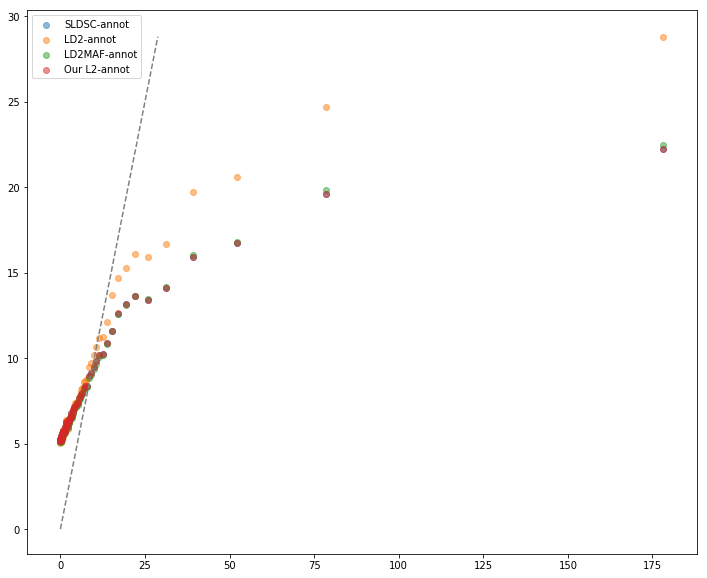

In [227]:

pred_df['binCHISQ'] = pd.qcut(pred_df['CHISQ'], 100,
                              labels=np.quantile(pred_df['CHISQ'], np.linspace(0.0, 1., 100)))

gdf = pred_df.groupby('binCHISQ', as_index=False).mean()

plt.figure(figsize=(12, 10))

max_pchi = 0

for c in pred_df.columns:
    if c not in ['CHISQ', 'SNP', 'binCHISQ'] and '-annot' in c:
        max_pchi = max(max_pchi, np.max(gdf[c]))
        plt.scatter(gdf['CHISQ'], gdf[c], label=c, alpha=0.5)

x = np.linspace(0.0, max_pchi, 1000)
plt.plot(x, x, c='grey', linestyle='--')
#plt.scatter(pred_df['CHISQ'], pred_df['LD2-annot'], label='LD2-annot')
#plt.xlim([0., 30.])
plt.legend()
plt.show()

(array([3.380000e+02, 1.057000e+03, 6.727000e+03, 7.373400e+04,
        1.022377e+06, 5.314800e+04, 1.255900e+04, 5.795000e+03,
        3.216000e+03, 2.090000e+03, 1.348000e+03, 8.590000e+02,
        5.860000e+02, 5.480000e+02, 4.080000e+02, 3.540000e+02,
        2.290000e+02, 2.110000e+02, 1.760000e+02, 1.330000e+02,
        1.140000e+02, 1.260000e+02, 9.200000e+01, 1.070000e+02,
        3.500000e+01, 9.100000e+01, 3.200000e+01, 3.600000e+01,
        2.200000e+01, 5.900000e+01, 4.400000e+01, 4.400000e+01,
        4.200000e+01, 2.100000e+01, 3.900000e+01, 2.700000e+01,
        1.600000e+01, 1.300000e+01, 1.100000e+01, 7.000000e+00,
        1.300000e+01, 1.000000e+01, 1.400000e+01, 7.000000e+00,
        2.700000e+01, 1.300000e+01, 4.000000e+00, 1.700000e+01,
        2.000000e+00, 3.000000e+00, 2.000000e+00, 3.000000e+00,
        1.500000e+01, 6.000000e+00, 9.000000e+00, 2.000000e+00,
        3.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.00

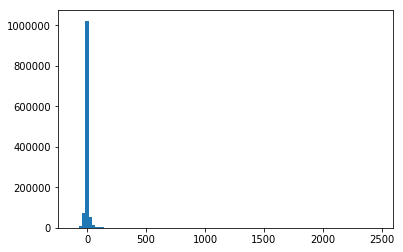

In [177]:
plt.hist(pred_df['CHISQ'] - pred_df['SLDSC-annot'], bins=100)
plt.show()

In [228]:
pred_df.describe()

,CHISQ,SLDSC-annot,SLDSC,LD2-annot,LD2MAF-annot,Our L2-annot,LD2,LD2MAF,Our L2
count,1.186058e+06,1.186058e+06,1.186058e+06,1.186058e+06,1.186058e+06,1.186058e+06,1.186058e+06,1.186058e+06,1.186058e+06
mean,7.000264e+00,7.205623e+00,7.083001e+00,7.578098e+00,7.149695e+00,7.206616e+00,8.017890e+00,6.931969e+00,7.082856e+00
std,2.196676e+01,8.169430e+00,6.414586e+00,1.140331e+01,8.381843e+00,8.173235e+00,8.207047e+00,6.419671e+00,6.414570e+00
min,0.000000e+00,-2.316832e+01,6.175476e-01,-8.143642e+01,-3.145337e+01,-2.307353e+01,-1.179167e+00,-1.681847e+00,6.209320e-01
25%,3.116989e-01,2.675677e+00,3.898193e+00,2.175520e+00,2.619584e+00,2.675632e+00,3.773971e+00,3.815369e+00,3.897872e+00
50%,1.460231e+00,4.869860e+00,5.565168e+00,4.332597e+00,4.739081e+00,4.870084e+00,5.844580e+00,5.415413e+00,5.565420e+00
75%,5.014912e+00,8.849037e+00,8.366918e+00,9.017604e+00,8.745192e+00,8.849225e+00,9.553688e+00,8.147421e+00,8.367173e+00
max,4.581398e+02,1.846906e+02,2.244252e+02,3.297126e+02,1.967785e+02,1.842855e+02,2.340282e+02,2.347832e+02,2.244356e+02


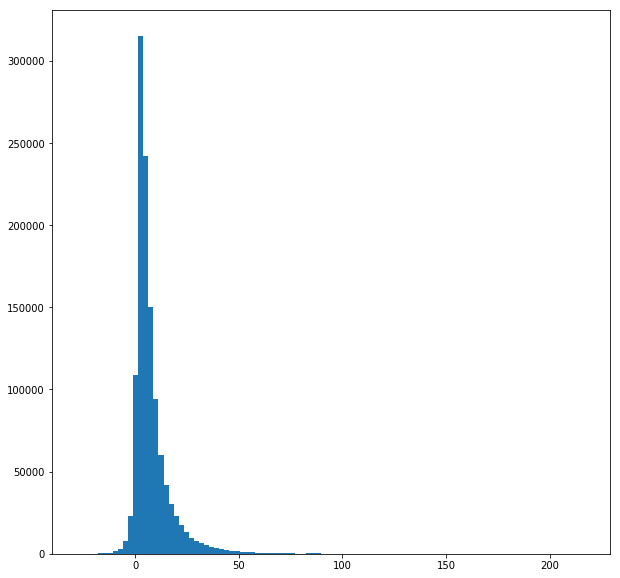

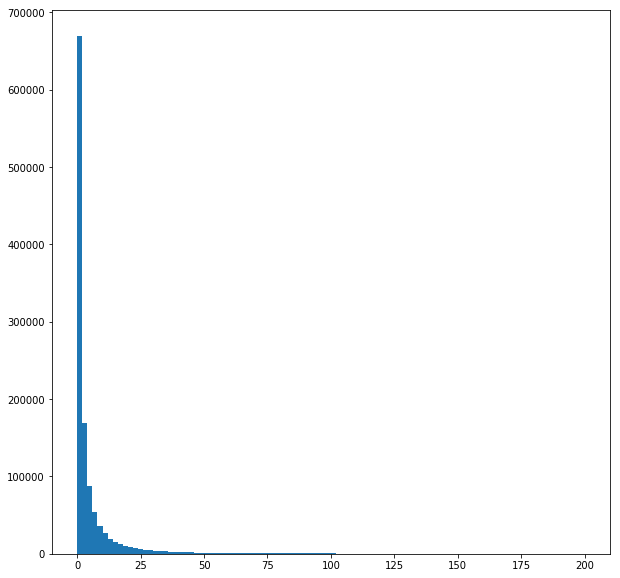

In [202]:
plt.figure(figsize=(10, 10))
plt.hist(pred_df['SLDSC-annot'], bins=100)
plt.show()
plt.figure(figsize=(10, 10))
plt.hist(pred_df.loc[pred_df['CHISQ'] < 200, 'CHISQ'], bins=100)
plt.show()

[]

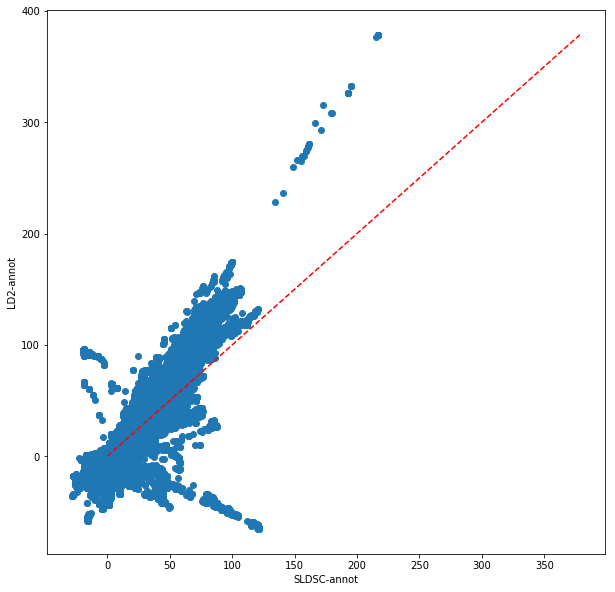

In [209]:
plt.figure(figsize=(10, 10))
plt.scatter(pred_df['SLDSC-annot'], pred_df['LD2-annot'])
x = np.linspace(0.0, max(np.max(pred_df[['LD2-annot', 'SLDSC-annot']])), 1000)
plt.plot(x, x, c='red', linestyle='--')
plt.xlabel('SLDSC-annot')
plt.ylabel('LD2-annot')
plt.plot()

In [205]:
np.max(gdf[['LD2-annot', 'SLDSC-annot']])

LD2-annot      31.856874
SLDSC-annot    25.519549
dtype: float64

In [214]:
(pred_df[[c for c in pred_df.columns if c != 'SNP']] <= 0 ).astype(int).sum(axis=0)

CHISQ              31
SLDSC-annot     57585
SLDSC               0
LD2-annot       87921
LD2MAF-annot    62339
Our L2-annot    57860
LD2                 9
LD2MAF             10
Our L2              0
binCHISQ        11905
dtype: int64

(array([[7., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.

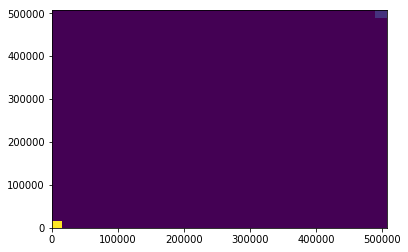

In [223]:
temp_df = pred_df.loc[pred_df['CHISQ'] < 1.,]
#plt.hist2d(temp_df['LD2-annot'], temp_df['SLDSC-annot'], bins=30)

In [224]:
pred_df.loc[pred_df['CHISQ'] < 1.,].describe()

,CHISQ,SLDSC-annot,SLDSC,LD2-annot,LD2MAF-annot,Our L2-annot,LD2,LD2MAF,Our L2
count,506740.000000,506740.000000,506740.000000,506740.000000,506740.000000,506740.000000,506740.000000,506740.000000,506740.000000
mean,0.314282,5.750110,6.801646,5.625331,5.673996,5.749616,7.364665,6.610590,6.802160
std,0.291285,6.813387,5.674703,8.751948,6.948240,6.818521,6.717816,5.602562,5.675124
min,0.000000,-27.904270,1.234124,-58.052579,-31.816836,-28.030231,-0.661831,-0.804742,1.239224
25%,0.054850,2.125251,3.786010,1.842138,2.143033,2.123837,3.541717,3.701433,3.785894
50%,0.224392,4.040258,5.389865,3.426604,3.935537,4.039364,5.425453,5.225203,5.390139
75%,0.525770,7.288633,8.119588,6.913226,7.138349,7.290995,8.821057,7.855268,8.120733
max,0.999800,104.533000,244.554290,161.591297,99.002861,103.213846,210.736442,253.953364,244.598424


In [232]:
np.corrcoef(pred_df['CHISQ'], pred_df['LD2-annot'])

array([[1.        , 0.30447356],
       [0.30447356, 1.        ]])

,SNP,CHISQ,SLDSC-annot,SLDSC,LD2-annot,LD2MAF-annot,Our L2-annot,LD2,LD2MAF,Our L2,binCHISQ
0,rs3094315,3.702546,11.293078,5.196428,8.651833,9.757054,11.297993,4.359547,4.813535,5.198720,3.799381
1,rs3131972,3.600127,11.323612,5.201374,8.673756,9.769776,11.328680,4.356461,4.809885,5.203654,3.613041
2,rs3131969,3.149560,14.132118,5.610661,11.493979,13.122271,14.139511,5.006777,5.448590,5.611551,3.118050
3,rs1048488,3.802500,11.332487,5.189995,8.787111,9.941850,11.337608,4.397268,4.861369,5.192508,3.799381
4,rs3115850,3.876961,11.198303,5.181417,8.651771,9.793497,11.204114,4.371309,4.845629,5.183943,3.996401


In [4]:
from sklearn.decomposition import PCA

annot_df = []

for chr_num in range(1, 23):
    c_annot_df = pd.read_csv("reference/1000G_Phase3_baselineLD_v2.2_ldscores/baselineLD.%d.annot.gz" % chr_num,
                             sep="\s+")
    c_freq = pd.read_csv("./data/1000G_Phase3_frq/1000G.EUR.QC.%d.frq" % chr_num, sep="\s+")
    c_annot_df = pd.merge(c_annot_df, c_freq[['SNP', 'MAF']], on='SNP')
    annot_df.append(c_annot_df)

annot_df = pd.concat(annot_df)
annot_df.head()

,CHR,BP,SNP,CM,base,Coding_UCSC,Coding_UCSC.flanking.500,Conserved_LindbladToh,Conserved_LindbladToh.flanking.500,CTCF_Hoffman,...,Human_Enhancer_Villar,Human_Enhancer_Villar.flanking.500,Ancient_Sequence_Age_Human_Promoter,Ancient_Sequence_Age_Human_Promoter.flanking.500,Ancient_Sequence_Age_Human_Enhancer,Ancient_Sequence_Age_Human_Enhancer.flanking.500,Human_Enhancer_Villar_Species_Enhancer_Count,Human_Promoter_Villar_ExAC,Human_Promoter_Villar_ExAC.flanking.500,MAF
0,1,11008,rs575272151,0.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.08896
1,1,11012,rs544419019,0.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.08896
2,1,13110,rs540538026,0.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.05419
3,1,13116,rs62635286,0.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.18810
4,1,13118,rs200579949,0.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.18810


In [62]:
from sklearn.preprocessing import StandardScaler
x = annot_df.iloc[:, 5:].values
x = StandardScaler().fit_transform(x)
x

array([[-0.12776557, -0.2325322 , -0.16801048, ..., -0.05320217,
        -0.02510521, -0.39475737],
       [-0.12776557, -0.2325322 , -0.16801048, ..., -0.05320217,
        -0.02510521, -0.39475737],
       [-0.12776557, -0.2325322 , -0.16801048, ..., -0.05320217,
        -0.02510521, -0.62820917],
       ...,
       [-0.12776557, -0.2325322 , -0.16801048, ..., -0.05320217,
        -0.02510521, -0.87535788],
       [-0.12776557, -0.2325322 , -0.16801048, ..., -0.05320217,
        -0.02510521, -0.93712828],
       [-0.12776557, -0.2325322 , -0.16801048, ..., -0.05320217,
        -0.02510521, -0.92343136]])

In [63]:
n_comp = 10
pca = PCA(n_components=n_comp)
mapped_snps = pca.fit_transform(x)
print(pca.explained_variance_ratio_)

[0.08585931 0.0405172  0.0342395  0.03097155 0.02925657 0.02580334
 0.02094354 0.02035442 0.0194102  0.01763627]


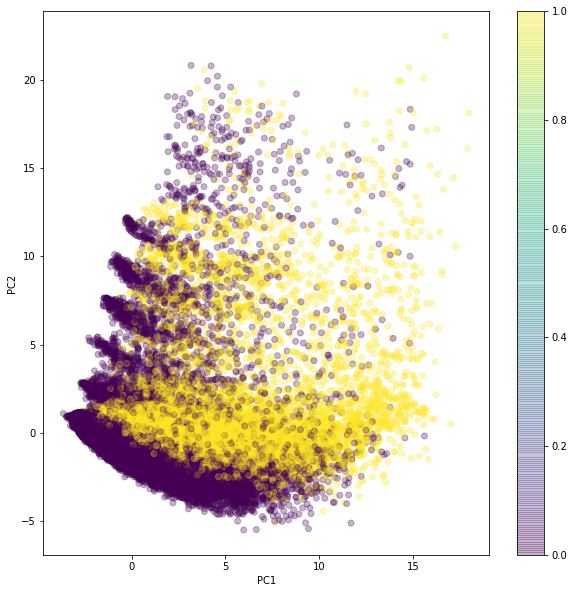

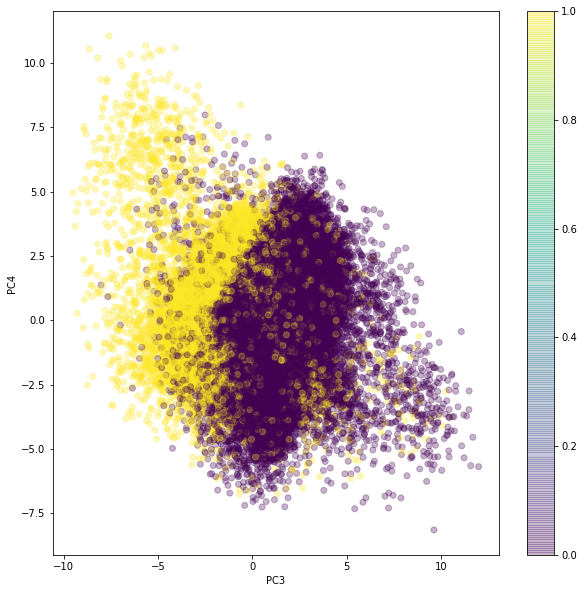

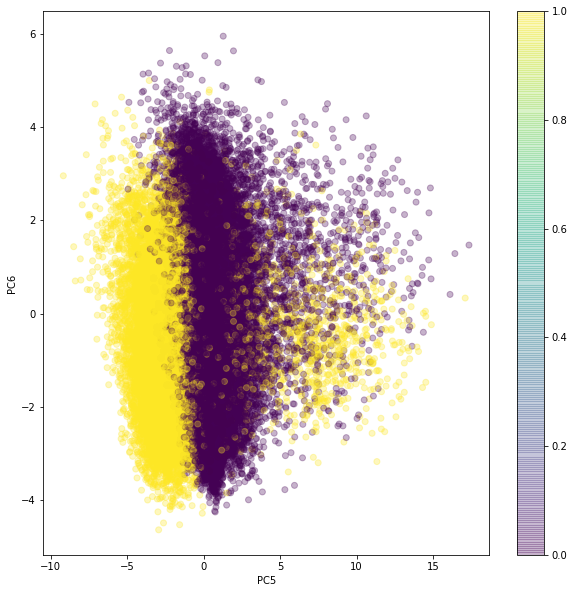

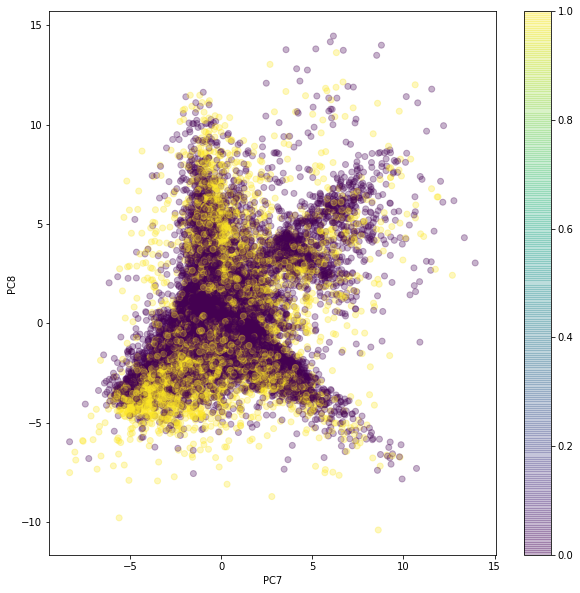

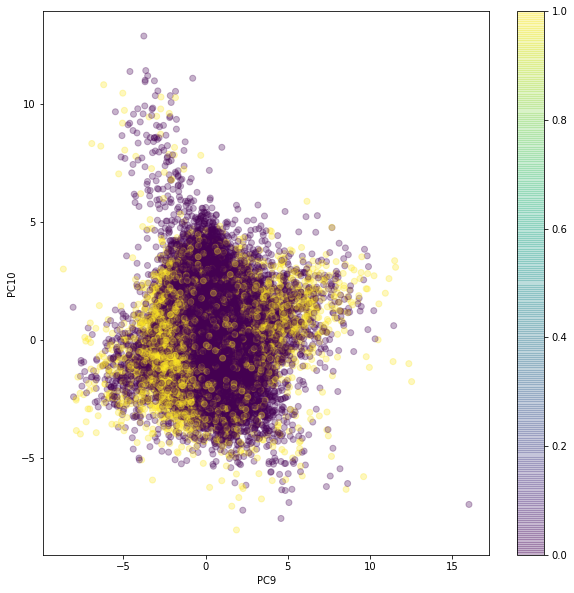

In [76]:
M = 100000
sample_idx = np.random.choice(np.arange(mapped_snps.shape[0]), M, replace=False)

subsampled_snps = mapped_snps[sample_idx,:]

for i in range(0, n_comp, 2):
    plt.figure(figsize=(10, 10))
    plt.scatter(subsampled_snps[:, i], subsampled_snps[:, i+1], c=annot_df['DHS_Trynka'].values[sample_idx], alpha=0.3)
    plt.xlabel("PC" + str(i + 1))
    plt.ylabel("PC" + str(i + 2))
    plt.colorbar()
    plt.show()

In [5]:
import umap
reducer = umap.UMAP()
embedding = reducer.fit_transform(annot_df.iloc[:, 5:].values)

KeyboardInterrupt: 

In [239]:
plt.scatter(embedding[:, 0], embedding[:, 1])
plt.show()

In [9]:
list(annot_df.columns)

['CHR',
 'BP',
 'SNP',
 'CM',
 'base',
 'Coding_UCSC',
 'Coding_UCSC.flanking.500',
 'Conserved_LindbladToh',
 'Conserved_LindbladToh.flanking.500',
 'CTCF_Hoffman',
 'CTCF_Hoffman.flanking.500',
 'DGF_ENCODE',
 'DGF_ENCODE.flanking.500',
 'DHS_peaks_Trynka',
 'DHS_Trynka',
 'DHS_Trynka.flanking.500',
 'Enhancer_Andersson',
 'Enhancer_Andersson.flanking.500',
 'Enhancer_Hoffman',
 'Enhancer_Hoffman.flanking.500',
 'FetalDHS_Trynka',
 'FetalDHS_Trynka.flanking.500',
 'H3K27ac_Hnisz',
 'H3K27ac_Hnisz.flanking.500',
 'H3K27ac_PGC2',
 'H3K27ac_PGC2.flanking.500',
 'H3K4me1_peaks_Trynka',
 'H3K4me1_Trynka',
 'H3K4me1_Trynka.flanking.500',
 'H3K4me3_peaks_Trynka',
 'H3K4me3_Trynka',
 'H3K4me3_Trynka.flanking.500',
 'H3K9ac_peaks_Trynka',
 'H3K9ac_Trynka',
 'H3K9ac_Trynka.flanking.500',
 'Intron_UCSC',
 'Intron_UCSC.flanking.500',
 'PromoterFlanking_Hoffman',
 'PromoterFlanking_Hoffman.flanking.500',
 'Promoter_UCSC',
 'Promoter_UCSC.flanking.500',
 'Repressed_Hoffman',
 'Repressed_Hoffman.fl

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader

def f(params, inputs, targets):
    predicted = N*torch.matmul(inputs, params)
    return torch.mean((targets - predicted)**2)

#####
n_annots = 100
n_snps = 1000
N = 10000


class Data(Dataset):
    def __init__(self):
        X_rand = torch.randn((n_snps, n_annots))
        self.x = torch.ones((n_snps, n_annots + 1))
        self.x[:,:-1] = X_rand
        
        self.true_params = torch.randn((n_annots + 1, 1))
        
        self.y = N*torch.matmul(self.x, self.true_params)
        self.len = self.x.shape[0]
    
    def __getitem__(self,index):            
        return self.x[index],self.y[index]
    
    def __len__(self):
        return self.len
    
dataset = Data()
trainloader = DataLoader(dataset=dataset, batch_size=128)

#####

params = torch.rand((n_annots + 1, 1))
params.requires_grad_()
optimizer = torch.optim.Adam([params], 1e-2)

losses = []

for ii in range(100):
    for X, Y in trainloader:
        loss = f(params, X, Y)
        optimizer.zero_grad()
        loss.backward()
        # Access gradient if necessary
        grad = params.grad.data
        optimizer.step()
    
    if ii % 100 == 0:
        print('Step # {}, loss: {}'.format(ii, loss.item()))
    
    losses.append(loss.item())


print("Final params:", params - dataset.true_params)


Step # 0, loss: 13360464896.0
Final params: tensor([[-2.9863e-03],
        [-1.2975e-03],
        [-1.4892e-03],
        [-4.5180e-04],
        [ 1.9938e-03],
        [-6.2437e-03],
        [ 1.4496e-03],
        [-3.7903e-04],
        [ 2.4396e-03],
        [-2.4945e-03],
        [ 6.4069e-04],
        [ 9.8336e-04],
        [ 3.2438e-03],
        [ 9.4041e-04],
        [ 2.9641e-03],
        [ 4.1014e-03],
        [ 5.1867e-03],
        [-4.2179e-03],
        [ 5.2071e-04],
        [-4.6669e-03],
        [-1.4025e-03],
        [ 2.1749e-03],
        [ 6.2597e-04],
        [-3.9349e-03],
        [ 1.4191e-03],
        [-1.4200e-03],
        [ 4.2690e-03],
        [-1.6500e-03],
        [ 1.0084e-03],
        [ 2.5415e-03],
        [-9.1034e-04],
        [ 2.9532e-03],
        [-4.1890e-04],
        [-6.5729e-03],
        [-8.0371e-04],
        [ 1.2901e-03],
        [ 7.4661e-04],
        [-8.0708e-04],
        [-1.3924e-03],
        [ 1.0838e-03],
        [-1.9658e-04],
        [-2.7

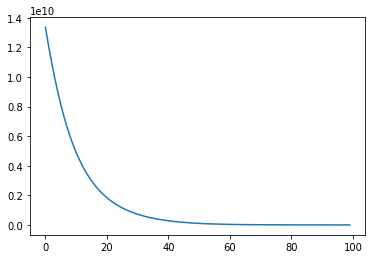

In [3]:
plt.plot(np.arange(len(losses)), losses)

In [2]:
len(losses)

100

In [5]:
np.arange(len(losses))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [5]:
import statsmodels.api as sm

data = sm.datasets.scotland.load()
data.exog = sm.add_constant(data.exog)

data

<class 'statsmodels.datasets.utils.Dataset'>

In [6]:
data.endog

array([60.3, 52.3, 53.4, 57. , 68.7, 48.8, 65.5, 70.5, 59.1, 62.7, 51.6,
       62. , 68.4, 69.2, 64.7, 75. , 62.1, 67.2, 67.7, 52.7, 65.7, 72.2,
       47.4, 51.3, 63.6, 50.7, 51.6, 56.2, 67.6, 58.9, 74.7, 67.3])

In [7]:
data.exog

array([[1.00000e+00, 7.12000e+02, 2.10000e+01, 1.05000e+02, 8.24000e+01,
        1.35660e+04, 1.23000e+01, 1.49520e+04],
       [1.00000e+00, 6.43000e+02, 2.65000e+01, 9.70000e+01, 8.02000e+01,
        1.35660e+04, 1.53000e+01, 1.70395e+04],
       [1.00000e+00, 6.79000e+02, 2.83000e+01, 1.13000e+02, 8.63000e+01,
        9.61100e+03, 1.39000e+01, 1.92157e+04],
       [1.00000e+00, 8.01000e+02, 2.71000e+01, 1.09000e+02, 8.04000e+01,
        9.48300e+03, 1.36000e+01, 2.17071e+04],
       [1.00000e+00, 7.53000e+02, 2.20000e+01, 1.15000e+02, 6.47000e+01,
        9.26500e+03, 1.46000e+01, 1.65660e+04],
       [1.00000e+00, 7.14000e+02, 2.43000e+01, 1.07000e+02, 7.90000e+01,
        9.55500e+03, 1.38000e+01, 1.73502e+04],
       [1.00000e+00, 9.20000e+02, 2.12000e+01, 1.18000e+02, 7.22000e+01,
        9.61100e+03, 1.33000e+01, 1.95040e+04],
       [1.00000e+00, 7.79000e+02, 2.05000e+01, 1.14000e+02, 7.52000e+01,
        9.48300e+03, 1.45000e+01, 1.59695e+04],
       [1.00000e+00, 7.71000e+02

In [39]:
ld_df = pd.read_csv("SLDSC-annot.csv", index_col=0)
ld_df['CHISQ'] = np.fmax(1e-6, ld_df['CHISQ'])
ld_df.describe()

,CHR,baseL2,Coding_UCSCL2,Coding_UCSC.flanking.500L2,Conserved_LindbladTohL2,Conserved_LindbladToh.flanking.500L2,CTCF_HoffmanL2,CTCF_Hoffman.flanking.500L2,DGF_ENCODEL2,DGF_ENCODE.flanking.500L2,...,Ancient_Sequence_Age_Human_Promoter.flanking.500L2,Ancient_Sequence_Age_Human_EnhancerL2,Ancient_Sequence_Age_Human_Enhancer.flanking.500L2,Human_Enhancer_Villar_Species_Enhancer_CountL2,Human_Promoter_Villar_ExACL2,Human_Promoter_Villar_ExAC.flanking.500L2,w_baseL2,N,CHISQ,Z
count,1.186058e+06,1.186058e+06,1.186058e+06,1.186058e+06,1.186058e+06,1.186058e+06,1.186058e+06,1.186058e+06,1.186058e+06,1.186058e+06,...,1.186058e+06,1.186058e+06,1.186058e+06,1.186058e+06,1.186058e+06,1.186058e+06,1.186058e+06,1186058.0,1.186058e+06,1.186058e+06
mean,8.757380e+00,1.239332e+02,1.818198e+00,6.380211e+00,3.003601e+00,3.679117e+01,2.565205e+00,5.102872e+00,1.507784e+01,4.647067e+01,...,6.443135e-01,5.467120e-01,9.467267e-01,6.908365e+00,3.361374e-01,8.287501e-02,2.073011e+01,458303.0,7.000264e+00,-3.174567e-03
std,5.815843e+00,1.465699e+02,3.616276e+00,1.106867e+01,3.464314e+00,3.507446e+01,2.974724e+00,5.631393e+00,1.441179e+01,4.006963e+01,...,1.561682e+00,1.324530e+00,2.040212e+00,1.979083e+01,1.190019e+00,3.299308e-01,1.752357e+01,0.0,2.196676e+01,2.645800e+00
min,1.000000e+00,-2.379900e+01,-4.630000e-01,-7.580000e-01,-2.610000e-01,-1.462000e+00,-3.840000e-01,-4.020000e-01,-6.250000e-01,-1.989000e+00,...,-2.340000e-01,-1.510000e-01,-2.240000e-01,-2.406000e+00,-1.460000e-01,-5.200000e-02,1.230000e-01,458303.0,1.000000e-06,-2.140150e+01
25%,4.000000e+00,5.116200e+01,4.900000e-02,2.340000e-01,7.690000e-01,1.478200e+01,6.940000e-01,1.658000e+00,6.062000e+00,2.110000e+01,...,0.000000e+00,2.000000e-03,9.000000e-03,4.000000e-03,0.000000e+00,0.000000e+00,9.786000e+00,458303.0,3.116989e-01,-1.212900e+00
50%,8.000000e+00,8.925150e+01,4.010000e-01,1.779000e+00,1.972000e+00,2.760500e+01,1.661000e+00,3.515000e+00,1.100300e+01,3.571000e+01,...,5.500000e-02,6.500000e-02,1.400000e-01,5.900000e-01,0.000000e+00,0.000000e+00,1.634400e+01,458303.0,1.460231e+00,-4.100000e-03
75%,1.300000e+01,1.532700e+02,2.030000e+00,7.747000e+00,3.998000e+00,4.769800e+01,3.386000e+00,6.664000e+00,1.923100e+01,5.930700e+01,...,4.900000e-01,4.410000e-01,9.110000e-01,4.611000e+00,8.300000e-02,1.400000e-02,2.621900e+01,458303.0,5.014912e+00,1.204000e+00
max,2.200000e+01,5.090087e+03,9.547400e+01,1.923150e+02,7.874000e+01,1.299839e+03,1.292110e+02,3.056090e+02,6.385350e+02,1.581634e+03,...,5.074600e+01,3.362600e+01,4.260400e+01,6.050960e+02,2.982500e+01,9.871000e+00,2.742510e+02,458303.0,4.581398e+02,2.140420e+01


In [40]:
import statsmodels.api as sm
design_mat = ld_df.loc[:, ['N', 'baseL2']]
design_mat['baseL2'] *= design_mat['N']
design_mat['N'] = np.ones(len(design_mat))

#var_weights=1./ld_df['w_baseL2'].values
#link = sm.families.links.log

w = np.sqrt(ld_df[['w_baseL2']].values)
w = w / float(np.sum(w))

E_S_j = np.multiply(design_mat.values, w)
S_j = np.multiply(ld_df[['CHISQ']].values, w)

In [44]:
gamma_model = sm.GLM(S_j, 2.*E_S_j,
                     family=sm.families.Gamma(link = sm.families.links.identity))
gamma_results = gamma_model.fit()
gamma_results.summary()

/anaconda3/lib/python3.6/site-packages/statsmodels/genmod/generalized_linear_model.py:302: DomainWarning: The identity link function does not respect the domain of the Gamma family.
  DomainWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:              1186058
Model:                            GLM   Df Residuals:                  1186056
Model Family:                   Gamma   Df Model:                            1
Link Function:               identity   Scale:                          8.9631
Method:                          IRLS   Log-Likelihood:             1.3433e+07
Date:                Wed, 19 Feb 2020   Deviance:                   4.2577e+06
Time:                        16:50:21   Pearson chi2:                 1.06e+07
No. Iterations:                    21   Covariance Type:             nonrobust
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0442      0.011     97.054      0.000       1.023       1.065
x2          4.599e-08   3.04e-10    151.069      0.000    4.54e-08    4.66e-08
==============================================================================
"""

In [177]:
gamma_model = sm.GLM(S_j, 2.*E_S_j,
                     family=sm.families.Gamma(link = sm.families.links.identity))
gamma_results = gamma_model.fit()
gamma_results.params

/anaconda3/lib/python3.6/site-packages/statsmodels/genmod/generalized_linear_model.py:302: DomainWarning: The identity link function does not respect the domain of the Gamma family.
  DomainWarning)


array([1.04421412e+00, 4.59947880e-08])

In [36]:
np.linalg.lstsq(E_S_j, S_j)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.


(array([[8.68893523e+00],
        [2.04865324e-08]]),
 array([0.0008752]),
 2,
 array([1.77566609e+05, 8.06167183e-04]))

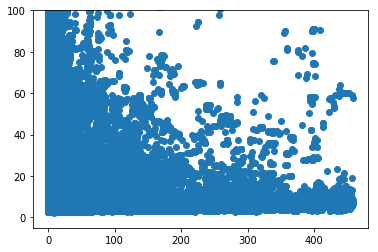

In [94]:
plt.scatter(ld_df['CHISQ'].values, gamma_results.predict(design_mat.values))
plt.ylim([-5, 100])
plt.show()

In [93]:
np.corrcoef(ld_df['CHISQ'].values, gamma_results.predict(design_mat.values))

array([[ 1.       , -0.0021282],
       [-0.0021282,  1.       ]])

In [96]:
np.median((ld_df['CHISQ'].values - gamma_results.predict(design_mat.values))**2)

15.210591924512176

In [98]:
list(enumerate([1,2,3], 1))

[(1, 1), (2, 2), (3, 3)]

In [126]:
df1 = pd.read_csv("/Users/szabad/PycharmProjects/GSR/data/PASS_LDL.sumstats_regression_results.csv", index_col=0)
df2 = pd.read_csv("/Users/szabad/PycharmProjects/GSR/gsr_methods/pvalue_df.csv")

                                                           tau_c    t-value  \
REACTOME_CELL_CELL_JUNCTION_ORGANIZATION            2.734891e-10  10.411118   
REACTOME_CELL_JUNCTION_ORGANIZATION                 1.856475e-10  10.004208   
KEGG_ALPHA_LINOLENIC_ACID_METABOLISM                2.639923e-10   8.507757   
REACTOME_ALPHA_LINOLENIC_ACID_ALA_METABOLISM        2.509398e-10   8.233180   
REACTOME_IMMUNOREGULATORY_INTERACTIONS_BETWEEN_...  1.509275e-10   7.732513   

                                                         p-value  
REACTOME_CELL_CELL_JUNCTION_ORGANIZATION            4.338579e-25  
REACTOME_CELL_JUNCTION_ORGANIZATION                 2.603881e-23  
KEGG_ALPHA_LINOLENIC_ACID_METABOLISM                2.407951e-17  
REACTOME_ALPHA_LINOLENIC_ACID_ALA_METABOLISM        2.385724e-16  
REACTOME_IMMUNOREGULATORY_INTERACTIONS_BETWEEN_...  1.301261e-14  
                                         Pathway  log10_pvalue
0                KEGG_GLYCOLYSIS_GLUCONEOGENESIS      0.4559

In [127]:
comb_df = pd.merge(df1, df2, left_index=True, right_on='Pathway')
comb_df.head()

,tau_c,t-value,p-value,Pathway,log10_pvalue
412,2.734891e-10,10.411118,4.338579e-25,REACTOME_CELL_CELL_JUNCTION_ORGANIZATION,0.445894
440,1.856475e-10,10.004208,2.603881e-23,REACTOME_CELL_JUNCTION_ORGANIZATION,0.548378
40,2.639923e-10,8.507757,2.407951e-17,KEGG_ALPHA_LINOLENIC_ACID_METABOLISM,0.434654
269,2.509398e-10,8.233180,2.385724e-16,REACTOME_ALPHA_LINOLENIC_ACID_ALA_METABOLISM,0.430113
204,1.509275e-10,7.732513,1.301261e-14,REACTOME_IMMUNOREGULATORY_INTERACTIONS_BETWEEN...,0.469439


In [128]:
comb_df['p-value'] = -np.log10(comb_df['p-value'])
comb_df.head()

,tau_c,t-value,p-value,Pathway,log10_pvalue
412,2.734891e-10,10.411118,24.362653,REACTOME_CELL_CELL_JUNCTION_ORGANIZATION,0.445894
440,1.856475e-10,10.004208,22.584379,REACTOME_CELL_JUNCTION_ORGANIZATION,0.548378
40,2.639923e-10,8.507757,16.618352,KEGG_ALPHA_LINOLENIC_ACID_METABOLISM,0.434654
269,2.509398e-10,8.233180,15.622380,REACTOME_ALPHA_LINOLENIC_ACID_ALA_METABOLISM,0.430113
204,1.509275e-10,7.732513,13.885635,REACTOME_IMMUNOREGULATORY_INTERACTIONS_BETWEEN...,0.469439


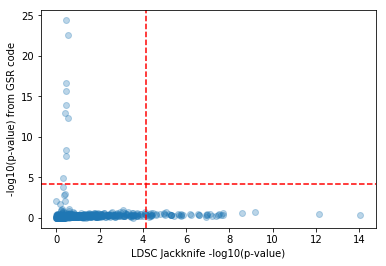

In [129]:
plt.scatter(comb_df['log10_pvalue'], comb_df['p-value'], alpha=.3)
plt.xlabel("LDSC Jackknife -log10(p-value)")
plt.ylabel("-log10(p-value) from GSR code")
plt.axhline(y=-np.log10(0.05/714), color='r', linestyle='--')
plt.axvline(x=-np.log10(0.05/714), color='r', linestyle='--')

In [76]:
from scipy import optimize
import nlopt

In [84]:
X = np.random.normal(size=(100, 5))
X[:, 0] = 1.

true_beta = np.random.normal(size=5)

Y = X@true_beta + np.random.normal(scale=.3)

def f(b, grad=None):
    return np.linalg.norm(Y - X@b)**2

def fp(b):
    return np.array(2*X.T@(Y - X@b)).reshape(-1, 1)

def fp2(b):
    return 2*X.T@X

optimize.newton(f, x0=np.zeros(shape=5).reshape(-1, 1), fprime=fp, fprime2=fp2)

IndexError: too many indices for array

In [52]:
np.zeros(shape=5), true_beta

(array([0., 0., 0., 0., 0.]),
 array([ 1.9586744 , -0.15404968, -1.60306698, -0.33719172, -0.65901208]))

In [70]:
print(f(true_beta))
print(fp(true_beta))
print(fp2(true_beta))

[0.02607721]
[[3.22968769]
 [0.10534707]
 [0.11267639]
 [0.2548396 ]
 [0.07791788]]
[[200.           6.5236691    6.97754096  15.7810679    4.82510306]
 [  6.5236691  160.00523129   7.23953364  -1.00042941  33.50483928]
 [  6.97754096   7.23953364 194.8083052    3.06375034   4.98337873]
 [ 15.7810679   -1.00042941   3.06375034 183.35506155  26.3530947 ]
 [  4.82510306  33.50483928   4.98337873  26.3530947  196.23533388]]


In [61]:
fp(true_beta)

array([ 80.05911145,  -2.389506  ,   2.94418443,   1.12781387,
       -10.92351473])

In [85]:
opt = nlopt.opt(nlopt.LD_MMA, 5)
opt.set_min_objective(f)

opt.optimize(np.zeros(shape=5))

KeyboardInterrupt: 

In [168]:
def loglik(tau, X, Y, u=None):
    if u is None:
        u = np.ones(len(X))
    
    snp_ll = Y / (2.*X@tau) + np.log(Y) + np.log(2*X@tau) + np.log(np.pi)
    
    return -.5*np.dot(1./u, snp_ll)


def score(tau, X, Y, u=None):
    if u is None:
        u = np.ones(len(X))
    
    mu = X@tau
        
    V = np.diag(1./(2*u*(mu**2)))
    
    return X.T@V@(Y - mu)


def hessian(tau, X, Y, u=None, use_fisher=True):
    if u is None:
        u = np.ones(len(X))
    
    mu = X@tau
    
    if use_fisher:
        W = np.diag(1./(2*u*(mu**2)))
        return -X.T@W@X
    else:
        V = np.diag((mu - 2*Y)/(2*u*(mu**3)))
        return X.T@V@X

    

In [169]:
X = np.random.gamma(1., 1., size=(100, 5))
X[:, 0] = 1

tau = np.random.uniform(size=5)

Y = np.random.gamma(.5, X@tau, size=100)

In [172]:
tau_t = np.zeros(5)
tau_t[0] = 1.

tau_tf = np.copy(tau_t)

for t in range(100):
    print(loglik(tau_t, X, Y), loglik(tau_tf, X, Y))
    
    mu_tf = score(tau_tf, X, Y)
    H_tf = hessian(tau_tf, X, Y)

    tau_tf -= np.linalg.inv(H_tf)@mu_tf
    
    mu_t = score(tau_t, X, Y)
    H_t = hessian(tau_t, X, Y, use_fisher=False)
    
    tau_t -= np.linalg.inv(H_t)@mu_t

tau_t, tau_tf, tau

-28.803773583928 -28.803773583928
nan -21.803602326131383
nan -21.51034303151836
nan -21.485729676709642
nan -21.47878054339499
nan -21.47650297539813
nan -21.47564183491812
nan -21.47518765431566
nan -21.474866259617965
nan -21.474604113884126
nan -21.47437968528817
nan -21.474184317236844
nan -21.474012921971198
nan -21.473861770412814
nan -21.47372788880464
nan -21.473608836845248
nan -21.47350258698716
nan -21.473407441809446
nan -21.473321971567405
nan -21.473244965408654
nan -21.473175392678332
nan -21.47311237195411
nan -21.47305514608771
nan -21.473003061959457
nan -21.47295555395811
nan -21.472912130425353
nan -21.47287236247411
nan -21.472835874718953
nan -21.472802337555247
nan -21.472771460699292
nan -21.4727429877604
nan -21.472716691661518
nan -21.472692370760672
nan -21.472669845553902
nan -21.47264895586244
nan -21.472629558425123
nan -21.472611524830697
nan -21.47259473973671
nan -21.472579099330716
nan -21.47256450999687
nan -21.472550887157478
nan -21.47253815426384


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """


(array([ 1.11856738e+20,  4.57893640e+18, -7.42966515e+18, -6.21378033e+19,
        -1.10428292e+20]),
 array([ 0.34413214, -0.02594542,  0.05519026,  0.22506814,  0.29746795]),
 array([0.15557653, 0.17545095, 0.09940871, 0.70758483, 0.76458516]))

In [111]:
from autograd import grad
import numpy as np

In [112]:
tau_t = np.random.normal(size=5)
grad(loglik)(tau_t, X, Y)
loglik_prime(tau_t, X, Y)

AttributeError: 'ArrayBox' object has no attribute 'log'

In [165]:
-np.linalg.inv(np.array([[1., 0], [0., 1]]))

array([[-1., -0.],
       [-0., -1.]])

In [174]:
np.random.gamma(.5, X@tau, size=100)

array([1.02916723e+01, 6.40719545e-03, 9.72630813e-02, 5.81660882e-01,
       6.67521569e+00, 8.83513465e-03, 1.72593547e+00, 2.84813311e+00,
       1.53791769e-02, 3.06609708e+00, 3.86519112e-04, 9.28693667e-04,
       3.36087070e+00, 1.23329057e+00, 1.72242889e-02, 1.28127402e-01,
       1.63421820e-01, 1.12350947e+01, 1.08539650e+00, 2.63533140e-03,
       5.07600732e-01, 4.40814901e-01, 2.77141330e+00, 2.77242809e-01,
       1.36243423e+00, 9.58706062e-02, 1.95235836e-03, 9.90398617e-03,
       6.72550502e-01, 1.21934267e+00, 1.84248914e+00, 1.50753472e-02,
       8.50643621e-02, 2.38497792e-02, 6.55961714e-01, 8.78849773e-01,
       1.23456949e-01, 5.97351948e-01, 7.00176418e-01, 4.70018991e+00,
       3.33917018e-02, 2.58326895e-01, 5.65576858e-03, 2.86629647e-02,
       1.50583686e-04, 2.46513567e-01, 4.65225629e-02, 1.56345843e+00,
       1.67201747e+00, 8.41938345e-02, 5.55180431e-02, 3.57187404e-01,
       3.18199961e-02, 5.06612203e+00, 1.45331015e-01, 6.93384293e-01,
      